## Angular Response function for LISA


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpmath import spherharm
from  nest import detectors as det
from nest import nell

In [2]:
L = 2.5e9 # [km]
c = 3e8 # [km/s]
f_star = c/2/np.pi/L # [Hz]

In [3]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

In [4]:
def e_plus(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,u)-np.einsum('i...,k...',v,v))

def e_cross(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,v)+np.einsum('i...,k...',v,u))

ortogonality condition.

In [5]:
Theta_vec = np.linspace(0,np.pi,100)
Phi_vec = np.linspace(0,2*np.pi,1)
Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
# Verify the orthogonality condition
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_cross(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_plus(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


## LISA Response function



In [6]:
def Evaluate_Product(l_vec,Theta_mesh,Phi_mesh,tensor):
    if tensor == 'plus':
        e_values = e_plus(Theta_mesh,Phi_mesh)
    elif tensor == 'cross':
        e_values = e_cross(Theta_mesh,Phi_mesh)
    result = np.einsum('i,j,lmij', l_vec,l_vec, e_values) # [n_Phi, n_Theta]
    return result
    

Transfer function.
\begin{equation*}
\mathcal{T}(f,\hat{l}_{AB},\hat{n})=\frac{1}{2}\left[e^{ -\pi i f L (1+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1+\hat{k}\cdot \hat{l}_{AB})\right)+ e^{ -\pi i f L (3+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1-\hat{k}\cdot \hat{l}_{AB})\right)\right]
\end{equation*}



In [7]:
# Build the transfer function
def F_cal(l,Omega,f_vec,f_star):
    inner = np.einsum('i,ijk',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

In [8]:
print(3e8/(2*np.pi*2.5e9))

0.019098593171027443


0.01909859317102744
0.019098593171027443


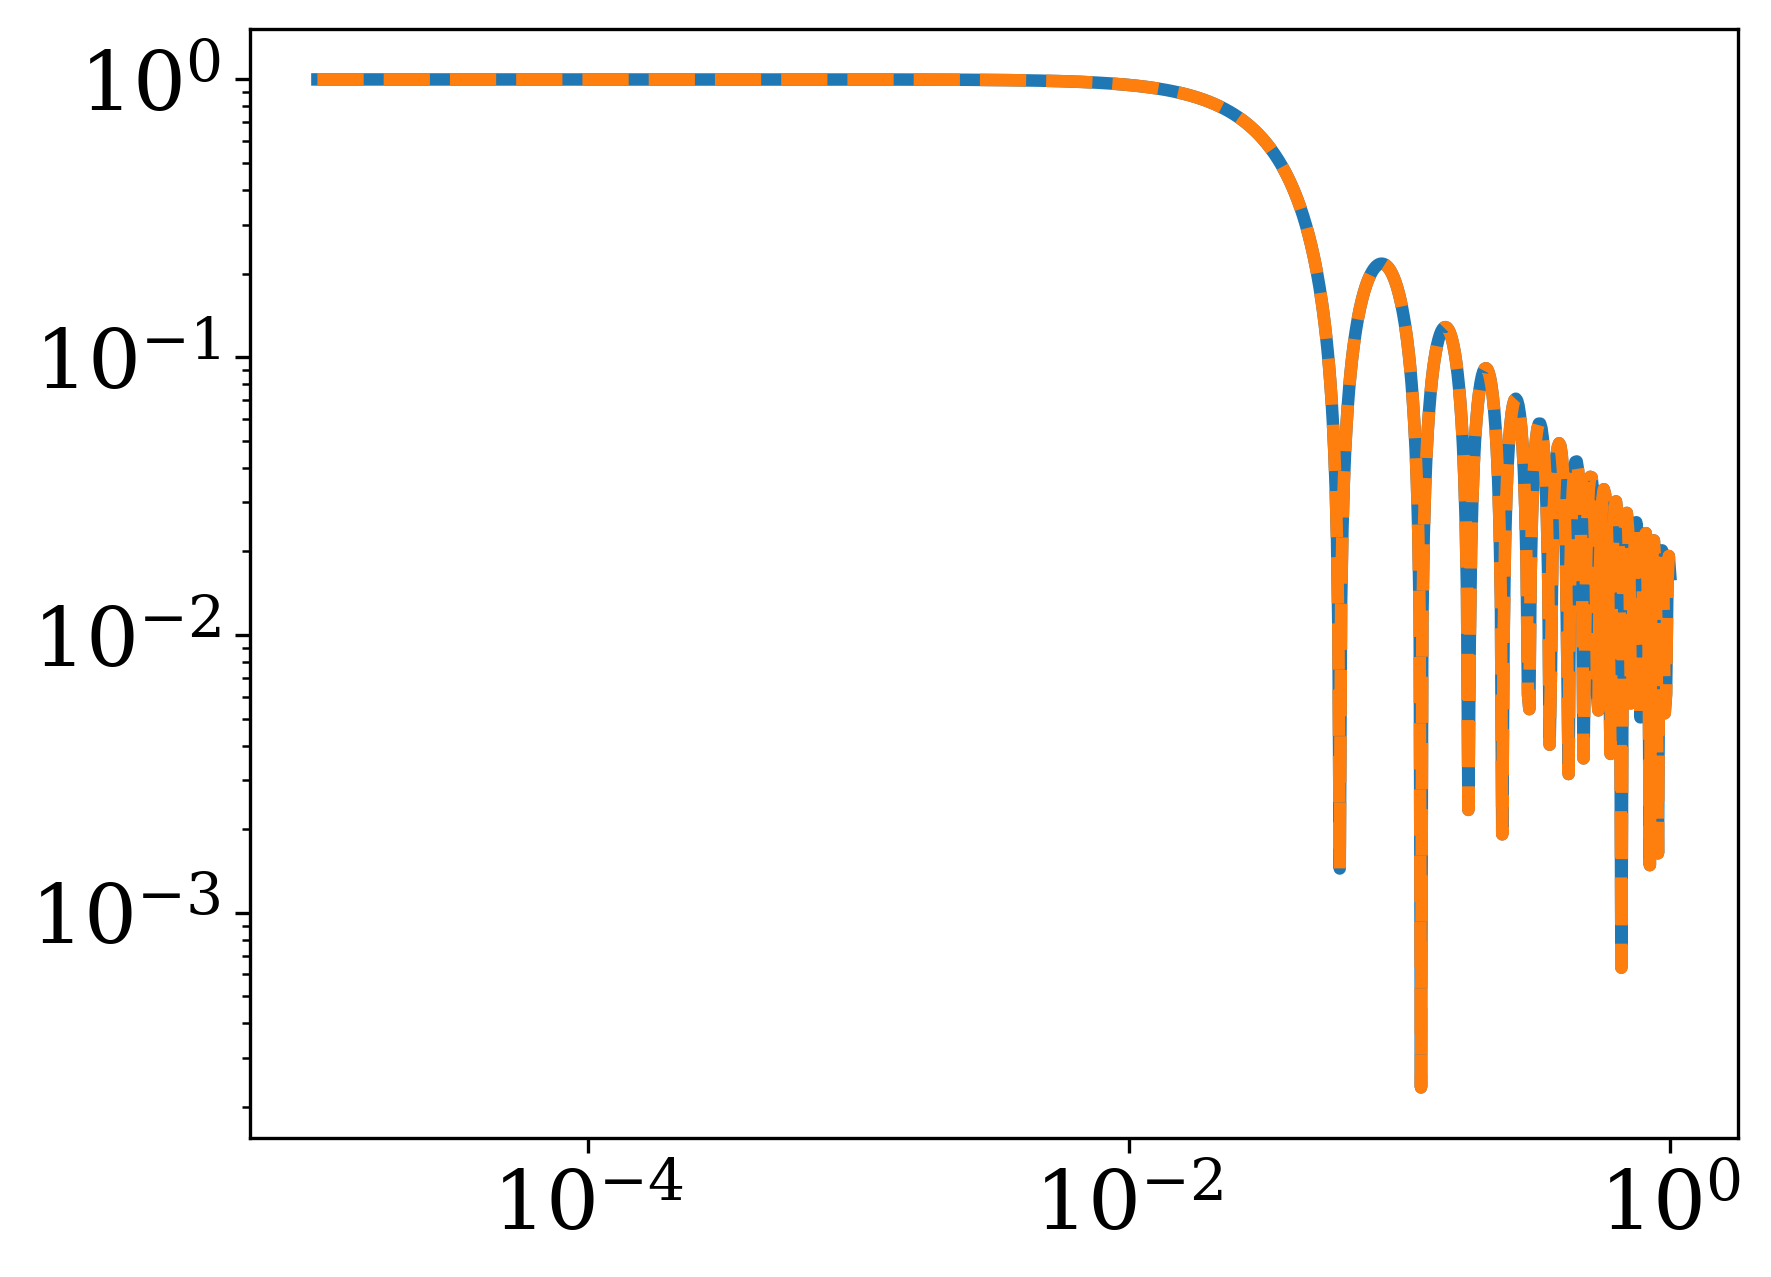

/opt/anaconda3/envs/dethenv/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/dethenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_61867/612073706.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


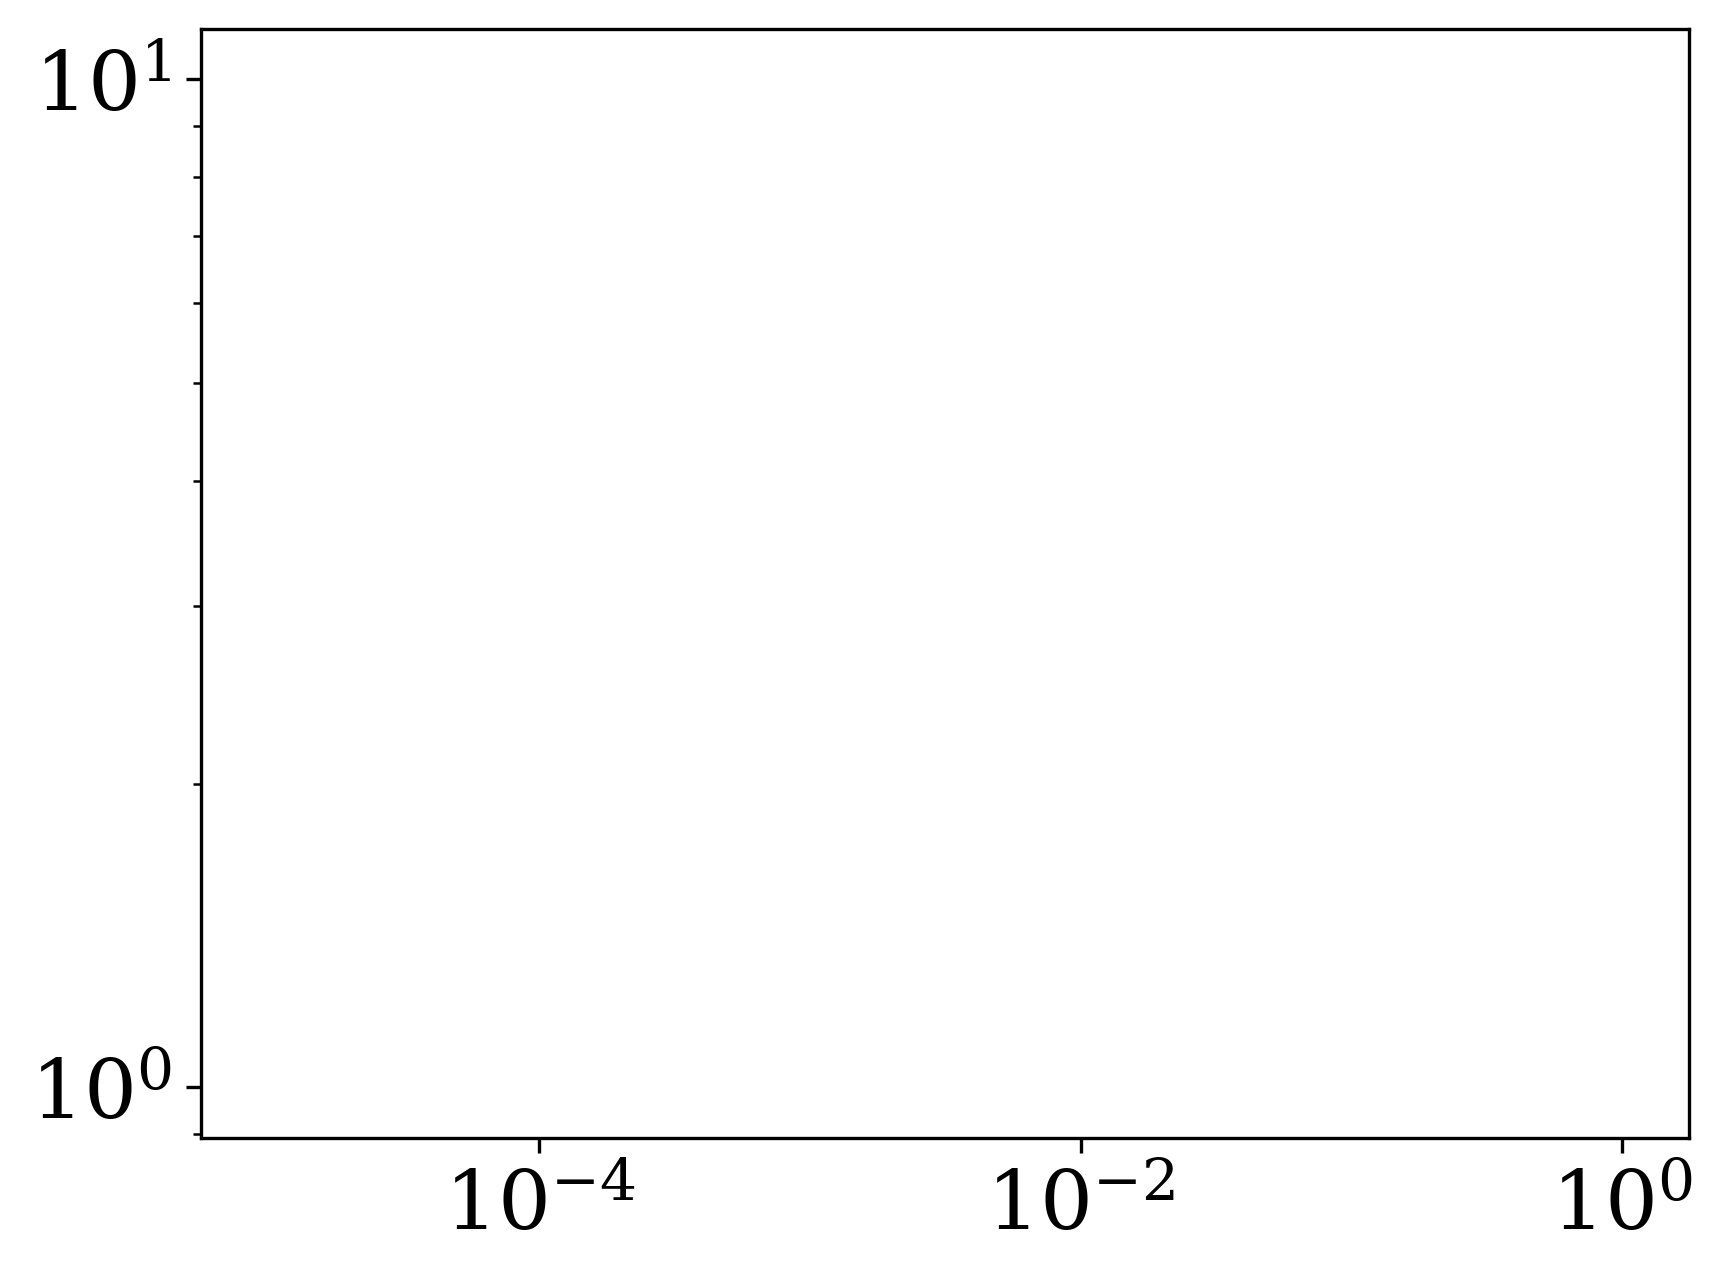

In [9]:
# check the transfer function

# Build the transfer function
def F(l,Omega,f_vec,f_star):
    inner = np.einsum('i,i',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

Omega_local = np.round(np.array([np.cos(0)*np.sin(0),np.sin(0)*np.sin(0),np.cos(0)]),20)

f = np.logspace(-5,0,1000)
f_star = c/2/np.pi/L # [Hz]
lBA = xB - xA

F = F(lBA,Omega_local,f,f_star)

theta = np.array(0)
phi = np.array(0)
theta = np.expand_dims(theta, axis=(0,1))
phi = np.expand_dims(phi, axis=(0,1))
F_GWBird = nell.get_tf(f, 'LISA 1', theta, phi, 0, shift_angle=None)

F_GWBird = np.squeeze(F_GWBird)

print(3e8/(2*np.pi*2.5e9))

# plot

plt.figure()
plt.plot(f, np.abs(F))
plt.plot(f, np.abs(F_GWBird), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(f, F- F_GWBird)
plt.xscale('log')
plt.yscale('log')
plt.show()





Check $\mathcal{T} (f\ll f_*) = 1$. 

In [10]:
f_vec_try = np.logspace(-5,-3,200)
print(np.real(F_cal(lBA,Omega,np.expand_dims(f_vec_try,axis=(1,2)),f_star)))

[[[0.99999982 0.99999982 0.99999981 ... 0.99999981 0.99999982 0.99999982]]

 [[0.99999981 0.99999981 0.9999998  ... 0.9999998  0.99999981 0.99999981]]

 [[0.9999998  0.9999998  0.99999979 ... 0.99999979 0.9999998  0.9999998 ]]

 ...

 [[0.99833472 0.9983148  0.9982947  ... 0.9982947  0.9983148  0.99833472]]

 [[0.99825587 0.99823501 0.99821396 ... 0.99821396 0.99823501 0.99825587]]

 [[0.9981733  0.99815145 0.9981294  ... 0.9981294  0.99815145 0.9981733 ]]]


### Step 3


\begin{equation*}
    \mathcal{R}_{AA'}(f) = \int \frac{d\Omega_{\vec {k}}}{4 \pi} \left[ \mathcal{R}_A^+(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^+}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n}) + \mathcal{R}_A^{\times}(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^{\times}}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n})\right]\,,
\end{equation*}
with
\begin{equation*}
\mathcal{R}_A^P(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}) = \frac{1}{2} e^{-i2\pi f \hat{n}\cdot\vec{x}_A/c} \left[\mathcal{T}(f,\hat{l}_{AB},\hat{n})-\mathcal{T}(f,\hat{l}_{AC},\hat{n})  \right]
\end{equation*}



In [11]:
def F_det (l1,l2,Theta_mesh,Phi_mesh,f_vec,f_star,x_det):
    Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    F_1 = F_cal(l1,Omega,f_exp,f_star)
    F_2 = F_cal(l2,Omega,f_exp,f_star)
    return 1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'plus')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'plus')),\
            1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'cross')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'cross')),

def Response(l_det1,l_det2,x_det1,x_det2,f_vec,f_star):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand = F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)
    R1 = np.trapz(R_integrand,Phi_vec,axis=1)
    R = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))*1/4/np.pi
    return R

#tinto
#Saito

0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744


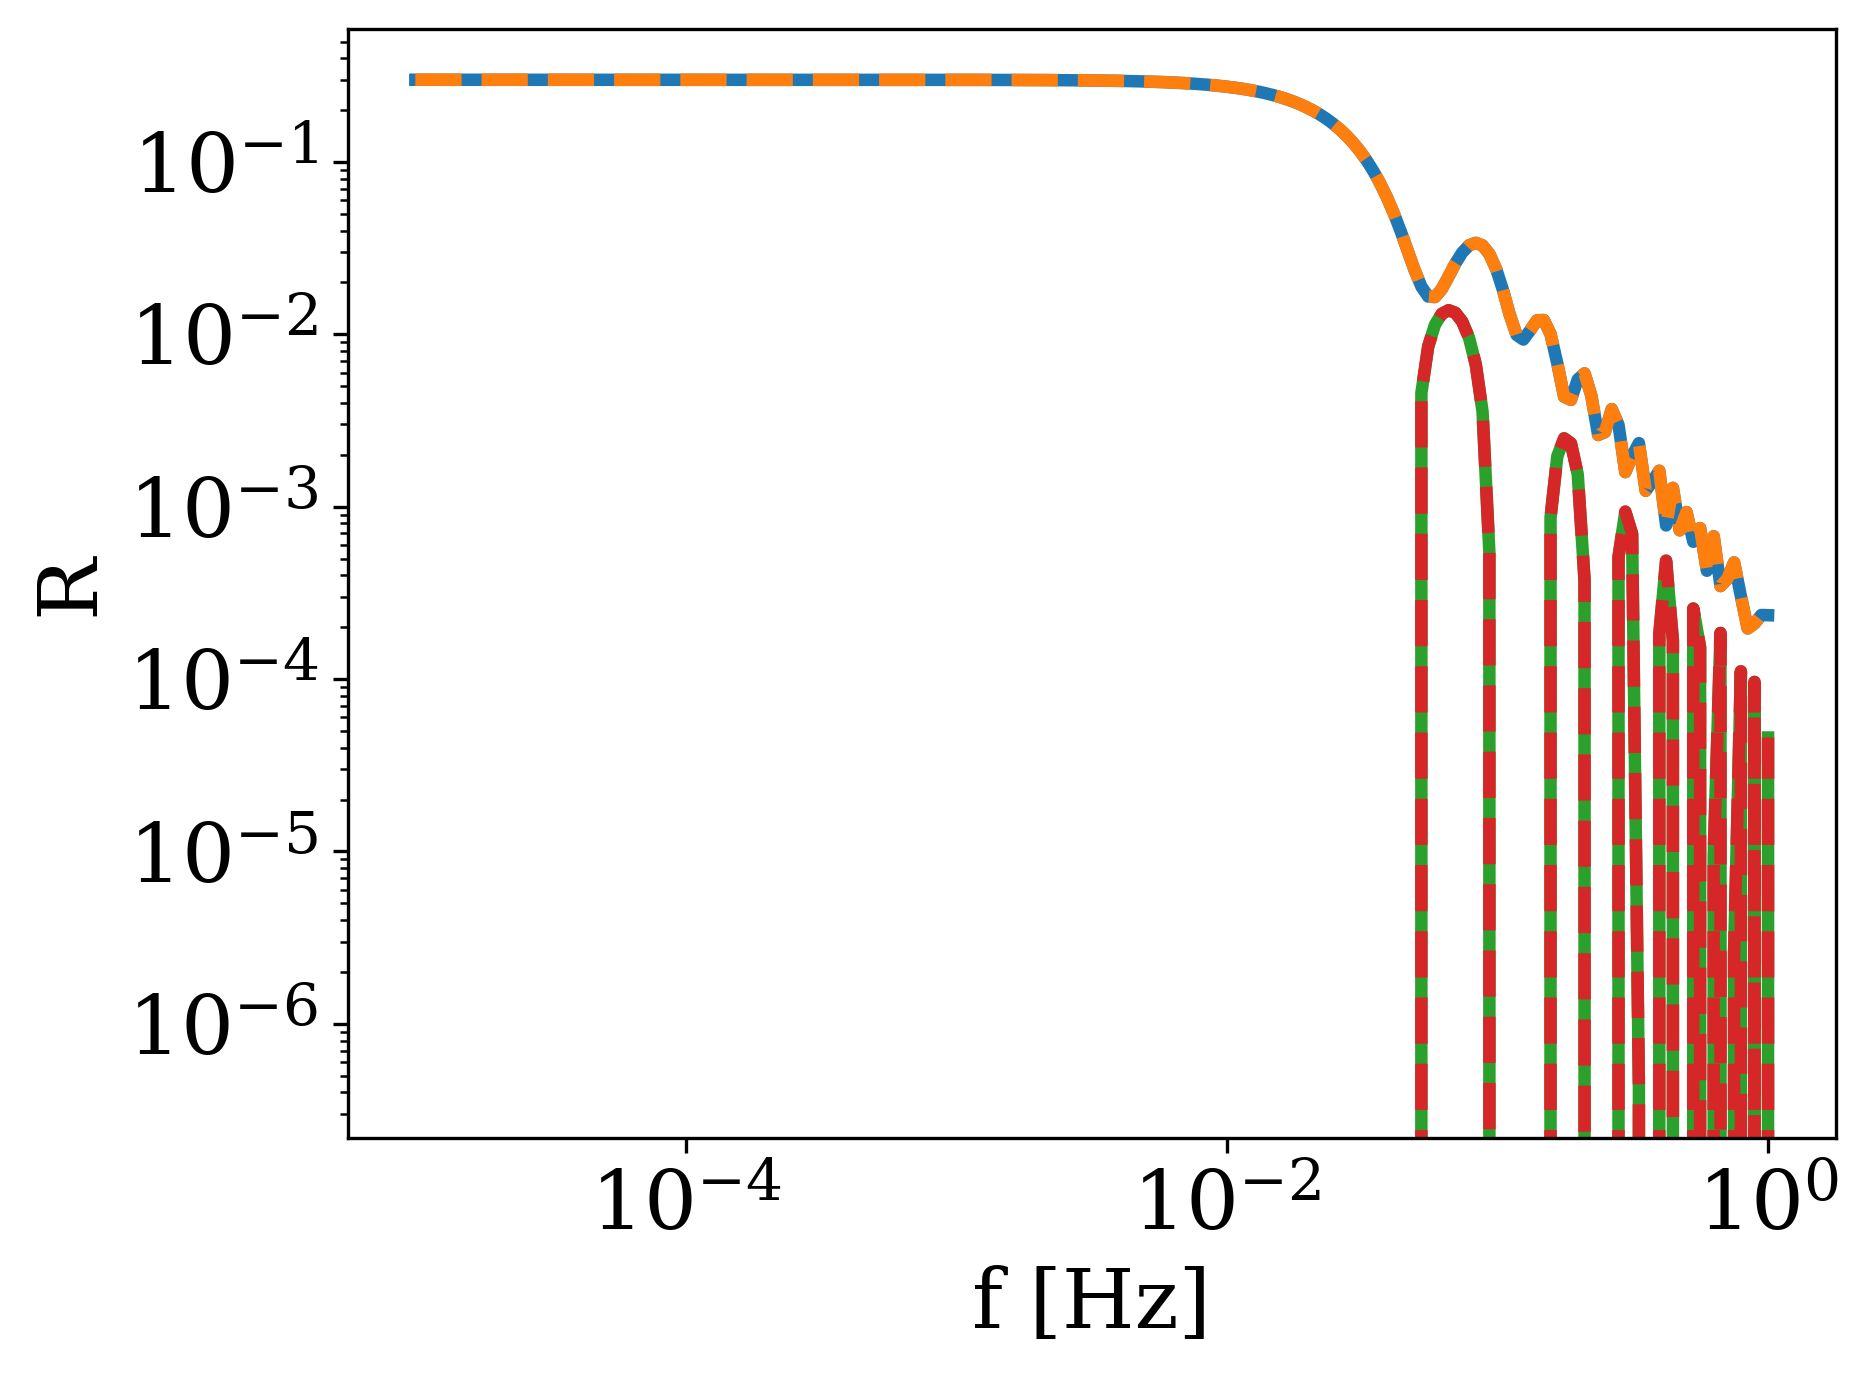

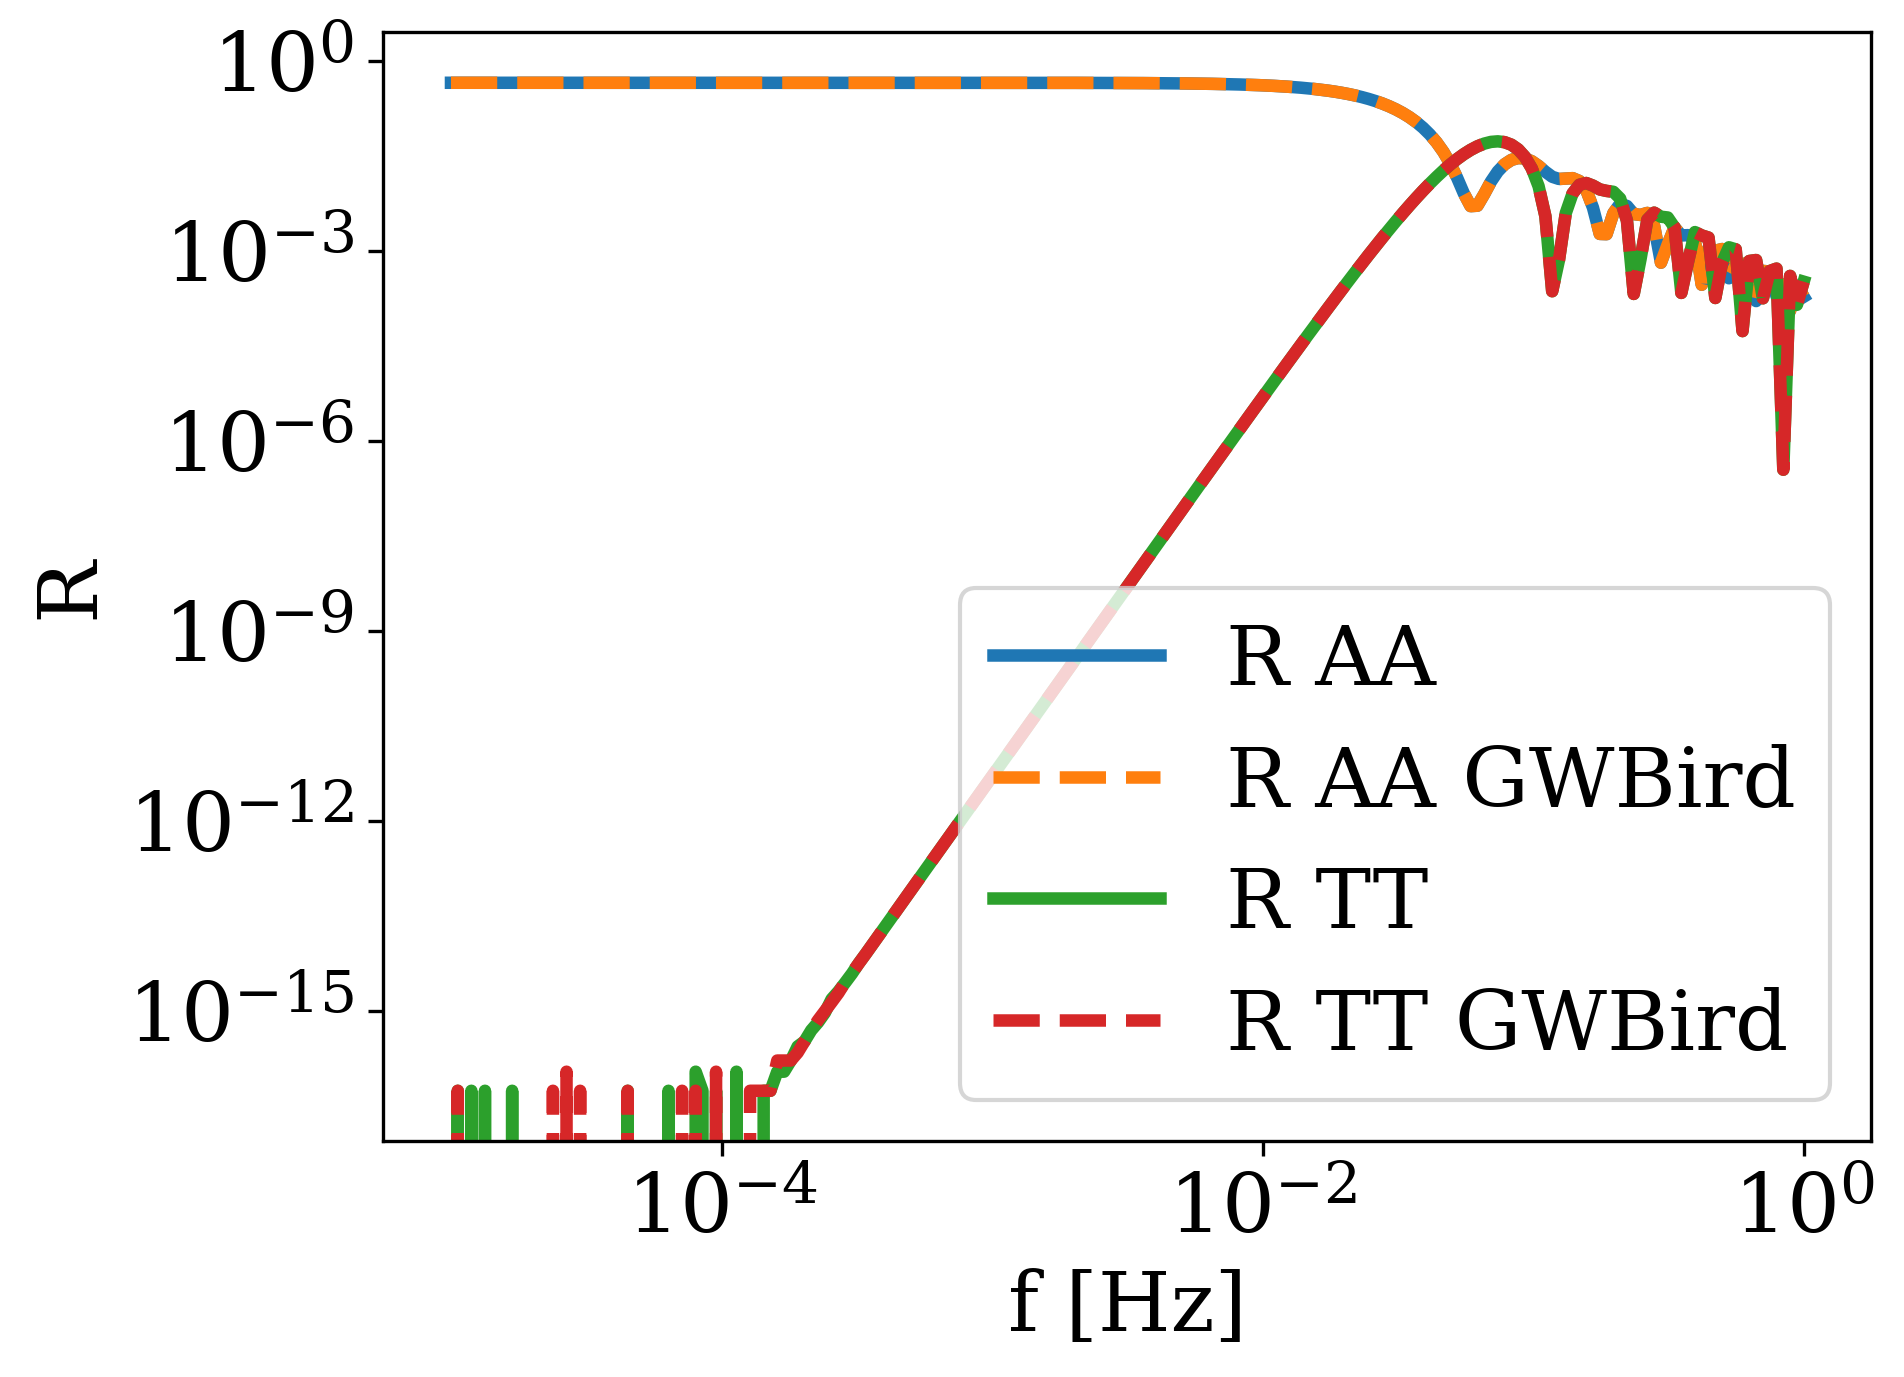

In [19]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)

L = 2.5e9

f_vec = np.logspace(-5,0,200)

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

R1_GWBird = 2/5*nell.Rlm_transfer(0,0, lBA, lCA, xA, lBA, lCA, xA, 0, f_vec, 't', L)
R2_GWBird = 2/5*nell.Rlm_transfer(0,0, lBA, lCA, xA, -lBC, -lBA, xB, 0, f_vec, 't', L)

plt.plot(f_vec, R1_vec)
plt.plot(f_vec, R1_GWBird, linestyle='--')
plt.plot(f_vec, R2_vec)
plt.plot(f_vec, R2_GWBird, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.show()

plt.plot(f_vec, R1_vec - R2_vec, label='R AA')
plt.plot(f_vec, R1_GWBird - R2_GWBird, linestyle='--', label='R AA GWBird')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.legend()

plt.plot(f_vec, R1_vec + 2*R2_vec, label='R TT')
plt.plot(f_vec, R1_GWBird + 2*R2_GWBird, linestyle='--', label='R TT GWBird')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.legend()



[0.5       0.8660254 0.       ]
[-0.5        0.8660254  0.       ]
[1. 0. 0.]
[0.5       0.8660254 0.       ]
[-0.5        0.8660254  0.       ]
[-1. -0. -0.]
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744


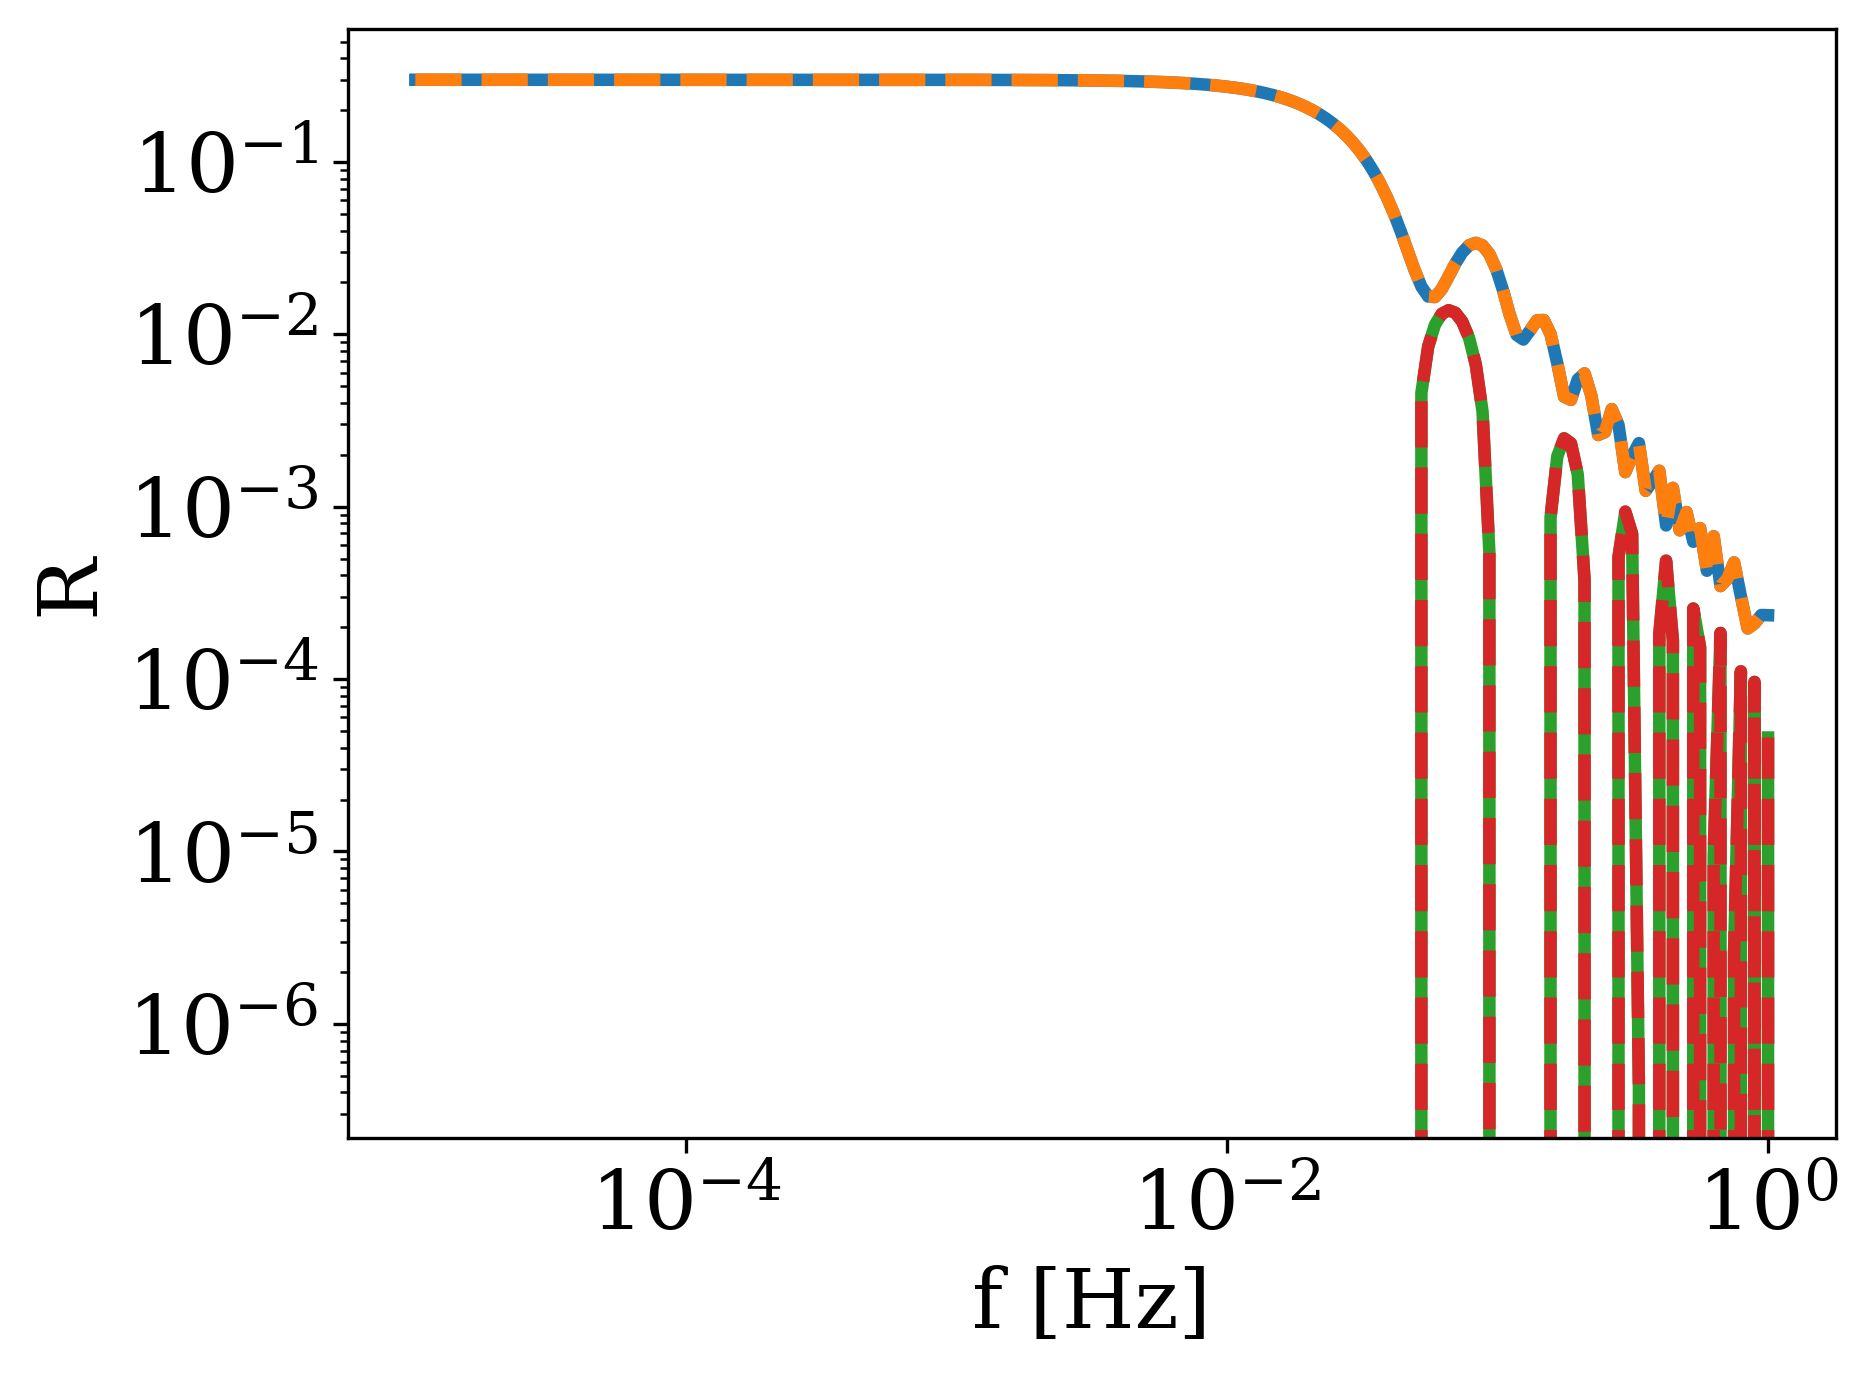

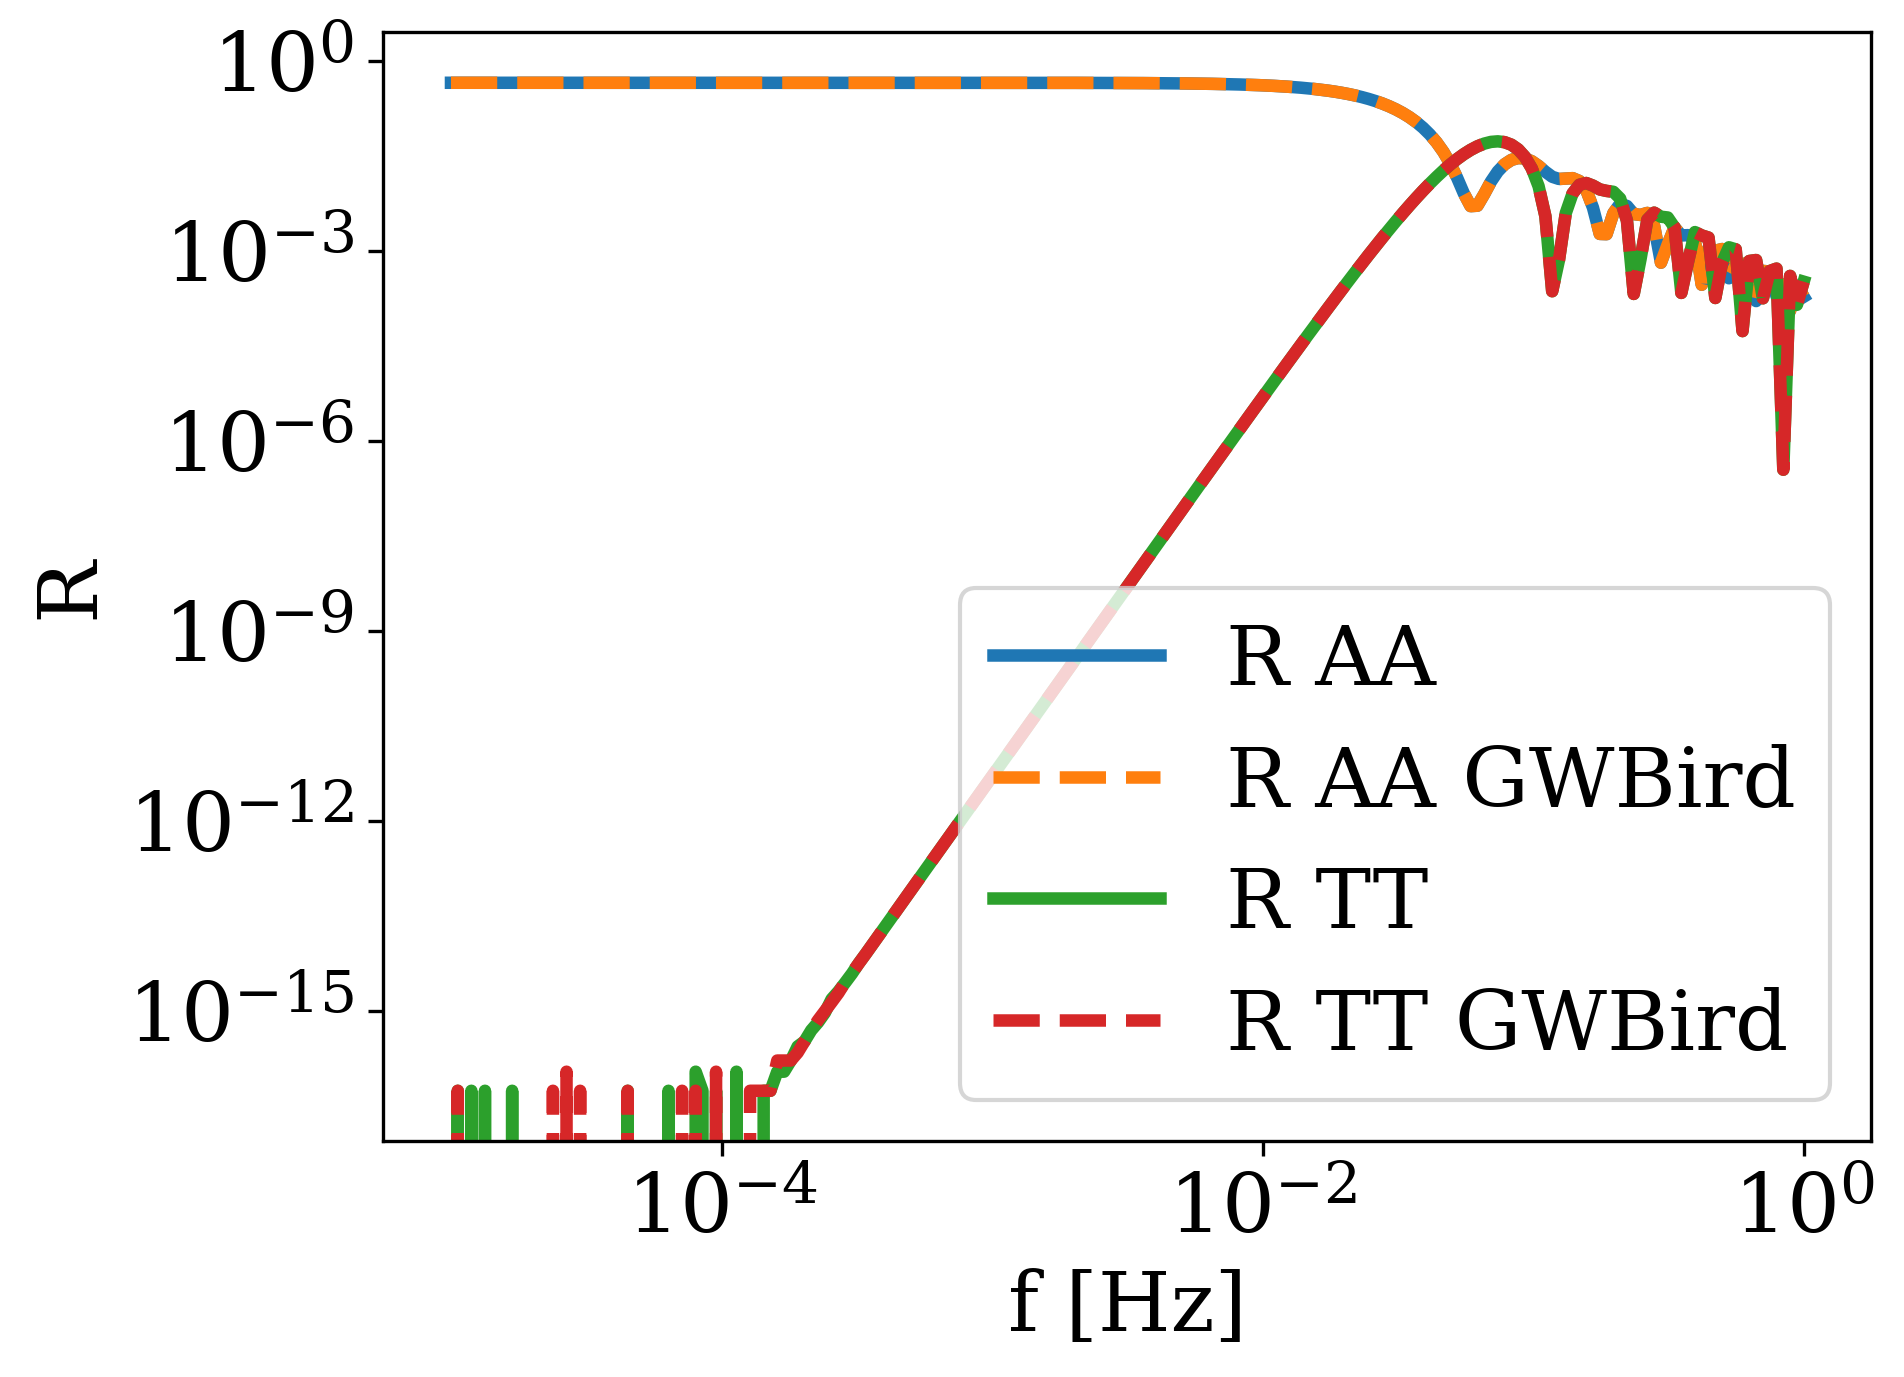

In [27]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

print(lBA)
print(lCA)
print(lBC)

lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)

xA_, lA1_, lA2_, L, name = det.detector('LISA 1', None)
xB_, lB1_, lB2_, L, name = det.detector('LISA 2', None)

print(lA1_)
print(lA2_)
print(lB1_)
1

L = 2.5e9

f_vec = np.logspace(-5,0,200)

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)
# R1_GWBird = 2/5*nell.Rlm_transfer(0,0, lA1_, lA2_, xA_, lA1_, lA2_, xA_, 0, f_vec, 't', L)
# R2_GWBird = 2/5*nell.Rlm_transfer(0,0, lA1_, lA2_, xA_, lB1_, lB2_, xB_, 0, f_vec, 't', L)
R1_GWBird = 2/5*nell.Rlm_transfer(0,0, lBA, lCA, xA_, lBA, lCA, xA_, 0, f_vec, 't', L)
R2_GWBird = 2/5*nell.Rlm_transfer(0,0, lA1_, lA2_, xA, lB1_, lB2_, xB, 0, f_vec, 't', L)

plt.plot(f_vec, R1_vec)
plt.plot(f_vec, R1_GWBird, linestyle='--')
plt.plot(f_vec, R2_vec)
plt.plot(f_vec, R2_GWBird, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.show()

plt.plot(f_vec, R1_vec - R2_vec, label='R AA')
plt.plot(f_vec, R1_GWBird - R2_GWBird, linestyle='--', label='R AA GWBird')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.legend()

plt.plot(f_vec, R1_vec + 2*R2_vec, label='R TT')
plt.plot(f_vec, R1_GWBird + 2*R2_GWBird, linestyle='--', label='R TT GWBird')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.legend()

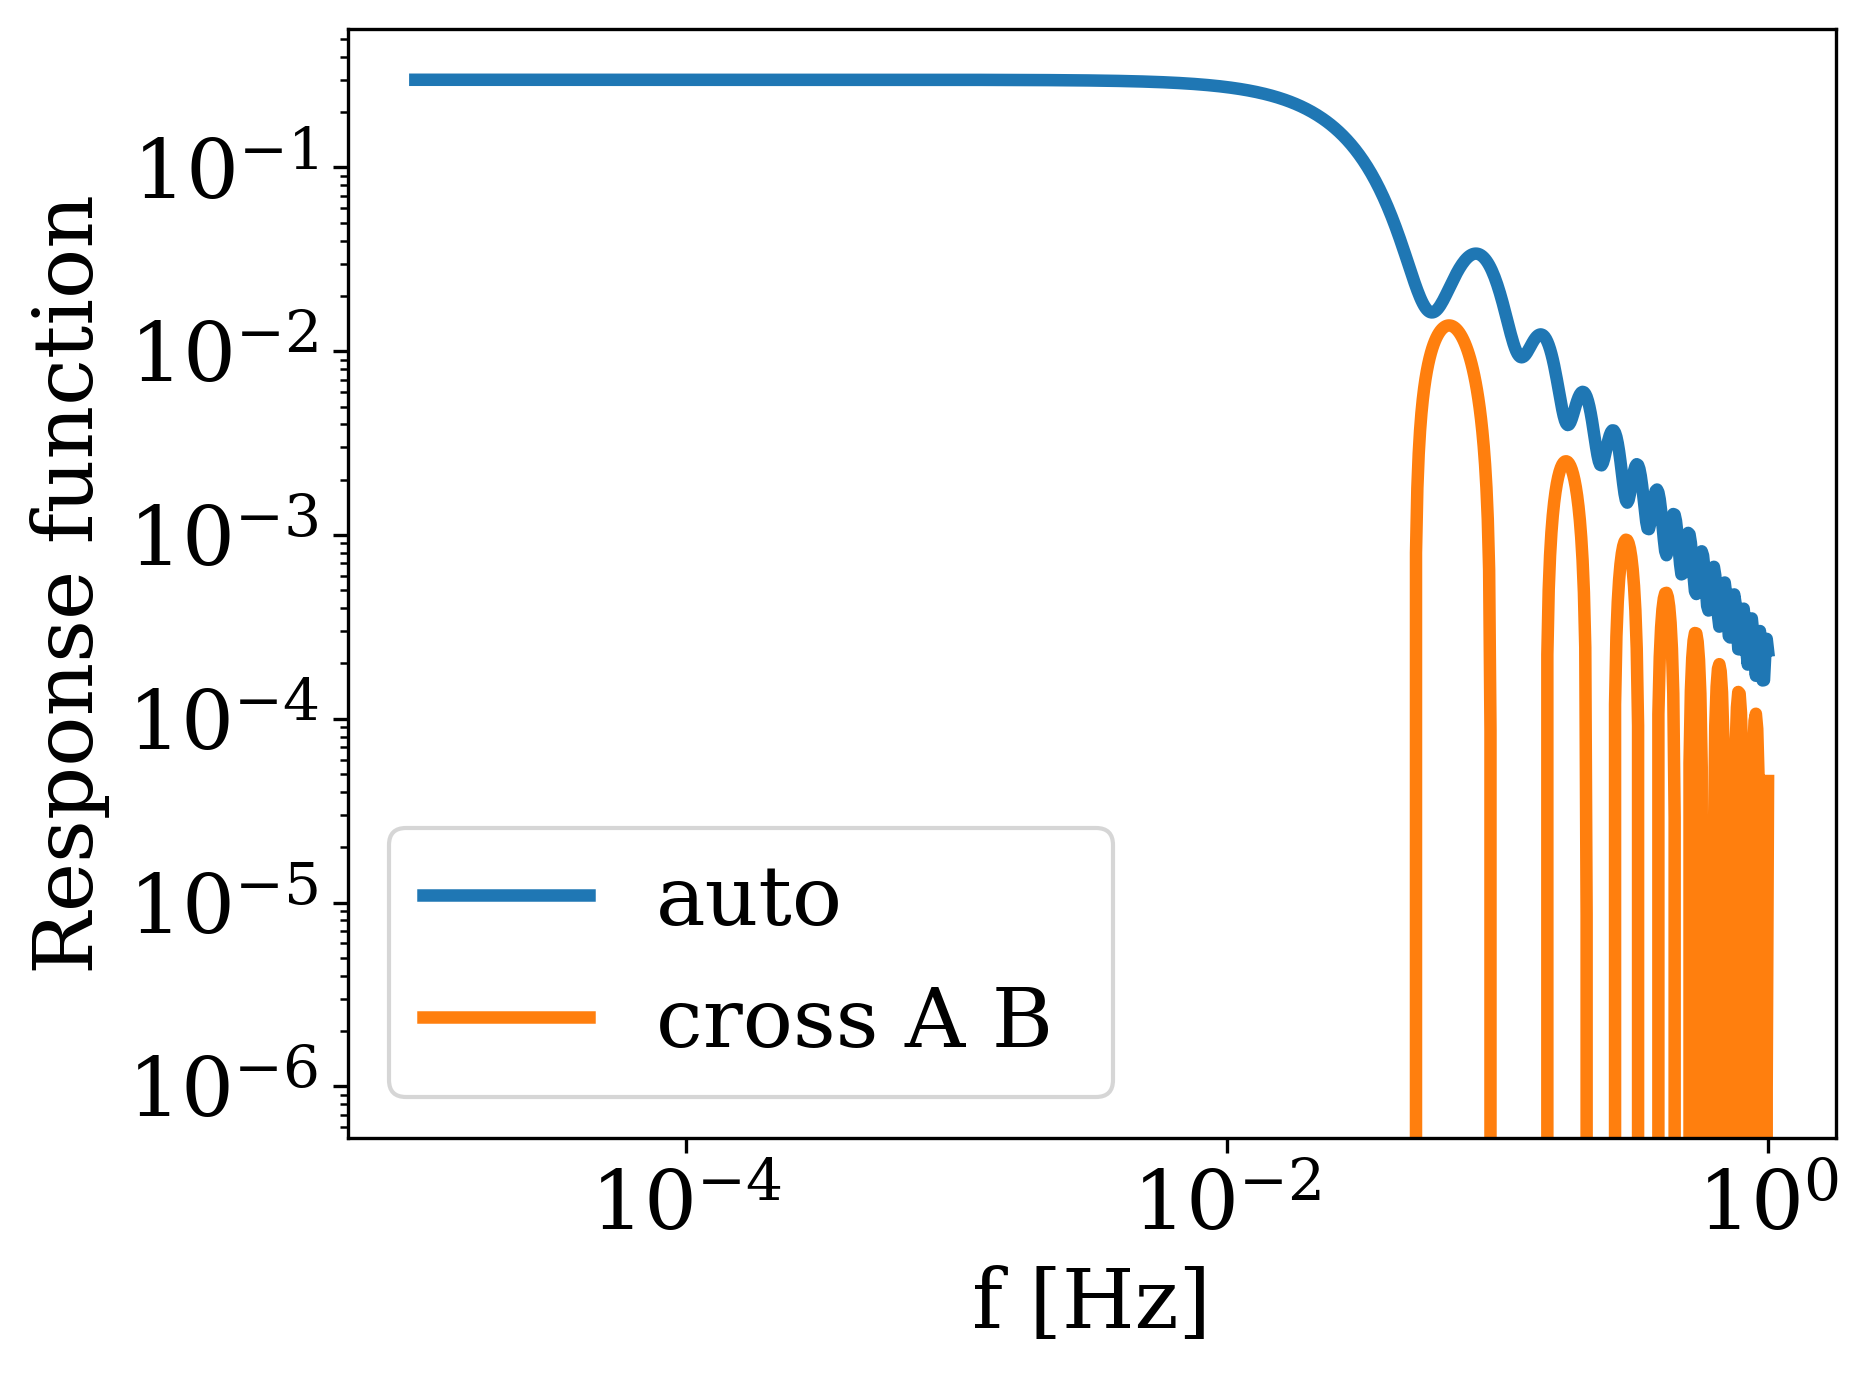

In [268]:
L = 2.5e9 # [m]
c = 3e8 # [m/s]
f_star = c/2/np.pi/L # [Hz]
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
f_vec = np.logspace(-5, 0, 1000)
R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

plt.loglog(f_vec, R1_vec, label='auto')
plt.loglog(f_vec, R2_vec, label='cross A B ')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.legend()


In [269]:
def Ylm(l,m,theta,phi):
    return spherharm(l,m,theta,phi)


In [270]:
Ylm(-2,2,0.1,0.1)

mpc(real='0.0', imag='0.0')

In [323]:
from scipy.special import sph_harm

def Ylm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)

def Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand_ell = (F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)) * Ylm(ell,m,Theta_mesh,Phi_mesh)*np.sqrt(4*np.pi)  #SPHERICAL HARMONIC redefined according to Eq. 4.2 paper LISA anisotropies
    R1 = np.trapz(R_integrand_ell,Phi_vec,axis=1)
    Rellm = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))/4/np.pi
    #Rellm = np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1)/4/np.pi
    return Rellm

In [324]:
# Verify the normalization
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

In [273]:
f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec_ell = Response_ell(lA,lA,xA,xA,f_vec,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f_vec,f_star, 0, 0)

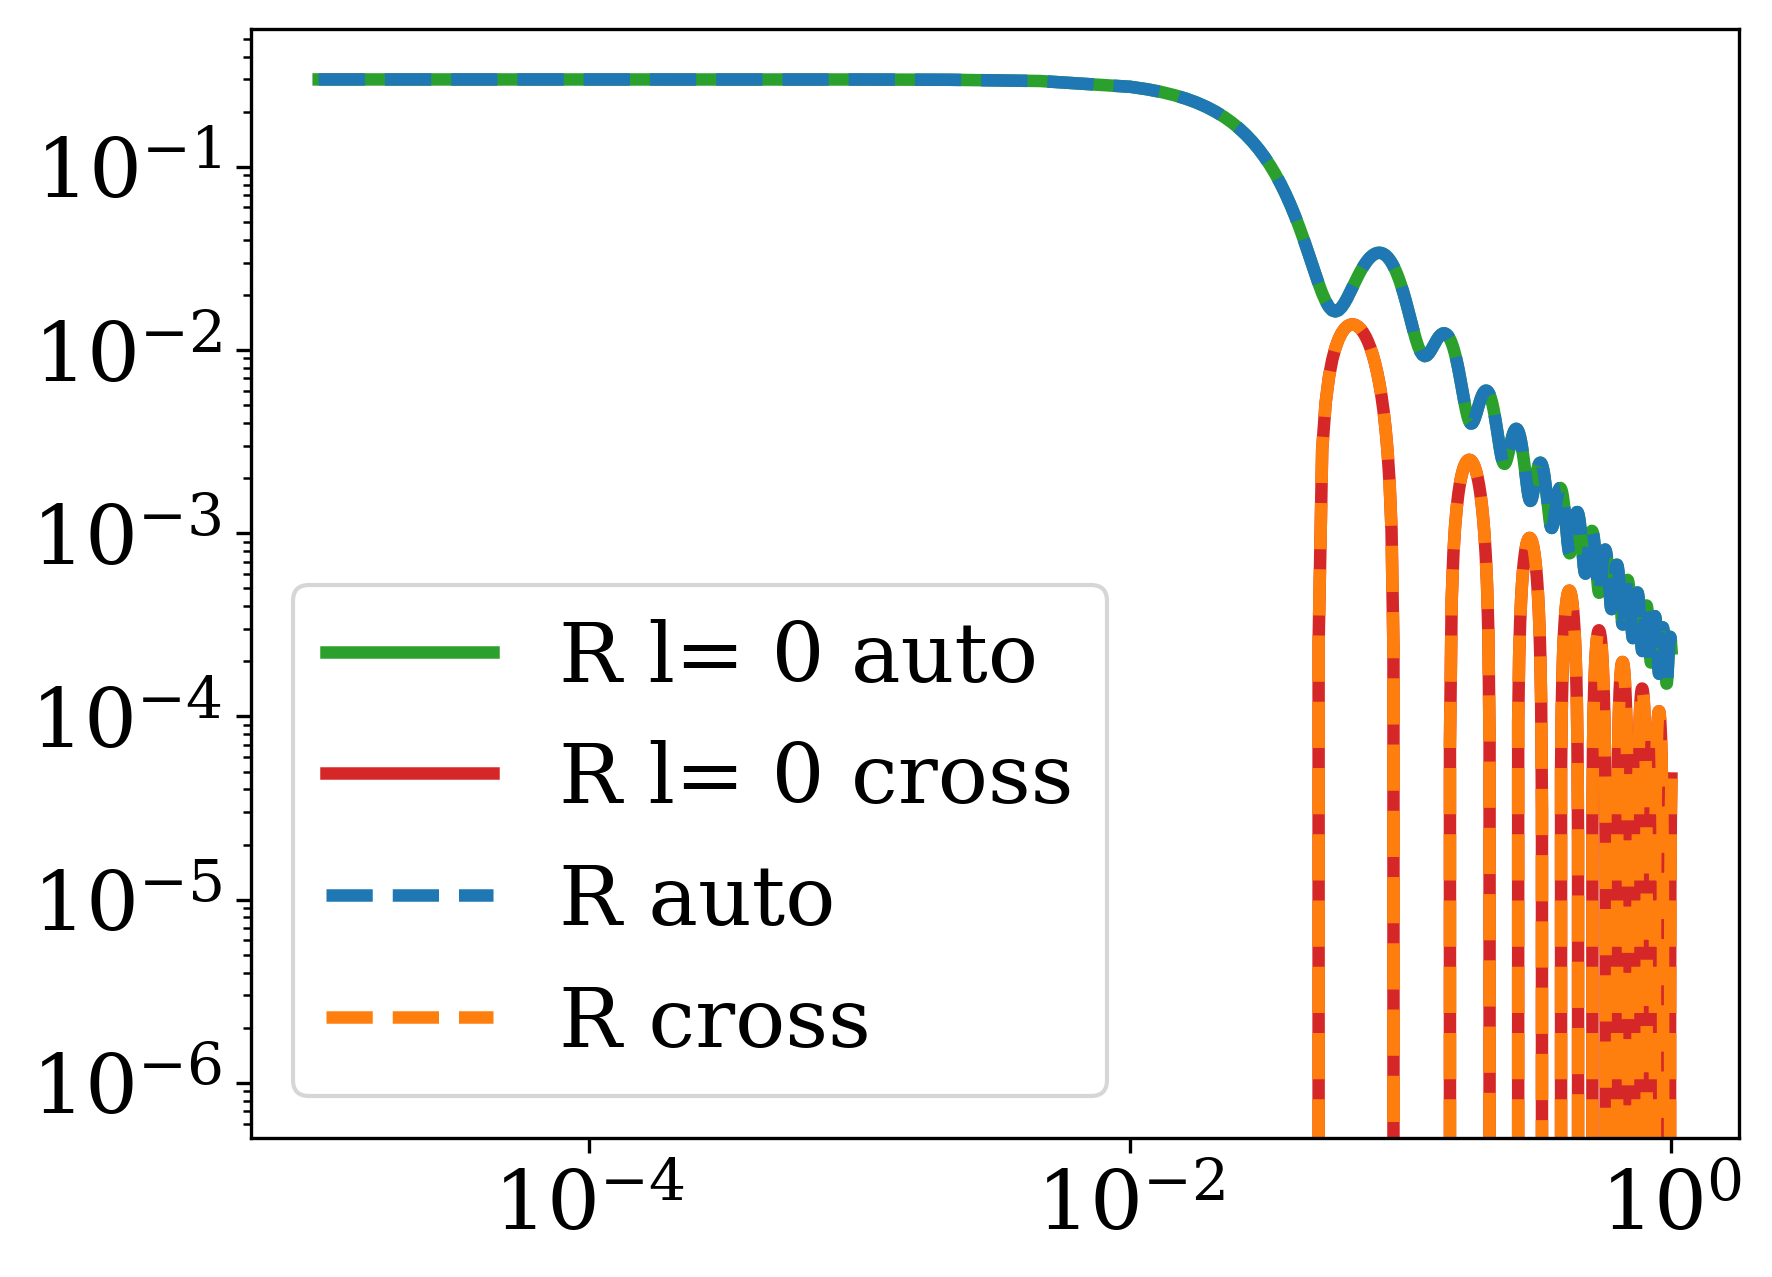

In [274]:
plt.loglog(f_vec,(R1_vec_ell),label='R l= 0 auto',c='C2')
plt.loglog(f_vec,(R2_vec_ell),label='R l= 0 cross',c='C3')
plt.loglog(f_vec,R1_vec,label='R auto',linestyle='--')
plt.loglog(f_vec,R2_vec,label='R cross',linestyle='--')
plt.legend()

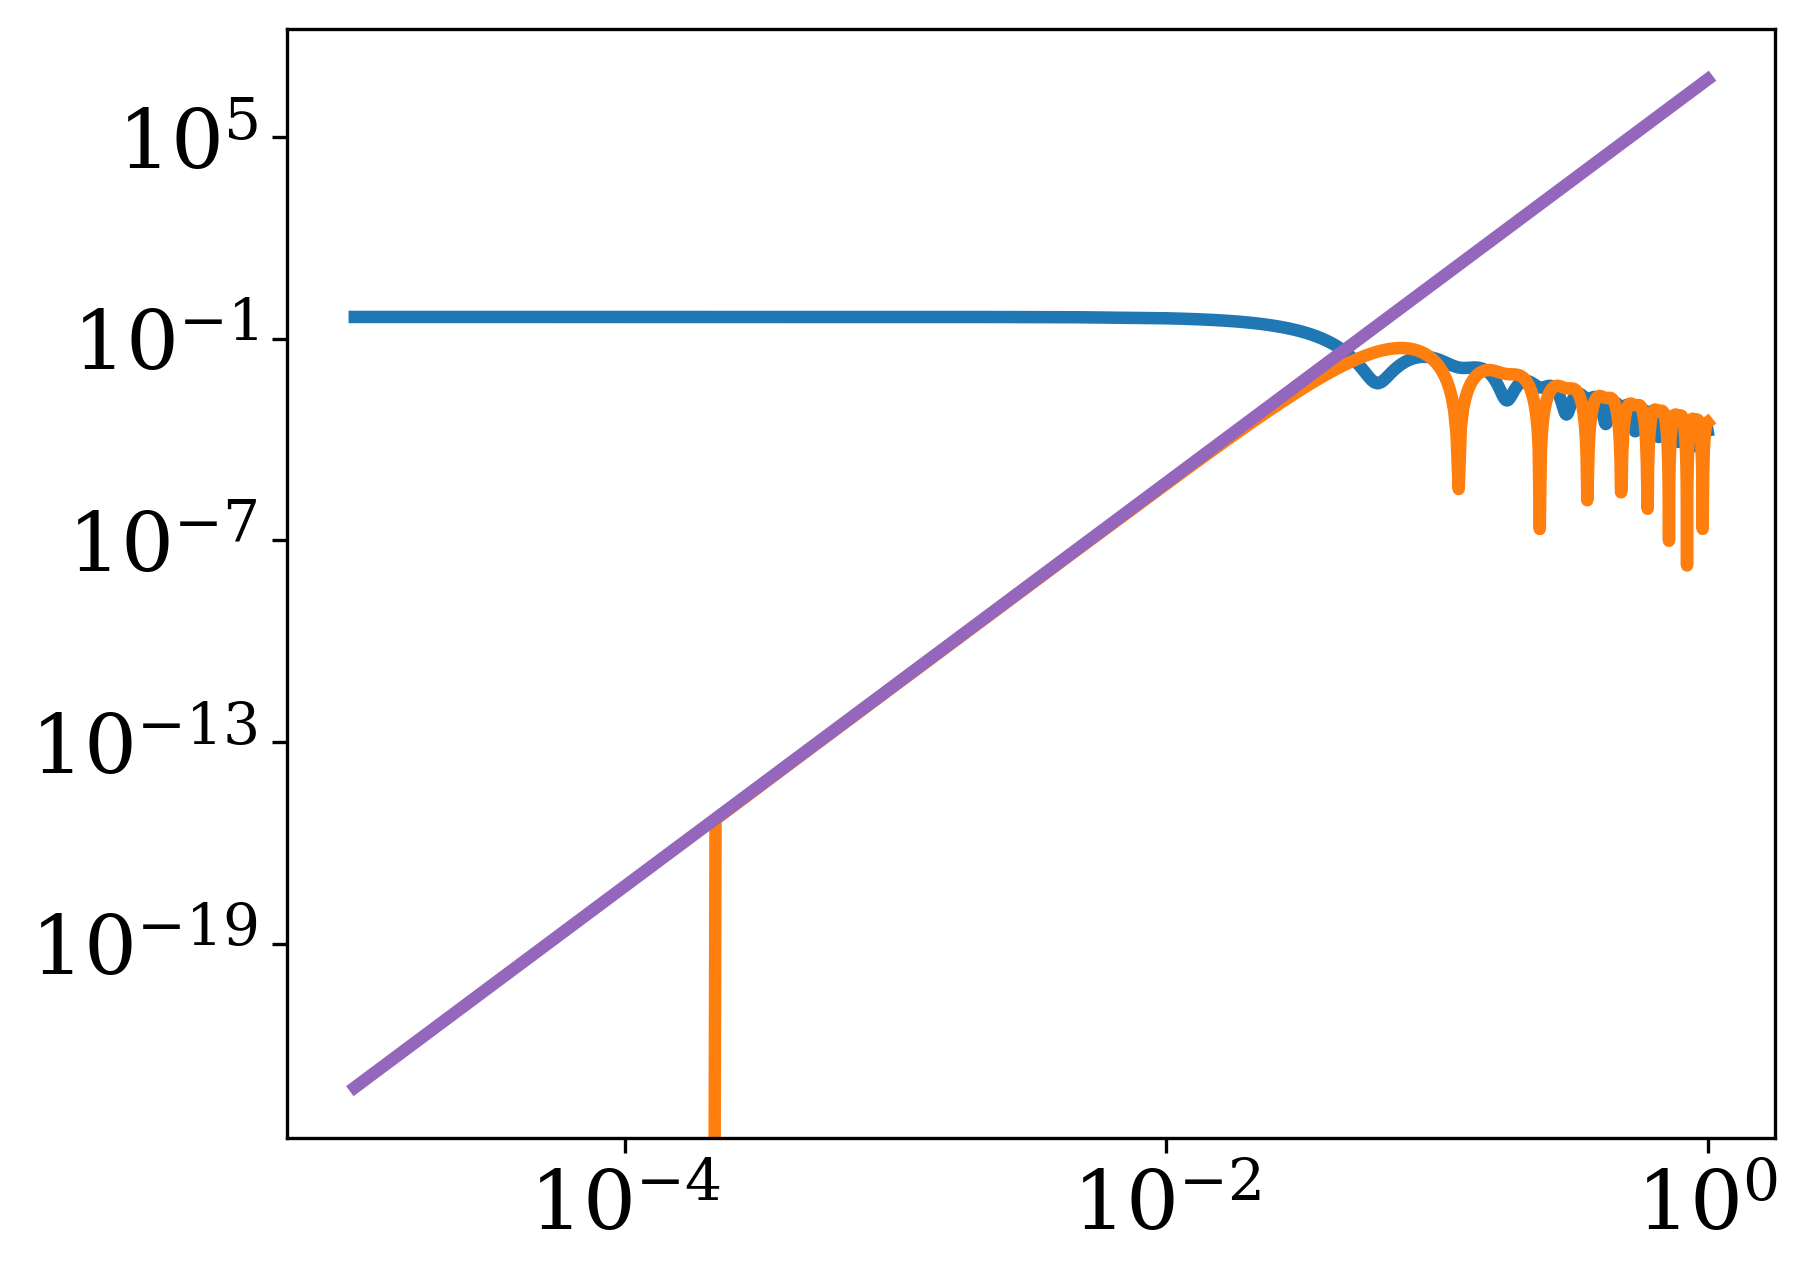

In [275]:
RAAell = R1_vec_ell - R2_vec_ell

RTT0 = R1_vec_ell + 2* R2_vec_ell

f = np.logspace(-5, 0, 100)
f_star = 0.019 # Hz
x = f/f_star
LISA_Rell_0_TT_interpolated = x**6/4032

plt.loglog(f_vec,(RAAell),label='RAA',c='C0')
plt.loglog(f_vec,(RTT0),label='RTT0',c='C1')
plt.loglog(f,LISA_Rell_0_TT_interpolated,label='LISA Rell 0 TT',c='C4')



In [276]:
def sum_m(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    m = np.linspace(-ell,ell,2*ell+1)
    Rell = np.zeros_like(f_vec,dtype=complex)
    #Rell = np.zeros_like(f_vec)
    for i in range(len(m)):
        R = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])
        #R2 = np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
        Rstar = np.conj(R)
        Rell += R*Rstar
        #Rell += R2
    return np.sqrt(Rell)

In [277]:
def sum_m_AET(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    mvec = np.linspace(-ell,ell,2*ell+1)
    RlAA = np.zeros_like(f_vec,dtype=complex)
    RlTT = np.zeros_like(f_vec,dtype=complex)
    RlAE = np.zeros_like(f_vec,dtype=complex)
    RlAT = np.zeros_like(f_vec,dtype=complex)
    if int(ell)% 2 == 0:
        for m in mvec:
            R1 = Response_ell(l_det1,l_det1,x_det1,x_det1,f_vec,f_star,ell,m)
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            #RAA = 1/4*np.abs(1+np.exp(-4/3*1j*m[i]*np.pi)*(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])))
            #RAE = 1/3*(1+2*np.cos(2*m[i]*np.pi/3))**2*np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
            RlAA += np.abs((1+np.exp(-4j/3*m*np.pi)) * R1 - 2 * R2)**2
            RlTT += np.abs(R1 + 2*R2)**2*(1+2*np.cos(2*m*np.pi/3))**2 
            RlAE += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 - 2 * R2)**2
            RlAT += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 + R2)**2
            #Rell_rot += RAE
    else:  
        for m in mvec:
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            RlAE += (1+2*np.cos(2*m*np.pi/3))**2 * np.abs(R2)**2
            RlAT += (np.sin(m*np.pi/3)**2 * np.abs(R2)**2)*3
    return np.sqrt(np.real(RlAA)/4), np.sqrt(np.real(RlTT)/9), np.sqrt(np.real(RlAE)/3), np.sqrt(2*np.real(RlAT)/3)

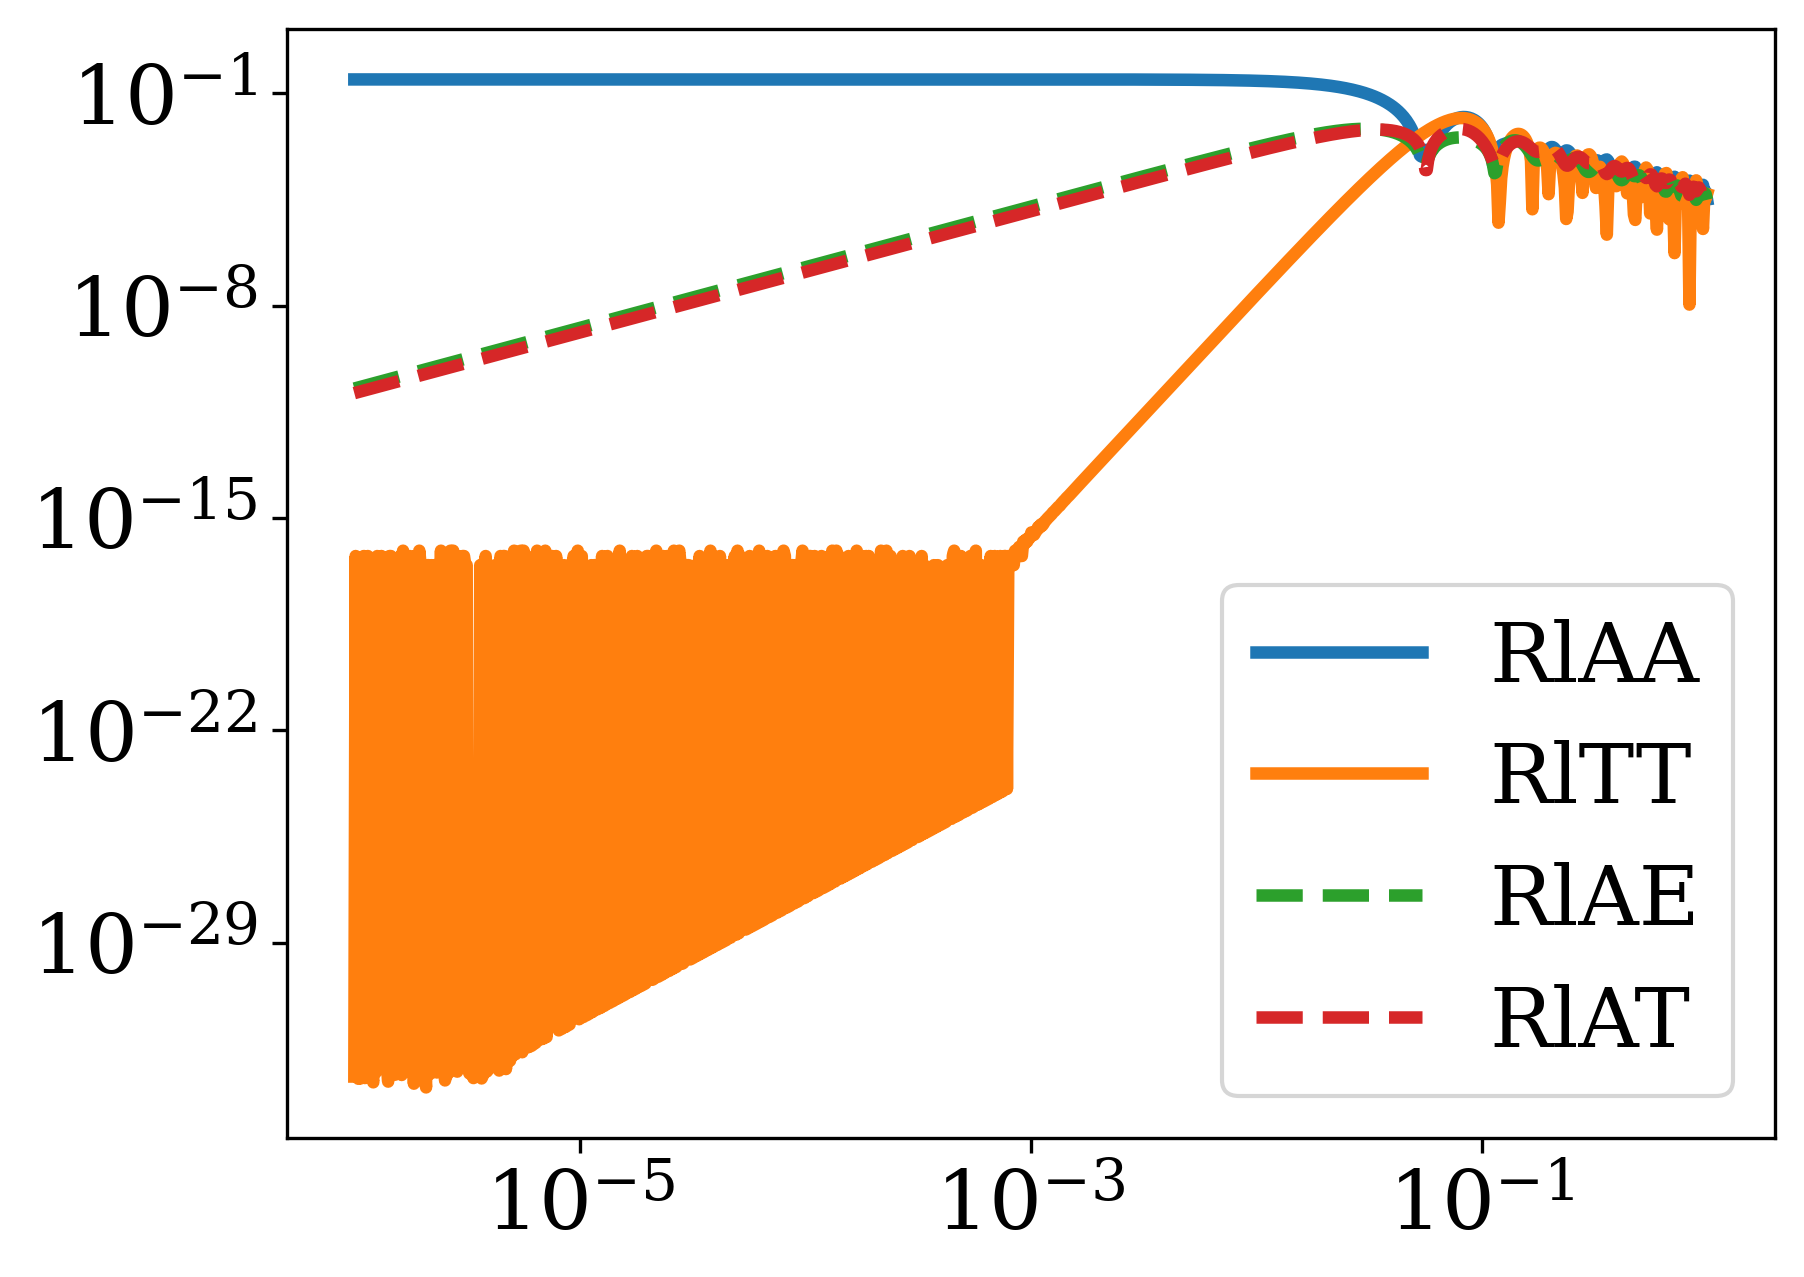

In [278]:
f = np.logspace(-6, 0, 1000)
R = sum_m_AET(lA,lB,xA,xB, f,f_star,2)

plt.loglog(f, R[0],label='RlAA',c='C0')
plt.loglog(f,R[1],label='RlTT',c='C1')
plt.loglog(f,R[2],label='RlAE',c='C2', linestyle='--')
plt.loglog(f,R[3],label='RlAT',c='C3', linestyle='--')
plt.legend()


# plt.loglog(f_vec, R[2],label='RAA',c='C0')
# plt.ylim(1e-5,1e0)

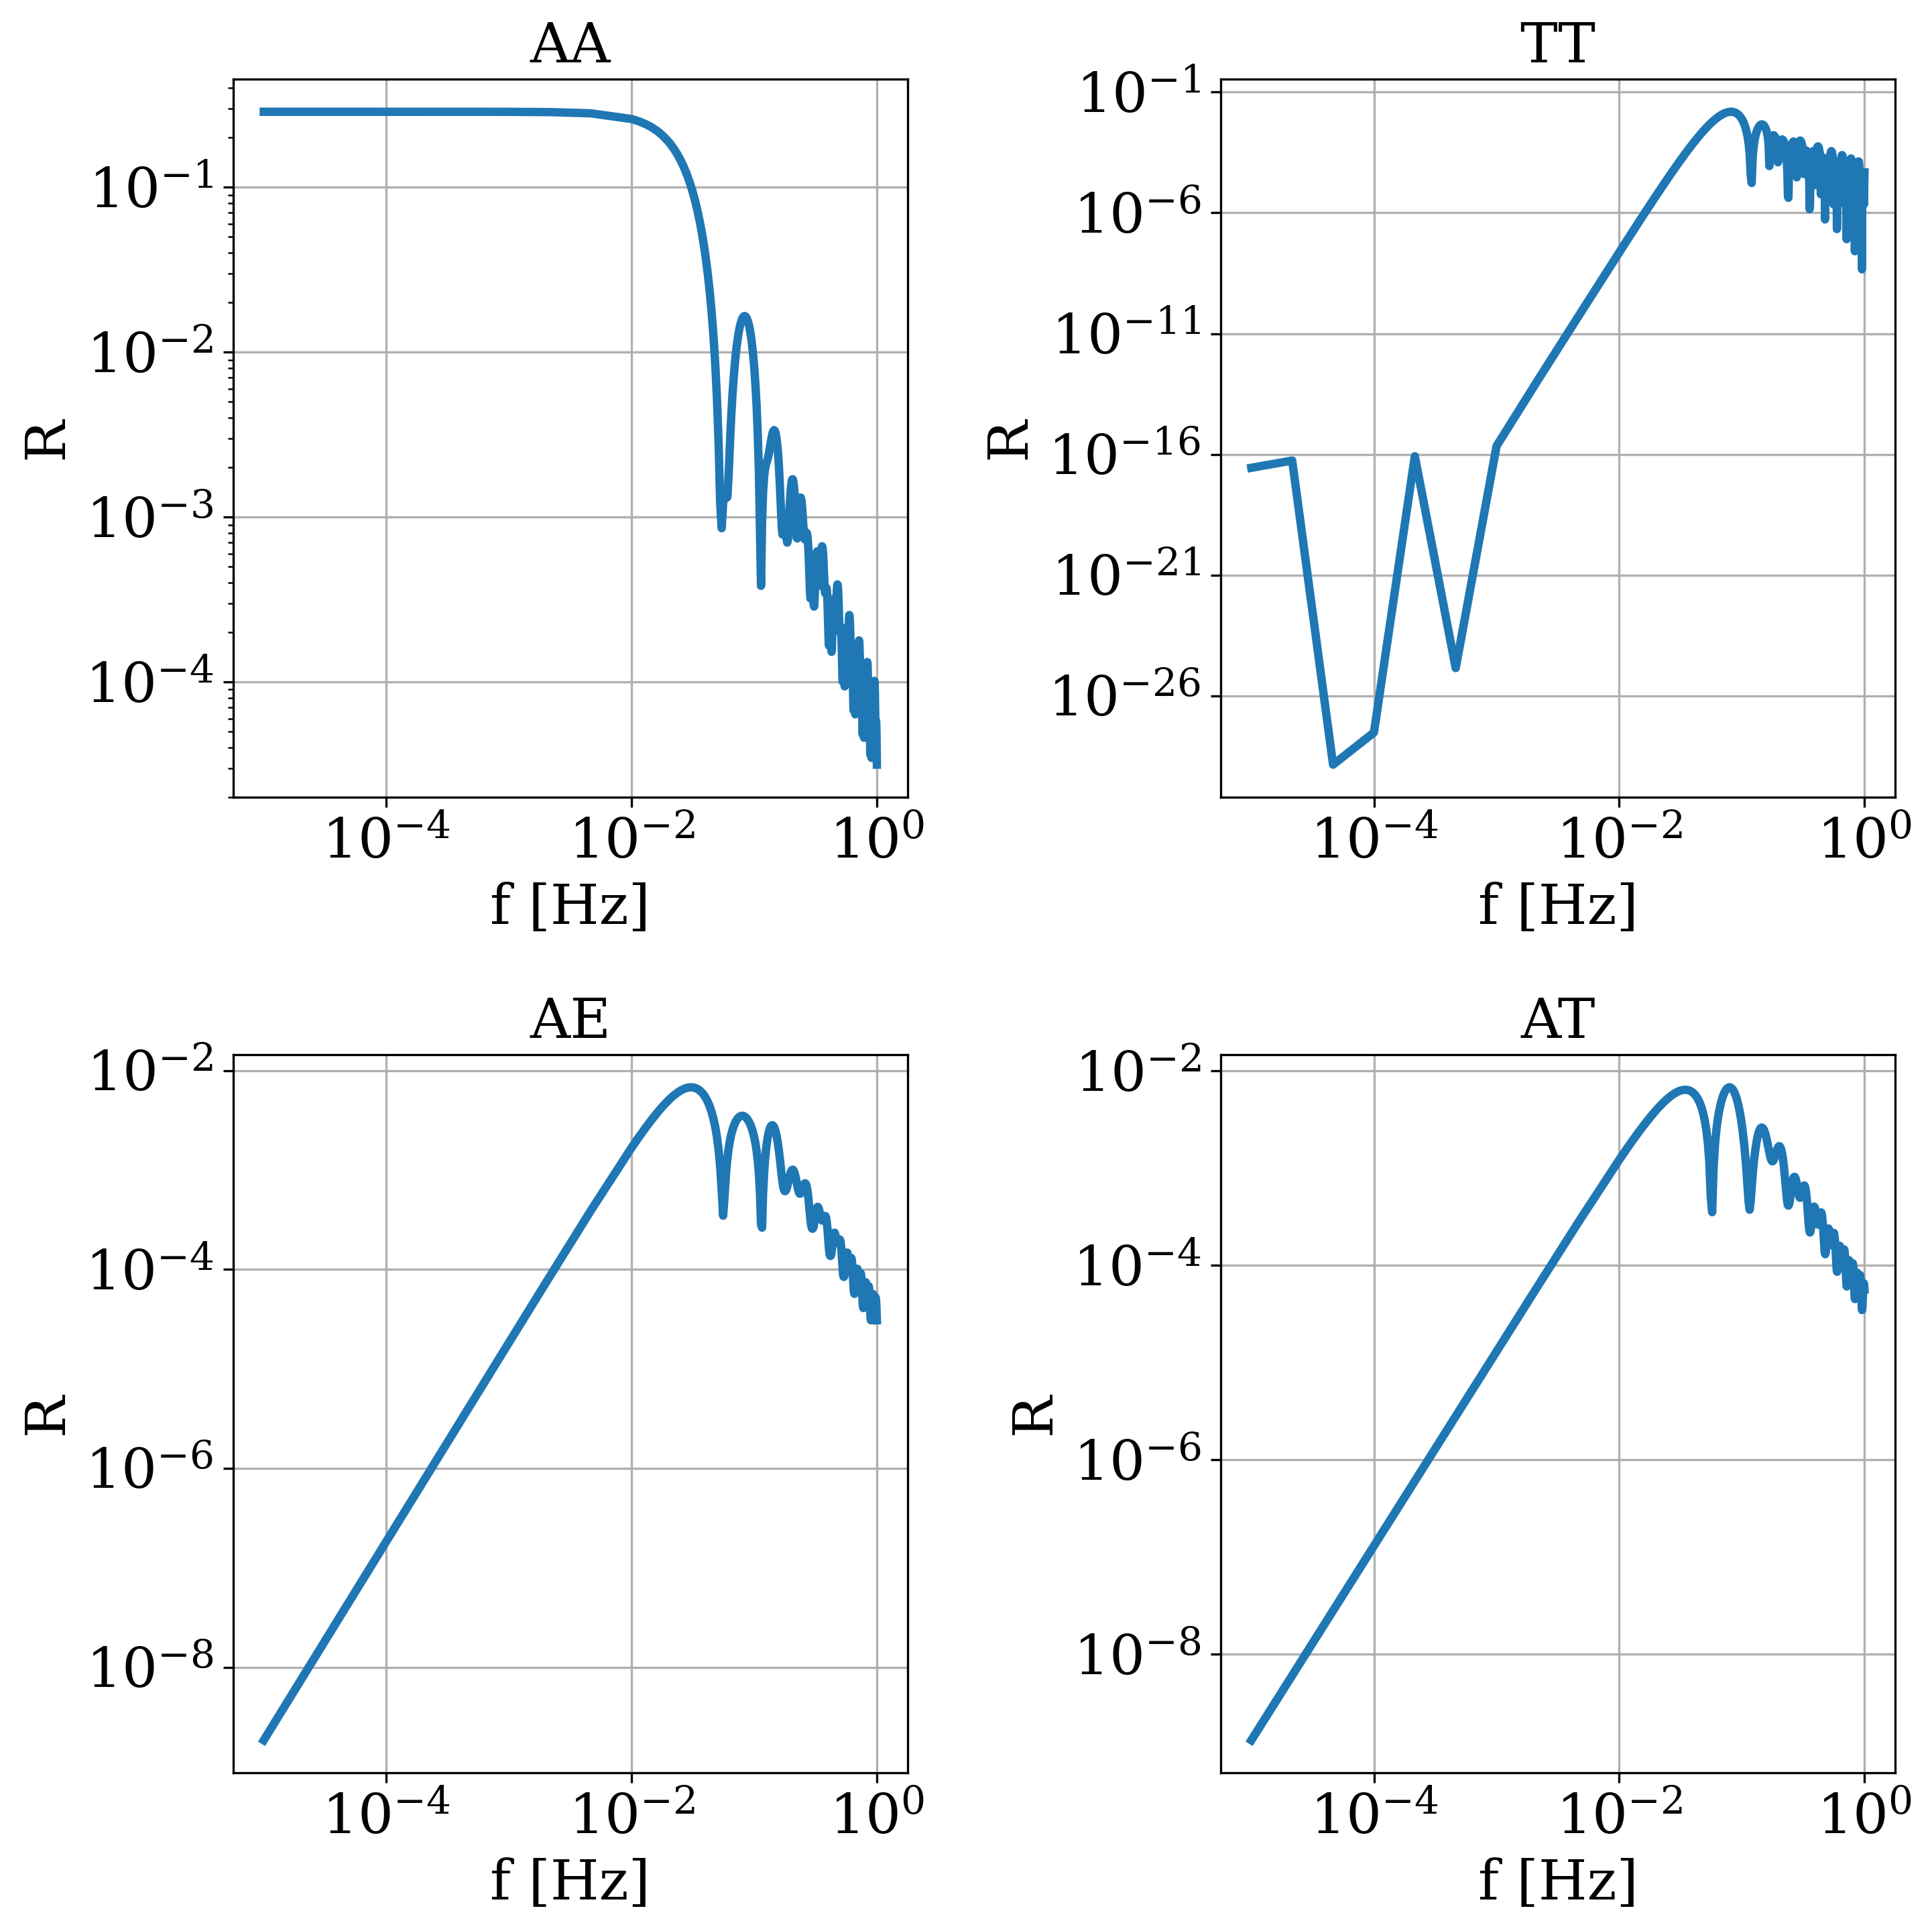

In [279]:
#f_vec = np.array([1e-3,1e-2])
l_value = 2
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,l_value)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax = axs.flatten()
for i, axis in enumerate(ax):
    # axis.set_xlim(1e-3, 1)
    # axis.set_ylim(1e-7, 1)
    axis.set_title(['AA','TT','AE','AT'][i])
    axis.loglog(f_vec, R[i])
    axis.set_xlabel('f [Hz]')
    axis.set_ylabel('R')
    axis.grid()
plt.tight_layout()
plt.show()

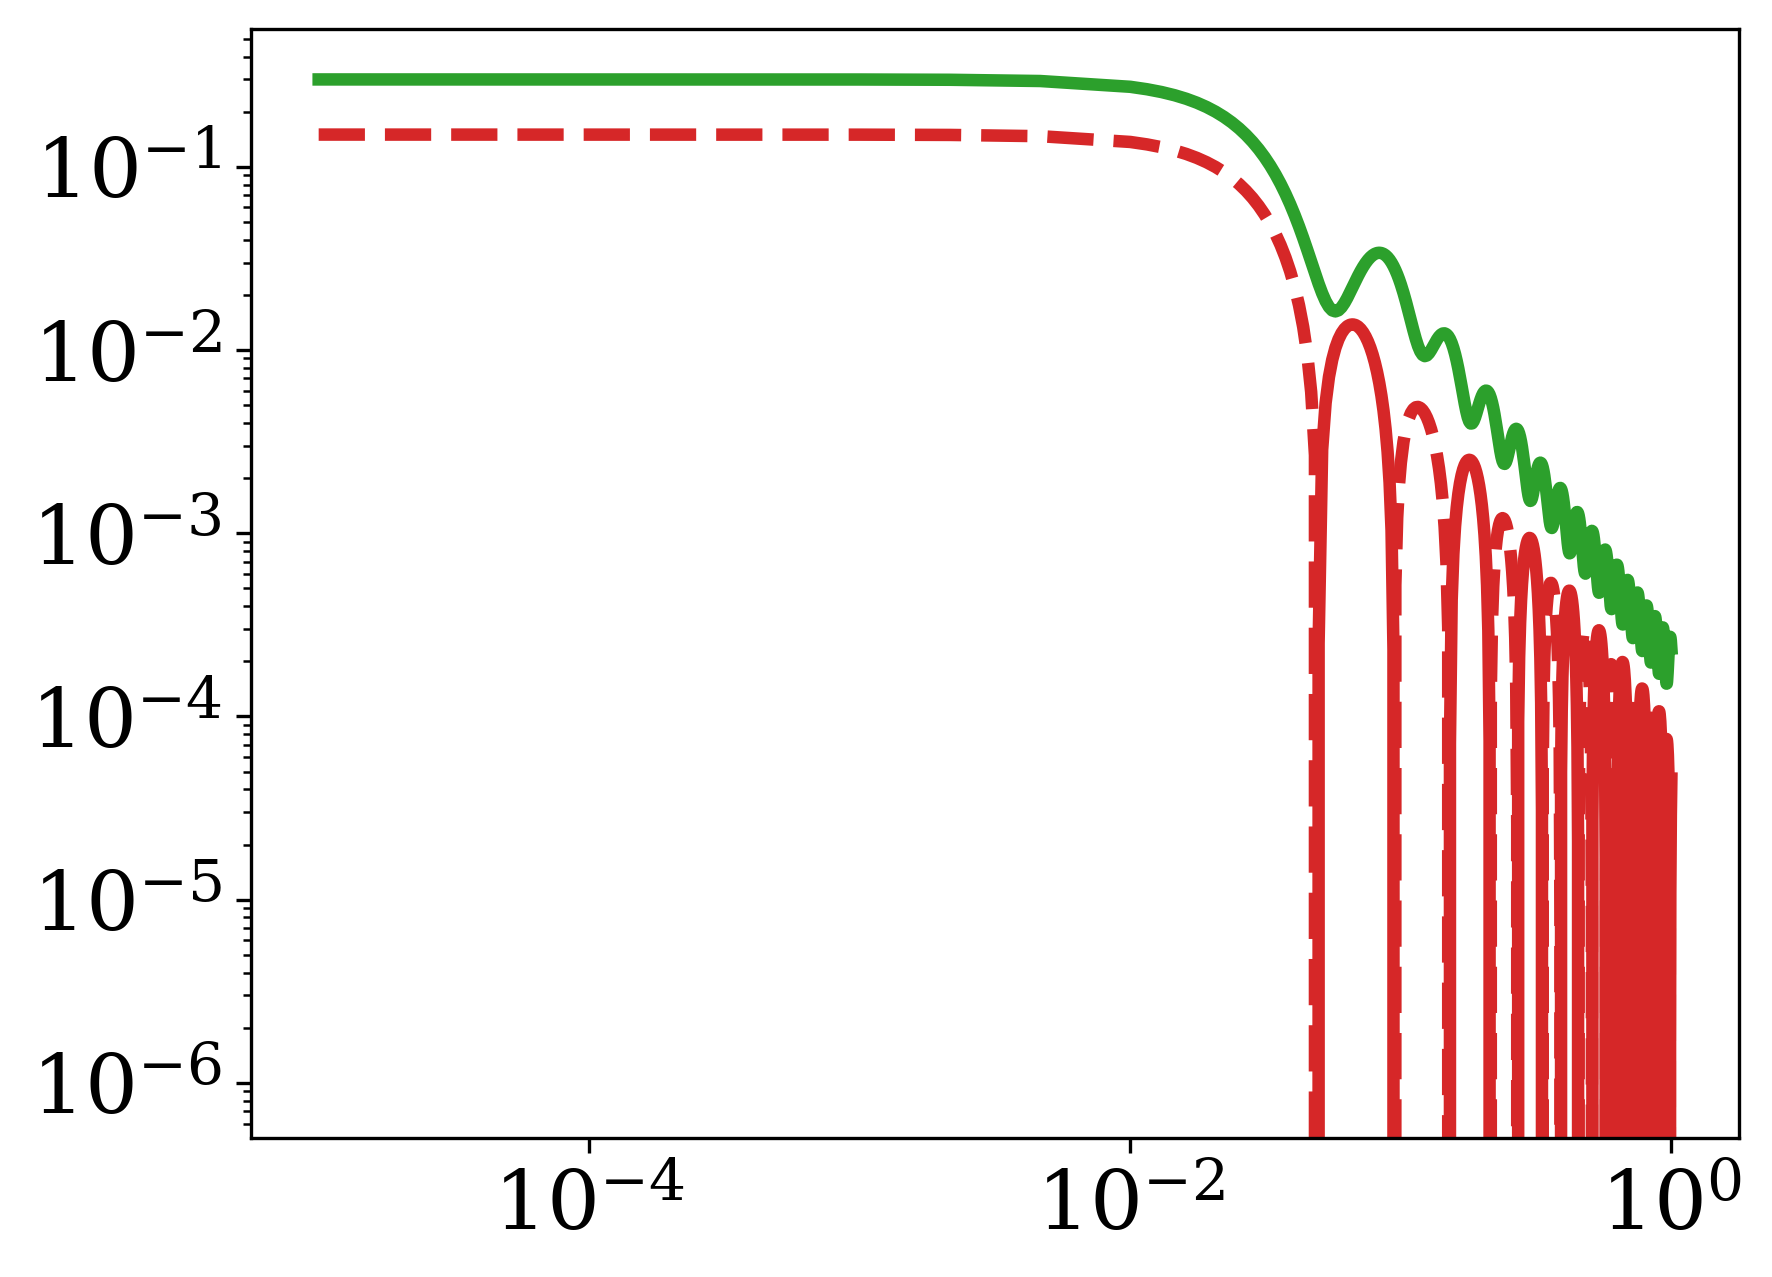

In [280]:
plt.loglog(f_vec,(R1_vec),label='R1',c='C2')
plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

In [28]:
from nest import detectors, overlap,  pls, skymap, nell
import pickle
from tqdm.notebook import tqdm, trange

In [29]:
c1, u1, v1, L, name = detectors.detector('LISA 1', shift_angle=None)
c2, u2, v2, L, name = detectors.detector('LISA 2', shift_angle=None)

f = np.logspace(-5, 0, 200)
R_XX_00 = nell.Rlm_transfer(0, 0, u1, v1, c1, u1, v1, c1, 0, f, 't', L)
R_XY_00 = nell.Rlm_transfer(0, 0, u1, v1, c1, u2, v2, c2, 0, f, 't', L)

R_XX_0 = 2/5 * R_XX_00
R_XY_0 = 2/5 * R_XY_00

0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744


In [30]:
print(R_XX_0[0])
print(R_XY_0[0])
print(R1_vec[0])
print(R2_vec[0])


(0.29993702754754165+3.887314136180325e-22j)
(-0.14996851377377082-9.30366313486197e-21j)
0.2999370275475416
-0.1499685137737708


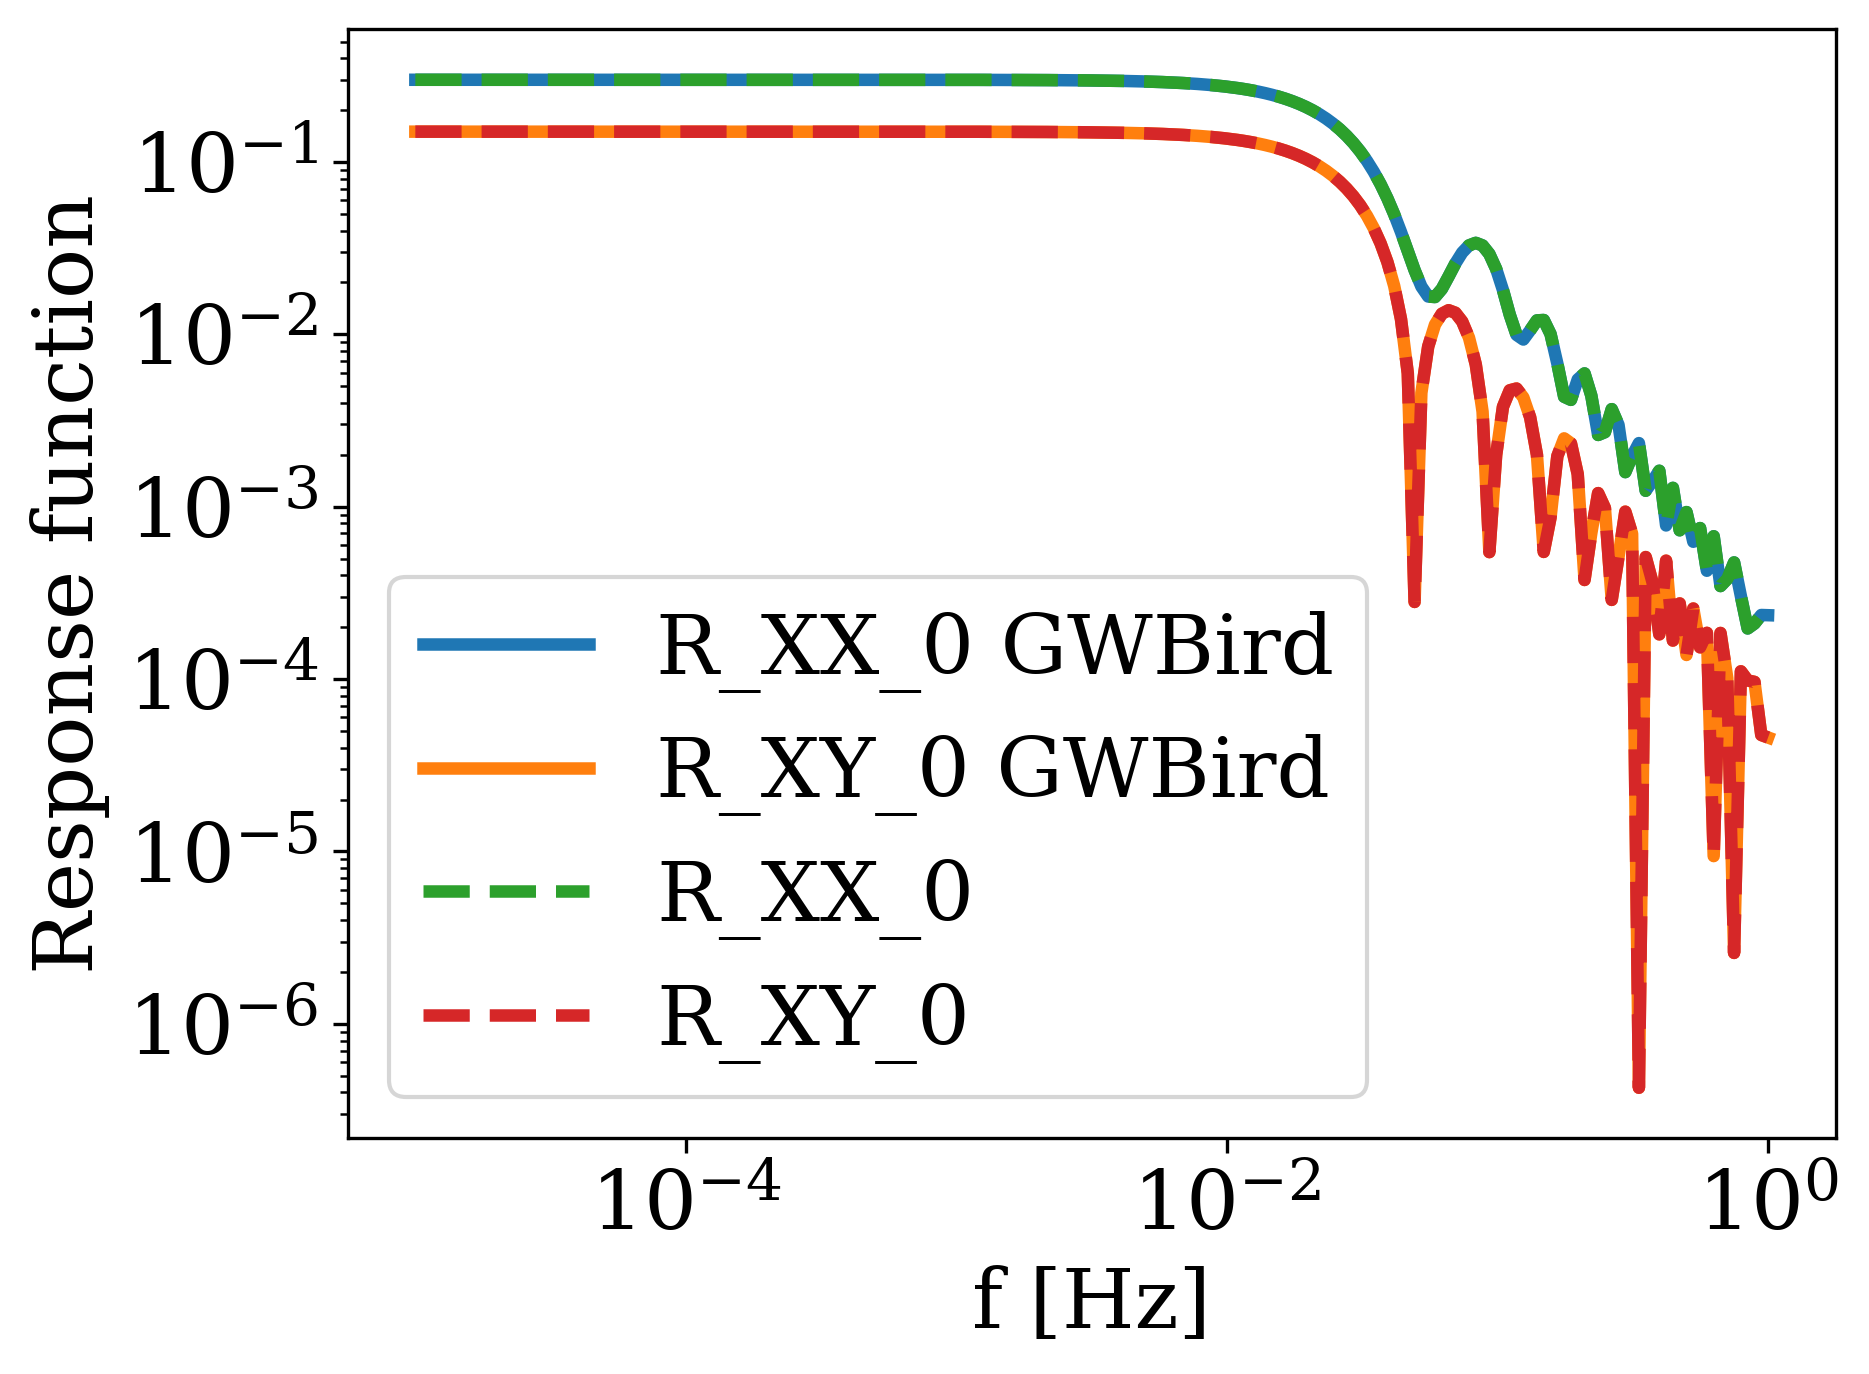

In [31]:
plt.plot(f, R_XX_0, label='R_XX_0 GWBird')
plt.plot(f, np.abs(R_XY_0), label='R_XY_0 GWBird')
plt.plot(f_vec, R1_vec, label='R_XX_0', linestyle='--')
plt.plot(f_vec, np.abs(R2_vec), label='R_XY_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.legend()


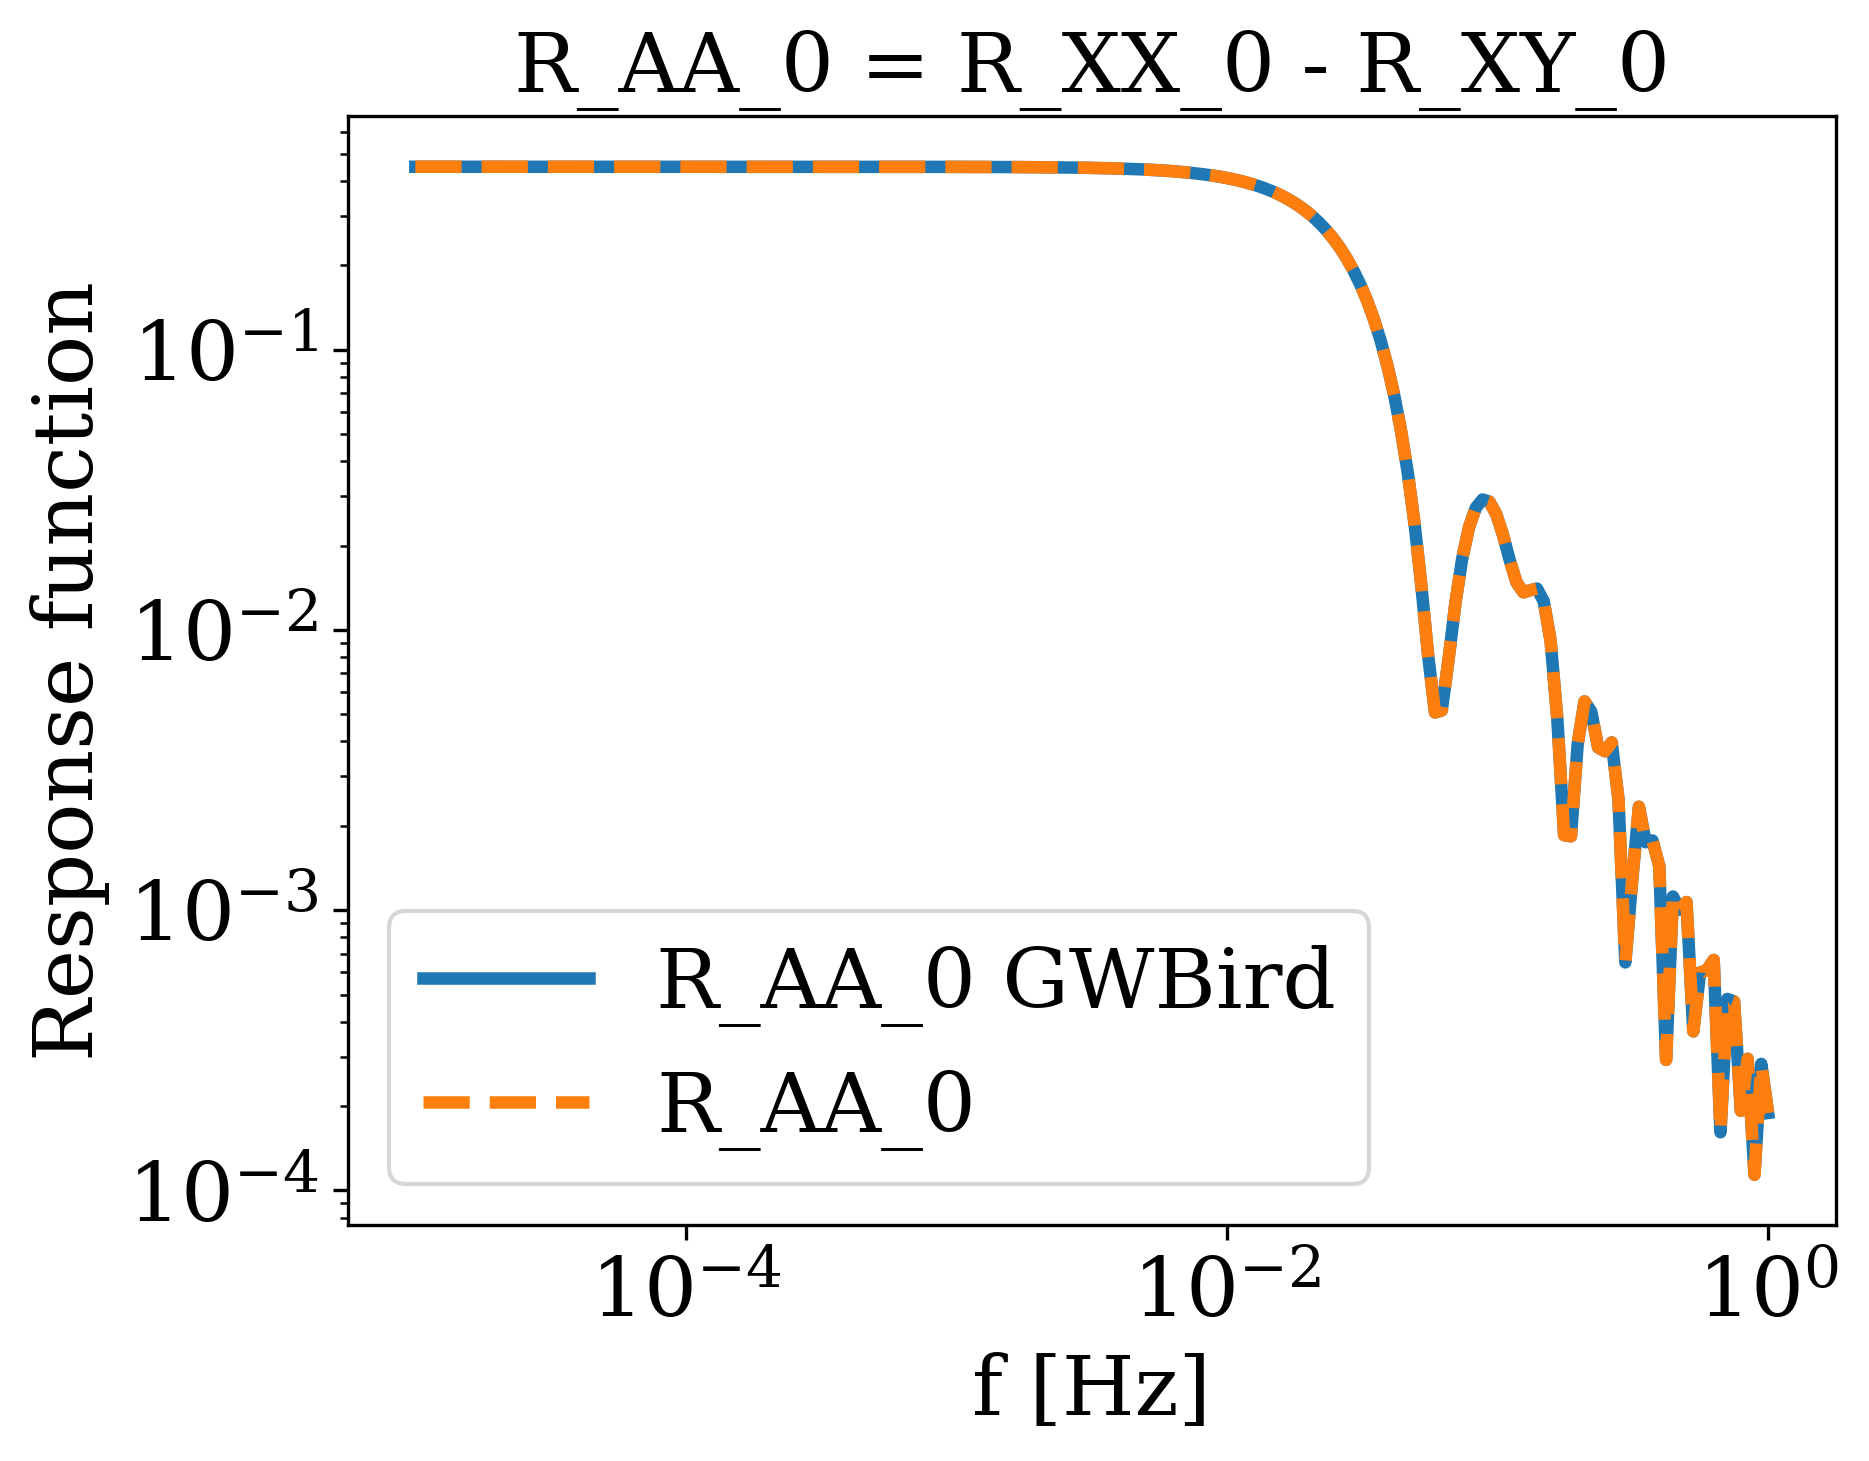

In [32]:
plt.plot(f, R_XX_0 - R_XY_0, label='R_AA_0 GWBird')
plt.plot(f_vec, R1_vec - R2_vec, label='R_AA_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.title('R_AA_0 = R_XX_0 - R_XY_0')
plt.legend()

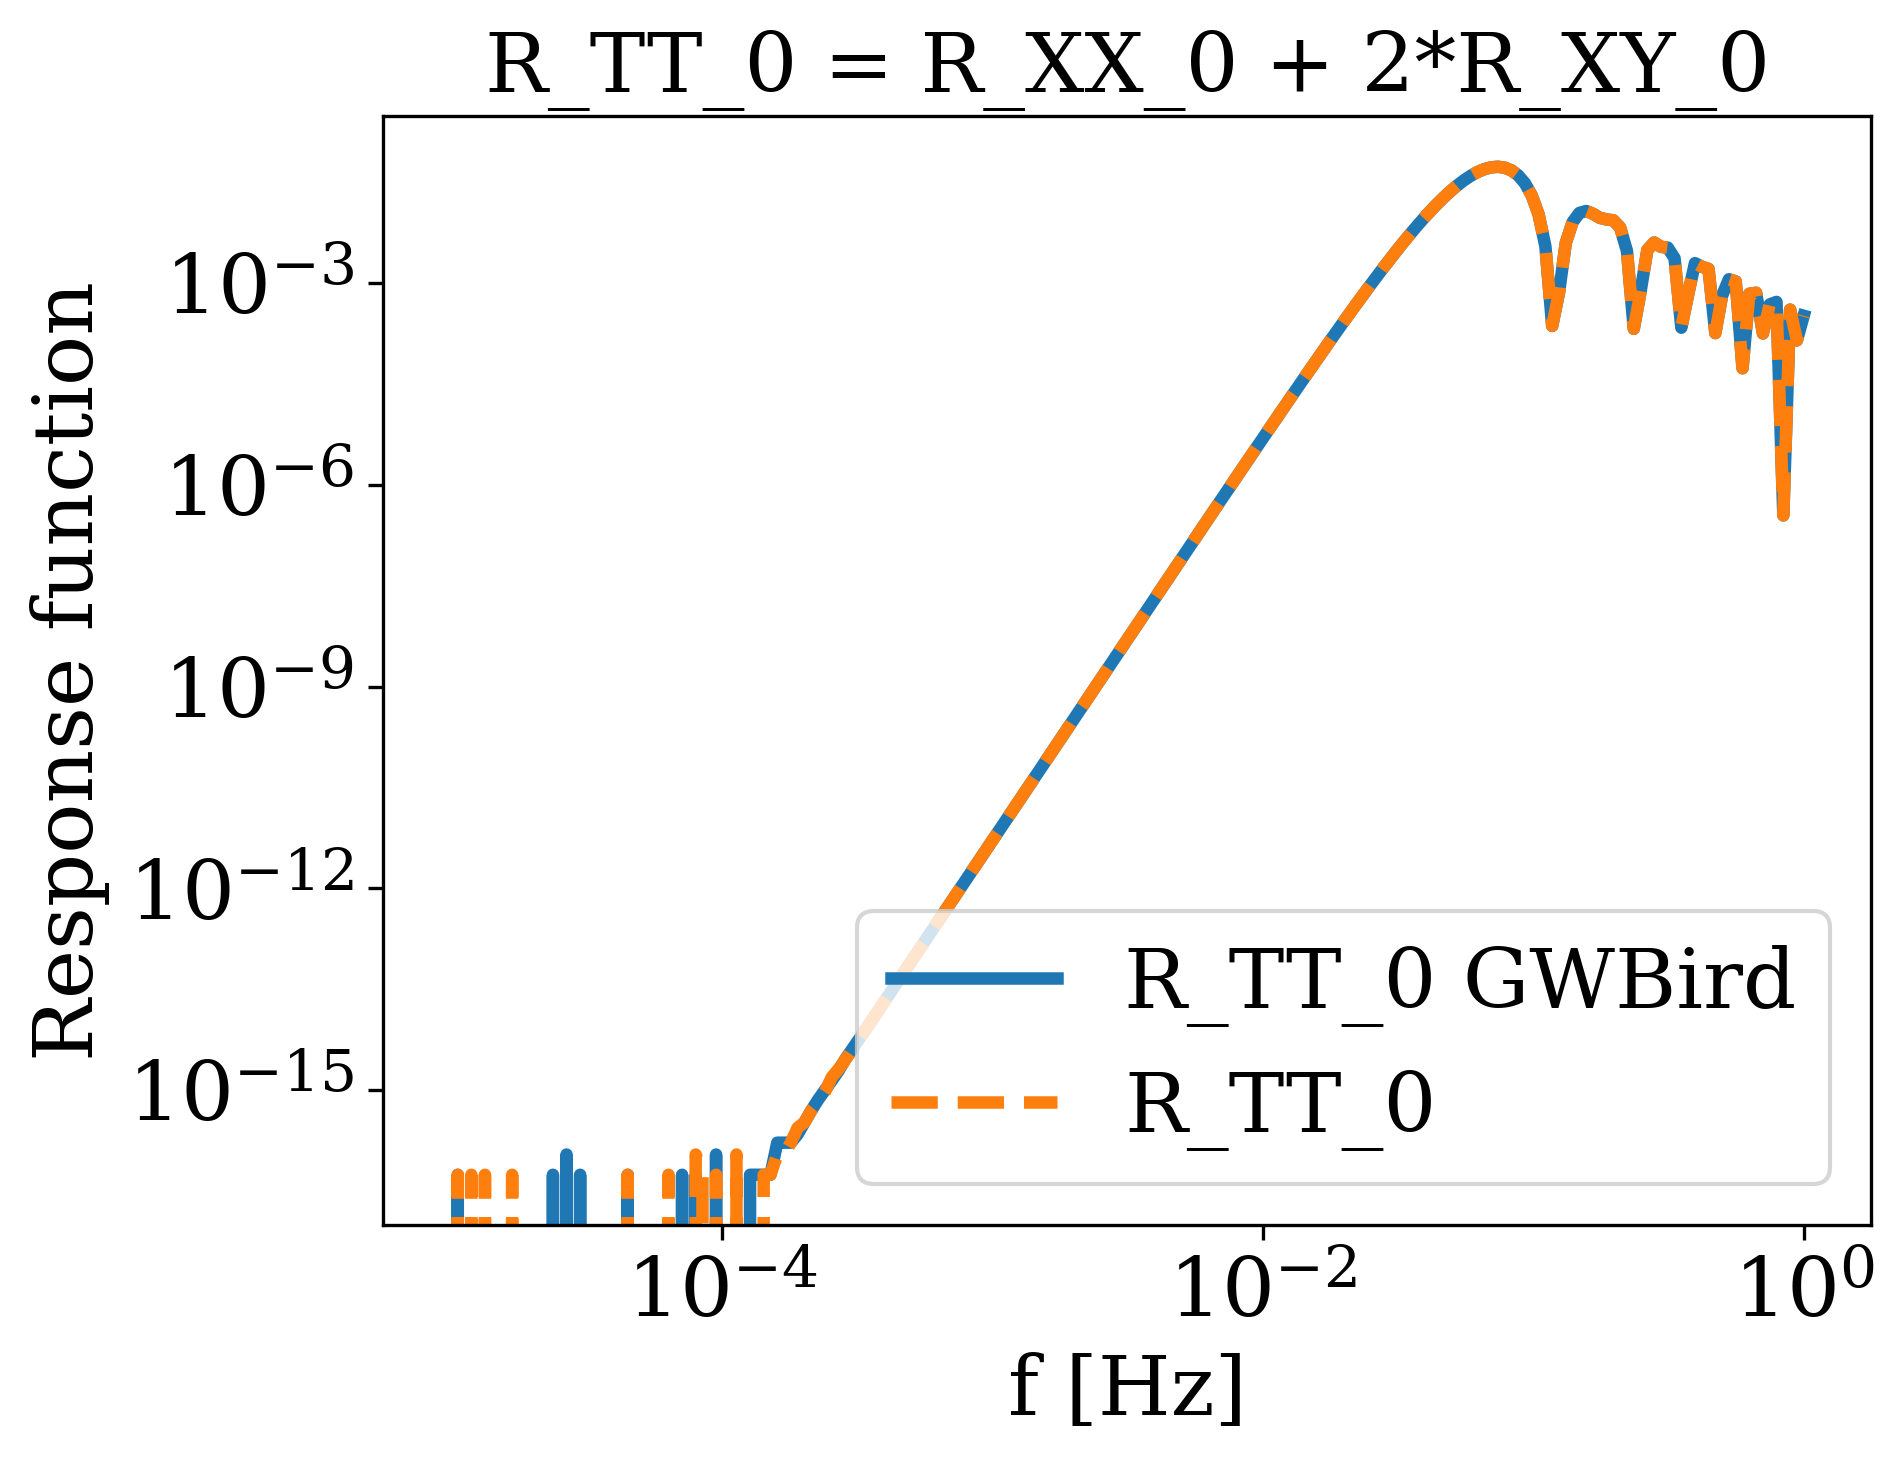

In [33]:
plt.plot(f, R_XX_0 + 2* R_XY_0, label='R_TT_0 GWBird')
plt.plot(f_vec, R1_vec + 2*R2_vec, label='R_TT_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.title('R_TT_0 = R_XX_0 + 2*R_XY_0')
plt.legend()




In [34]:
R1_vec_ell = Response_ell(lA,lA,xA,xA,f,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f,f_star, 0, 0)

R_XX_ratio = R_XX_0 / R1_vec_ell
R_XY_ratio = R_XY_0 / R2_vec_ell


NameError: name 'Response_ell' is not defined

[0.9999999933395044+9.3798947476527525e-22j
 0.9999999925224768-9.5573233703613842e-22j
 0.9999999916052251+7.3280175906484615e-22j
 0.9999999905754569+3.7905025730442517e-23j
 0.9999999894193686+4.2410784084447409e-22j
 0.9999999881214663-1.5972733294672180e-21j
 0.9999999866643531-7.0357329965198843e-22j
 0.9999999850284989+1.2533406095204894e-22j
 0.9999999831919777-1.6980538000793971e-22j
 0.999999981130175 -1.9978393635819137e-21j
 0.9999999788154555-1.4035343669363547e-21j
 0.9999999762167945+1.0631124498041806e-21j
 0.9999999732993611-9.5545658875280007e-23j
 0.9999999700240523+2.6406966540315364e-22j
 0.999999966346969 +9.1609498518478841e-22j
 0.9999999622188257-1.4385072414256492e-21j
 0.9999999575842923+1.5043727212213902e-21j
 0.999999952381251 -1.5815820836044244e-22j
 0.9999999465399629+1.8707066817999275e-21j
 0.9999999399821372+1.3982156193519725e-21j
 0.9999999326198772-3.6602720424039764e-22j
 0.999999924354504 -1.0055394435895201e-21j
 0.9999999150752357+2.1838942810

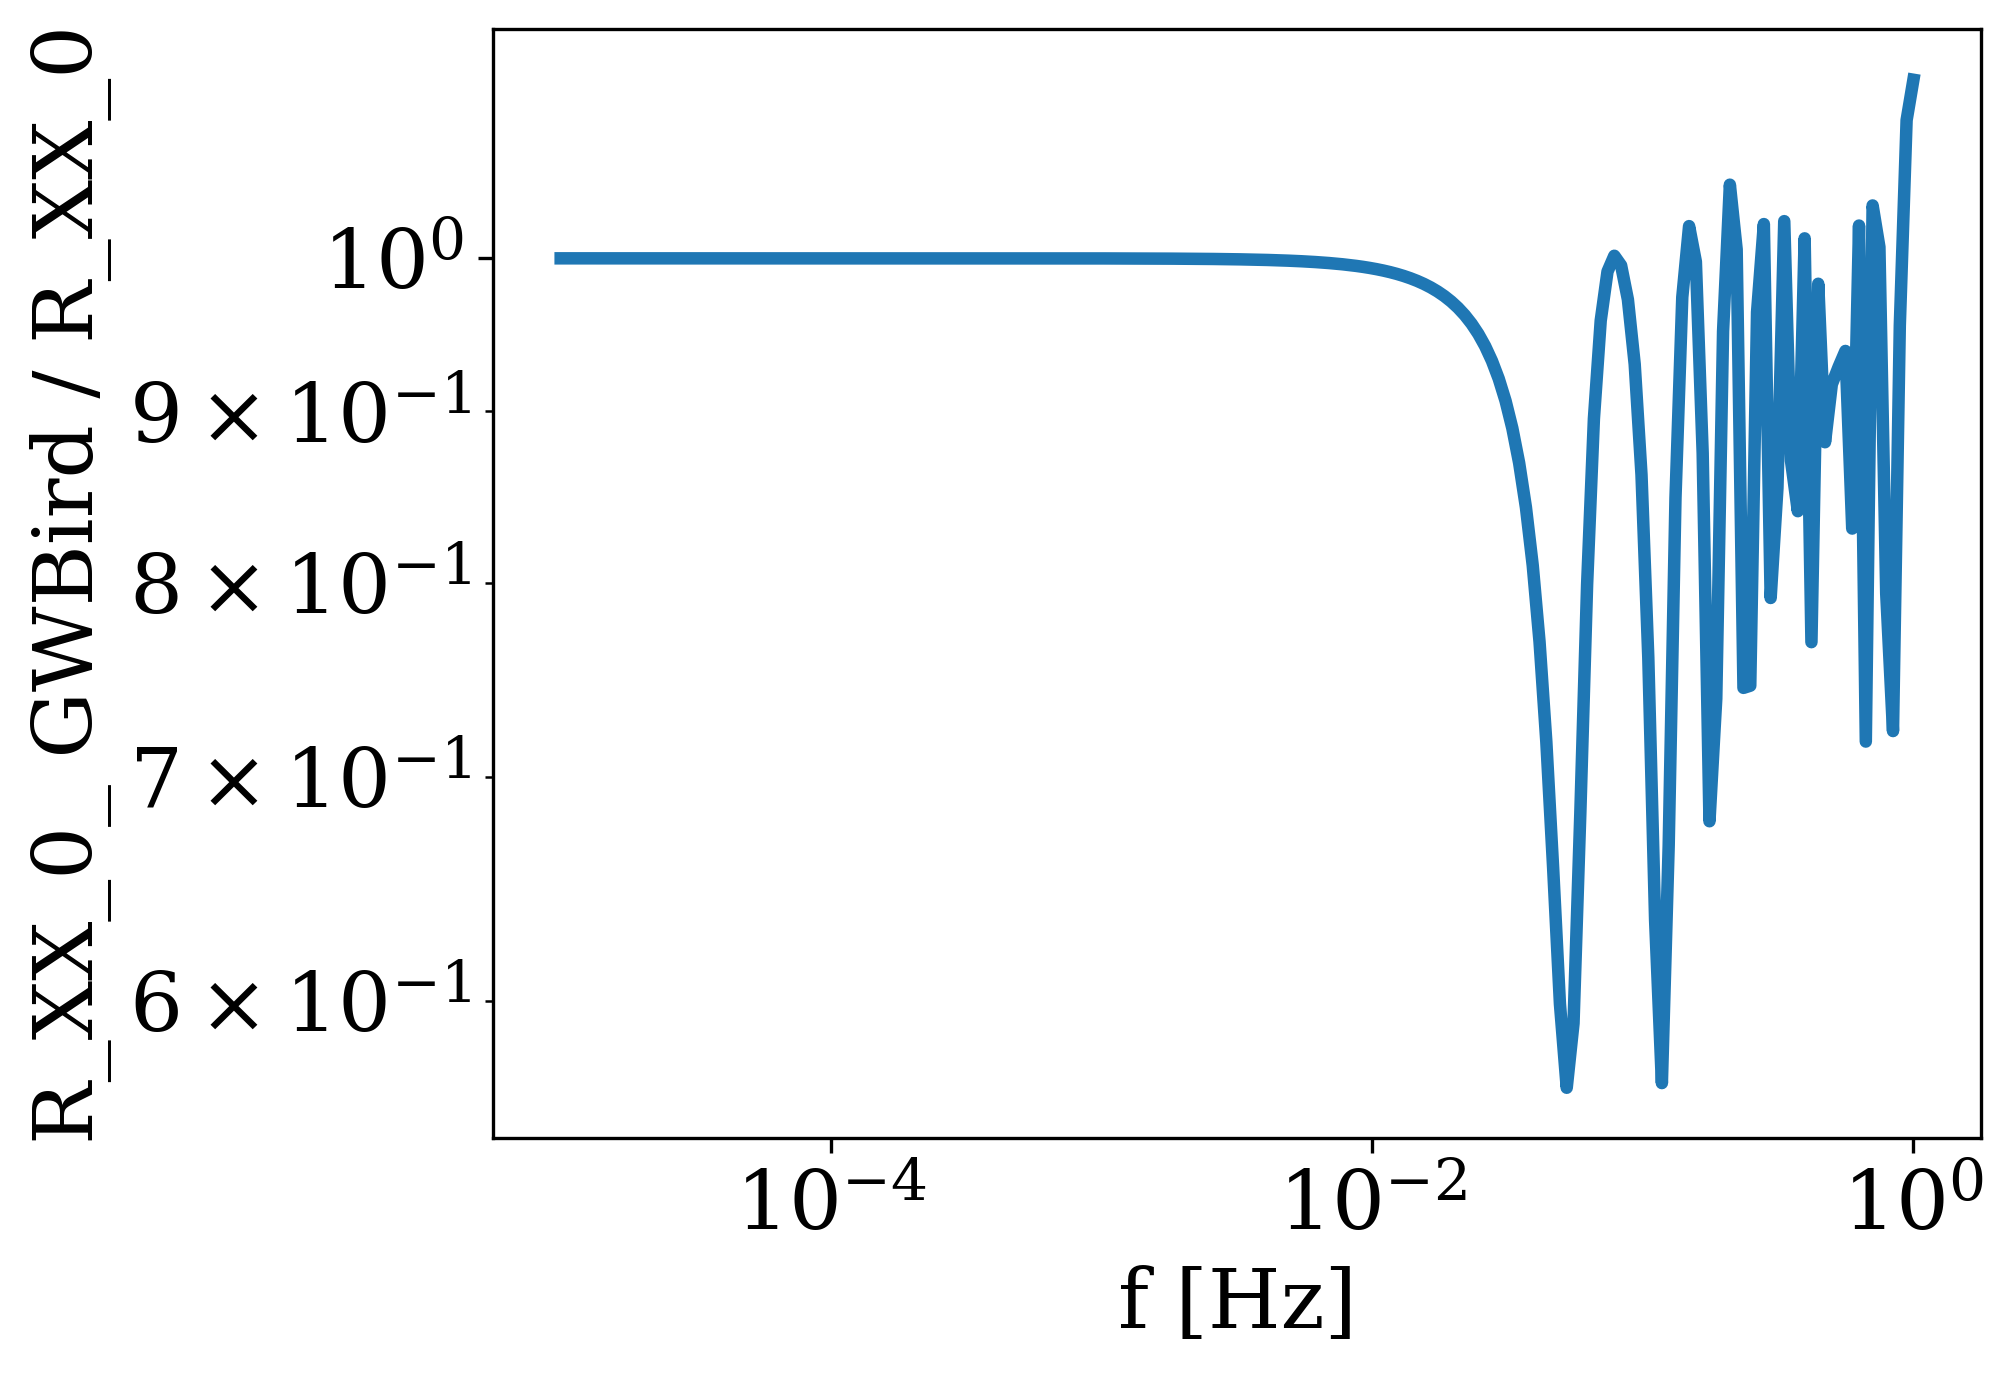

In [288]:
plt.loglog(f, R_XX_ratio)
plt.xlabel('f [Hz]')
plt.ylabel('R_XX_0_ GWBird / R_XX_0')

np.set_printoptions(precision=20)

print(R_XX_ratio)

[  0.9999999639595197  +6.3318001387422641e-20j
   0.9999999595385145  +2.4646637752801815e-21j
   0.9999999545751942  -2.9179759157865520e-21j
   0.9999999490030346  +8.6520429993143409e-20j
   0.9999999427473507  +2.2331265413774633e-21j
   0.999999935724296   -2.9982990517005380e-20j
   0.9999999278397388  +5.5338229186101270e-20j
   0.999999918988001   -4.6669719602095871e-20j
   0.9999999090504404  -6.0009122985204463e-20j
   0.9999998978938617  +4.5155423021709578e-20j
   0.9999998853687299  +9.2082681509100074e-20j
   0.9999998713071685  -5.0460879279479743e-20j
   0.9999998555207076  -1.1325728967184933e-19j
   0.9999998377977566  -6.2523028095107764e-20j
   0.9999998179007719  -1.2972505149558187e-19j
   0.999999795563069   +1.3554495278710999e-19j
   0.9999997704852508  +1.0169933365212499e-19j
   0.9999997423311939  -4.3311747278721239e-20j
   0.999999710723543   +1.8179096121714526e-19j
   0.999999675238654   +2.5964728299209687e-20j
   0.9999996354009147  +9.70141406965736

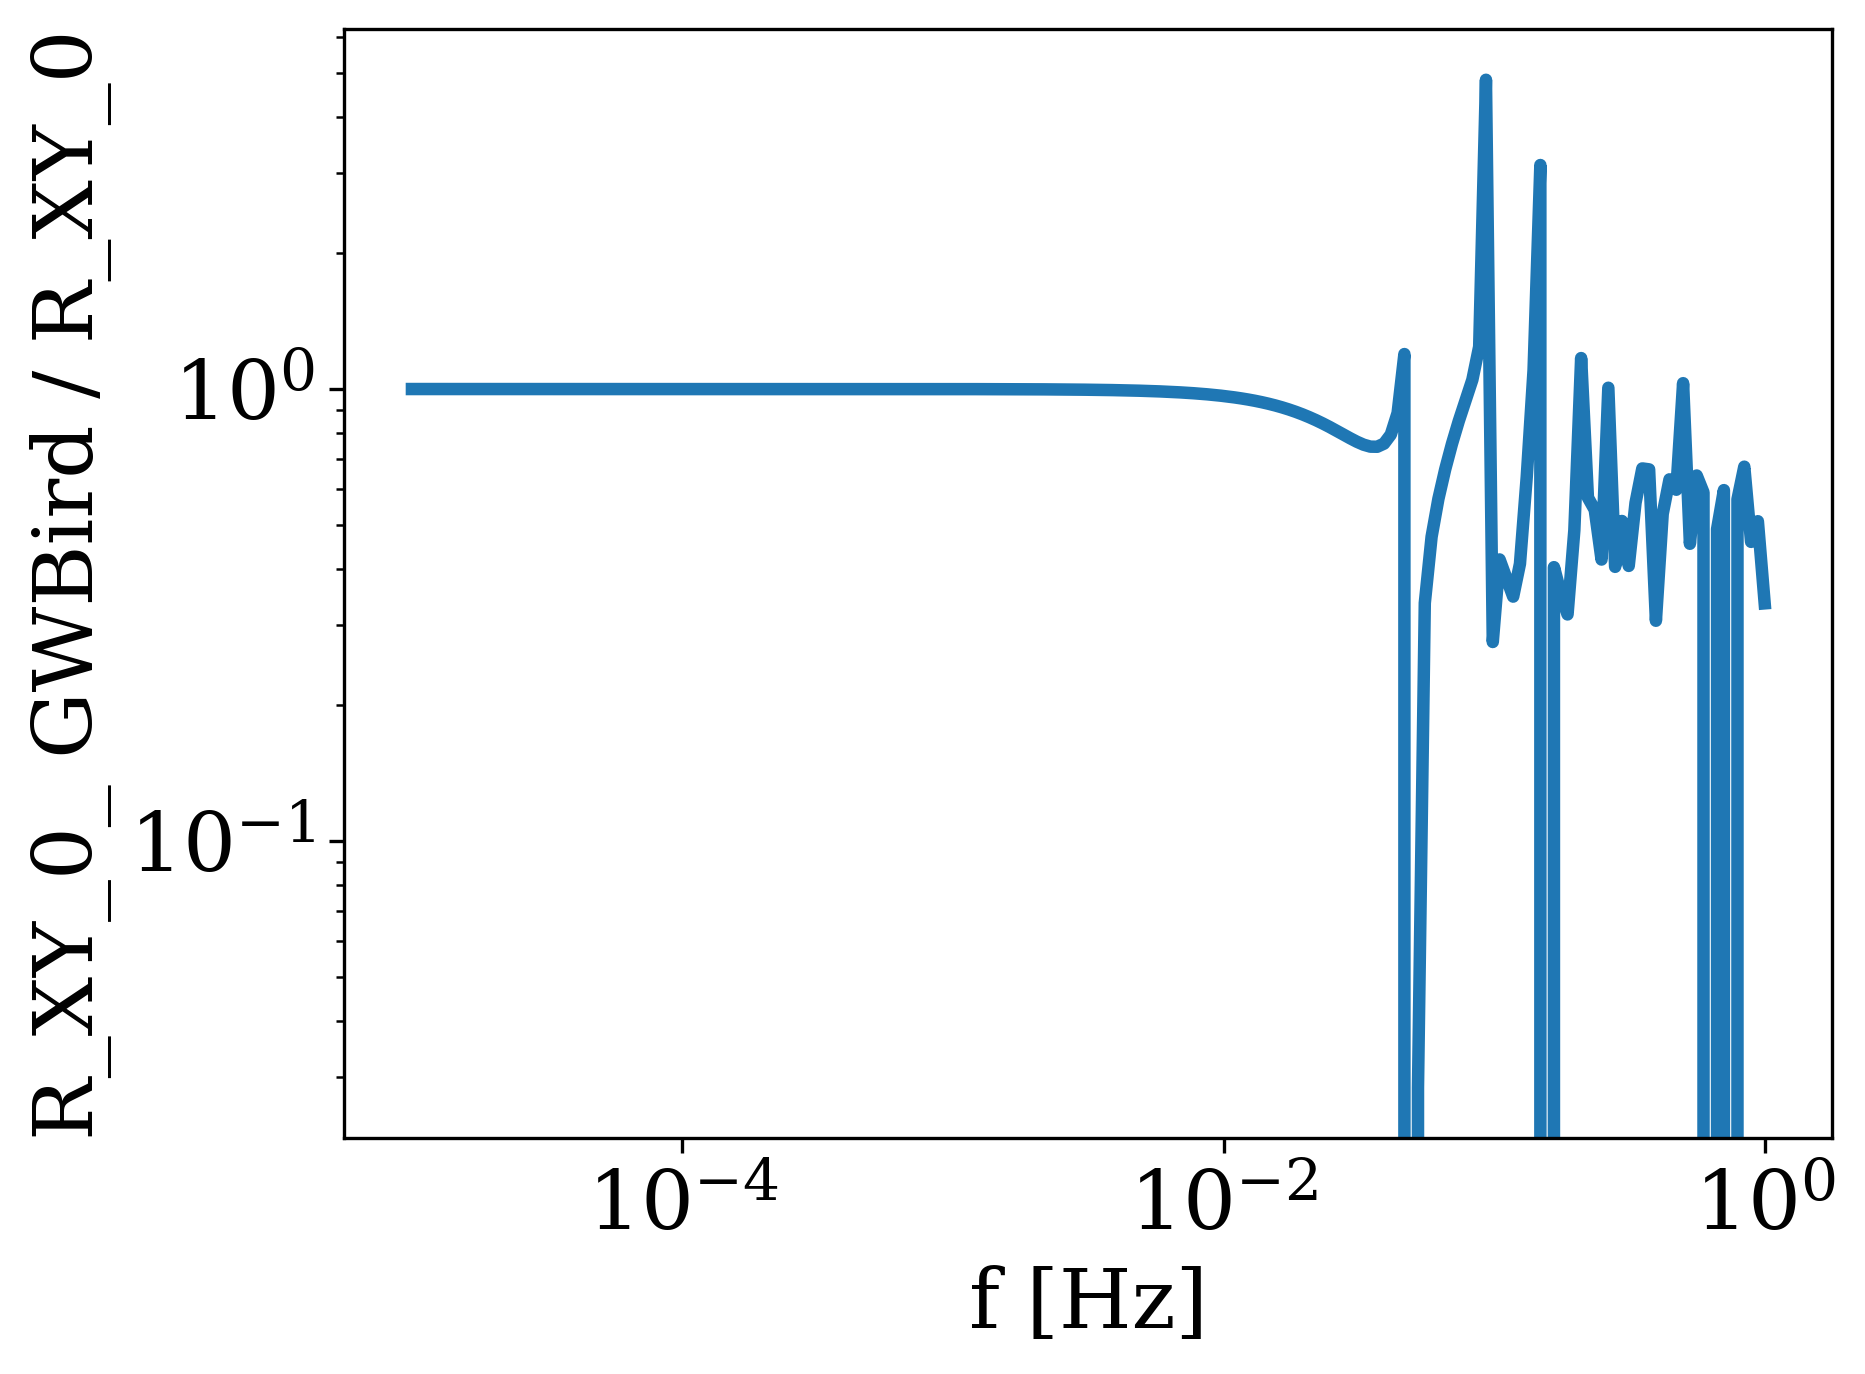

In [289]:
plt.loglog(f, R_XY_ratio)
plt.xlabel('f [Hz]')
plt.ylabel('R_XY_0_ GWBird / R_XY_0')

print(R_XY_ratio)



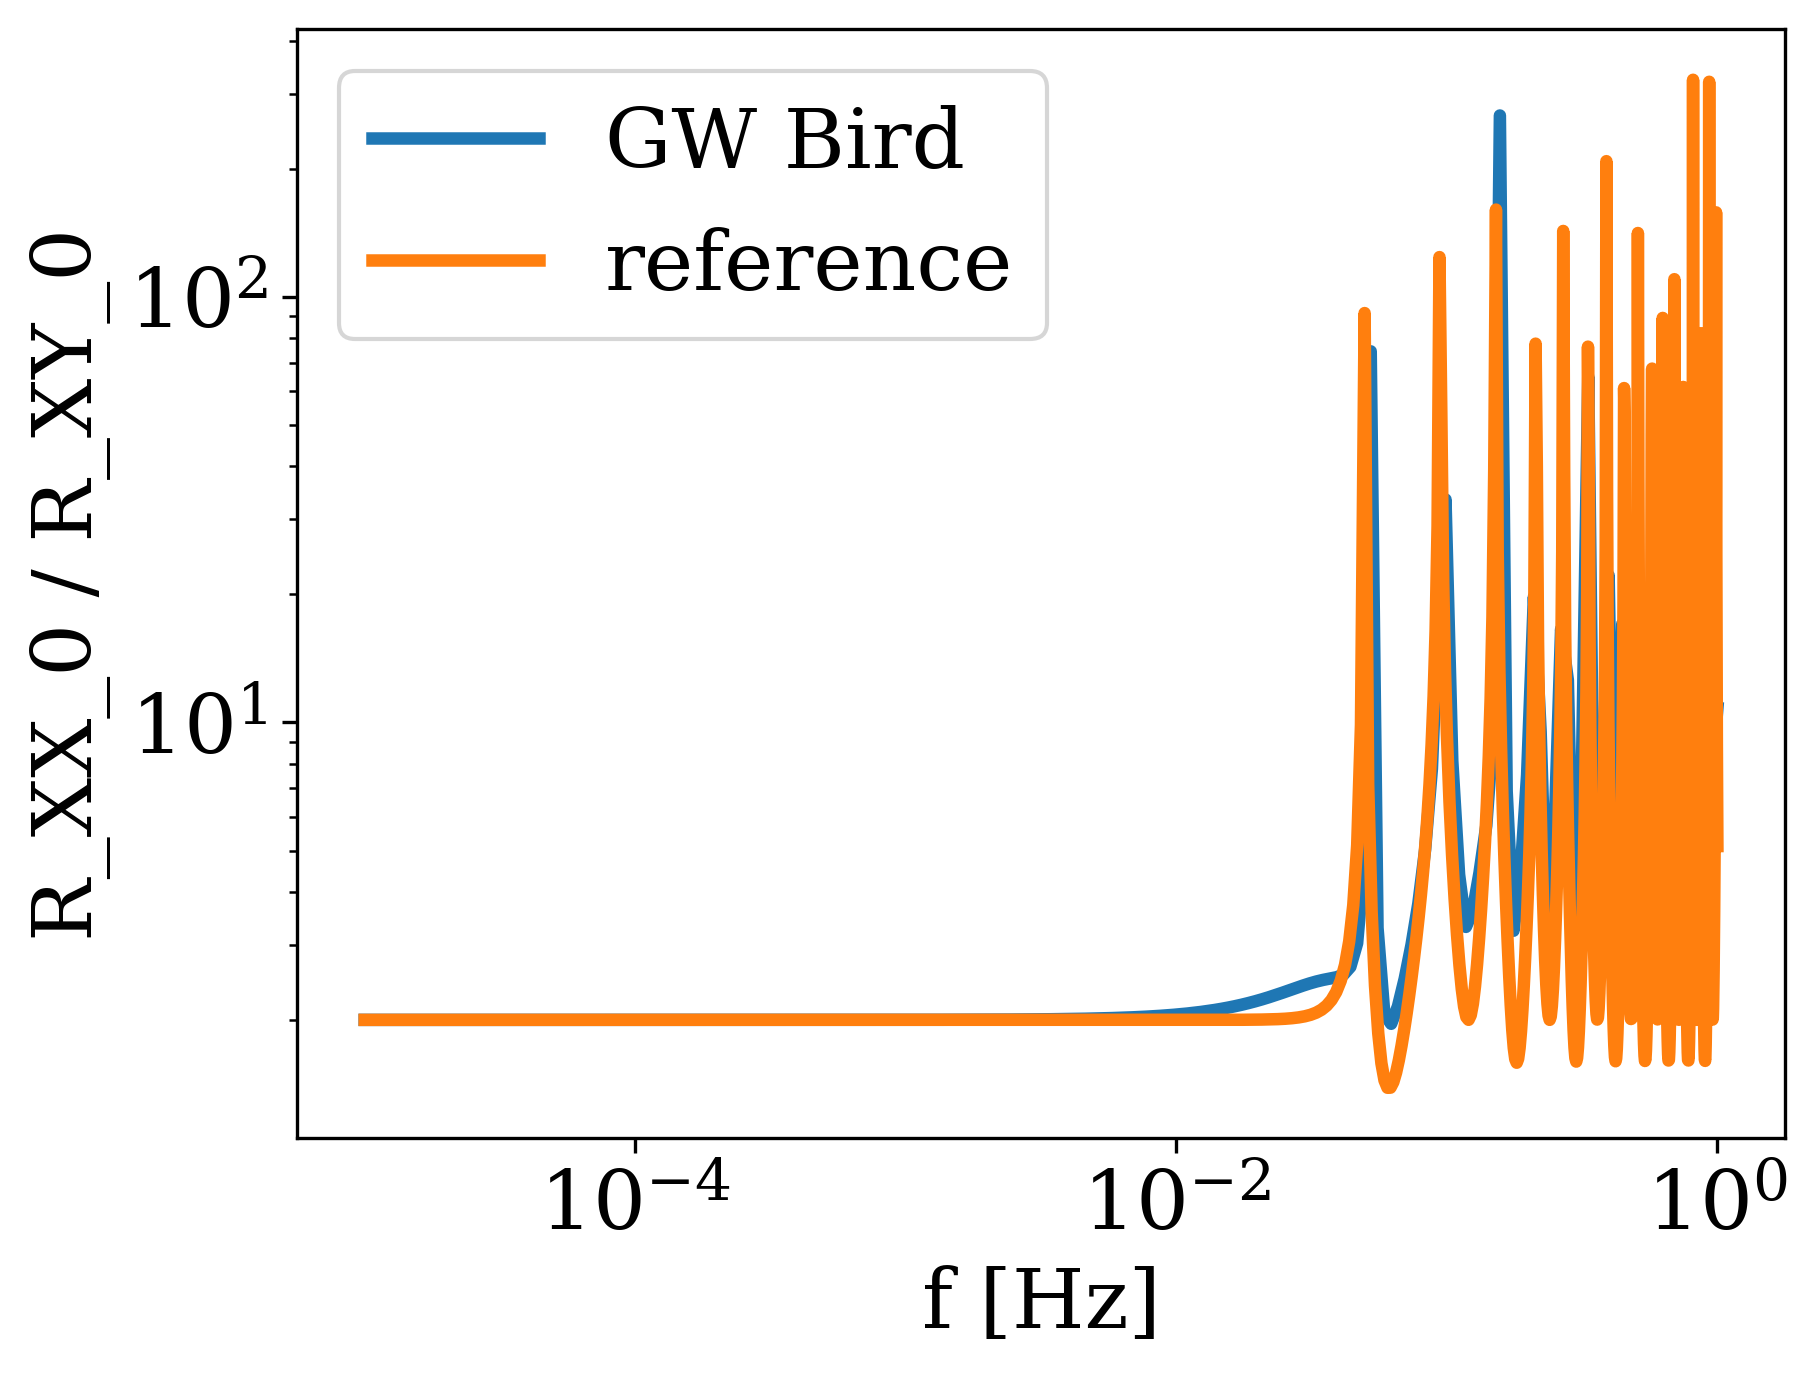

In [290]:
GWBird_ratio = R_XX_0 / R_XY_0
ratio = R1_vec / R2_vec

plt.loglog(f, np.abs(GWBird_ratio), label='GW Bird')
plt.loglog(f_vec, np.abs(ratio), label='reference')
plt.xlabel('f [Hz]')
plt.ylabel('R_XX_0 / R_XY_0')
plt.legend()


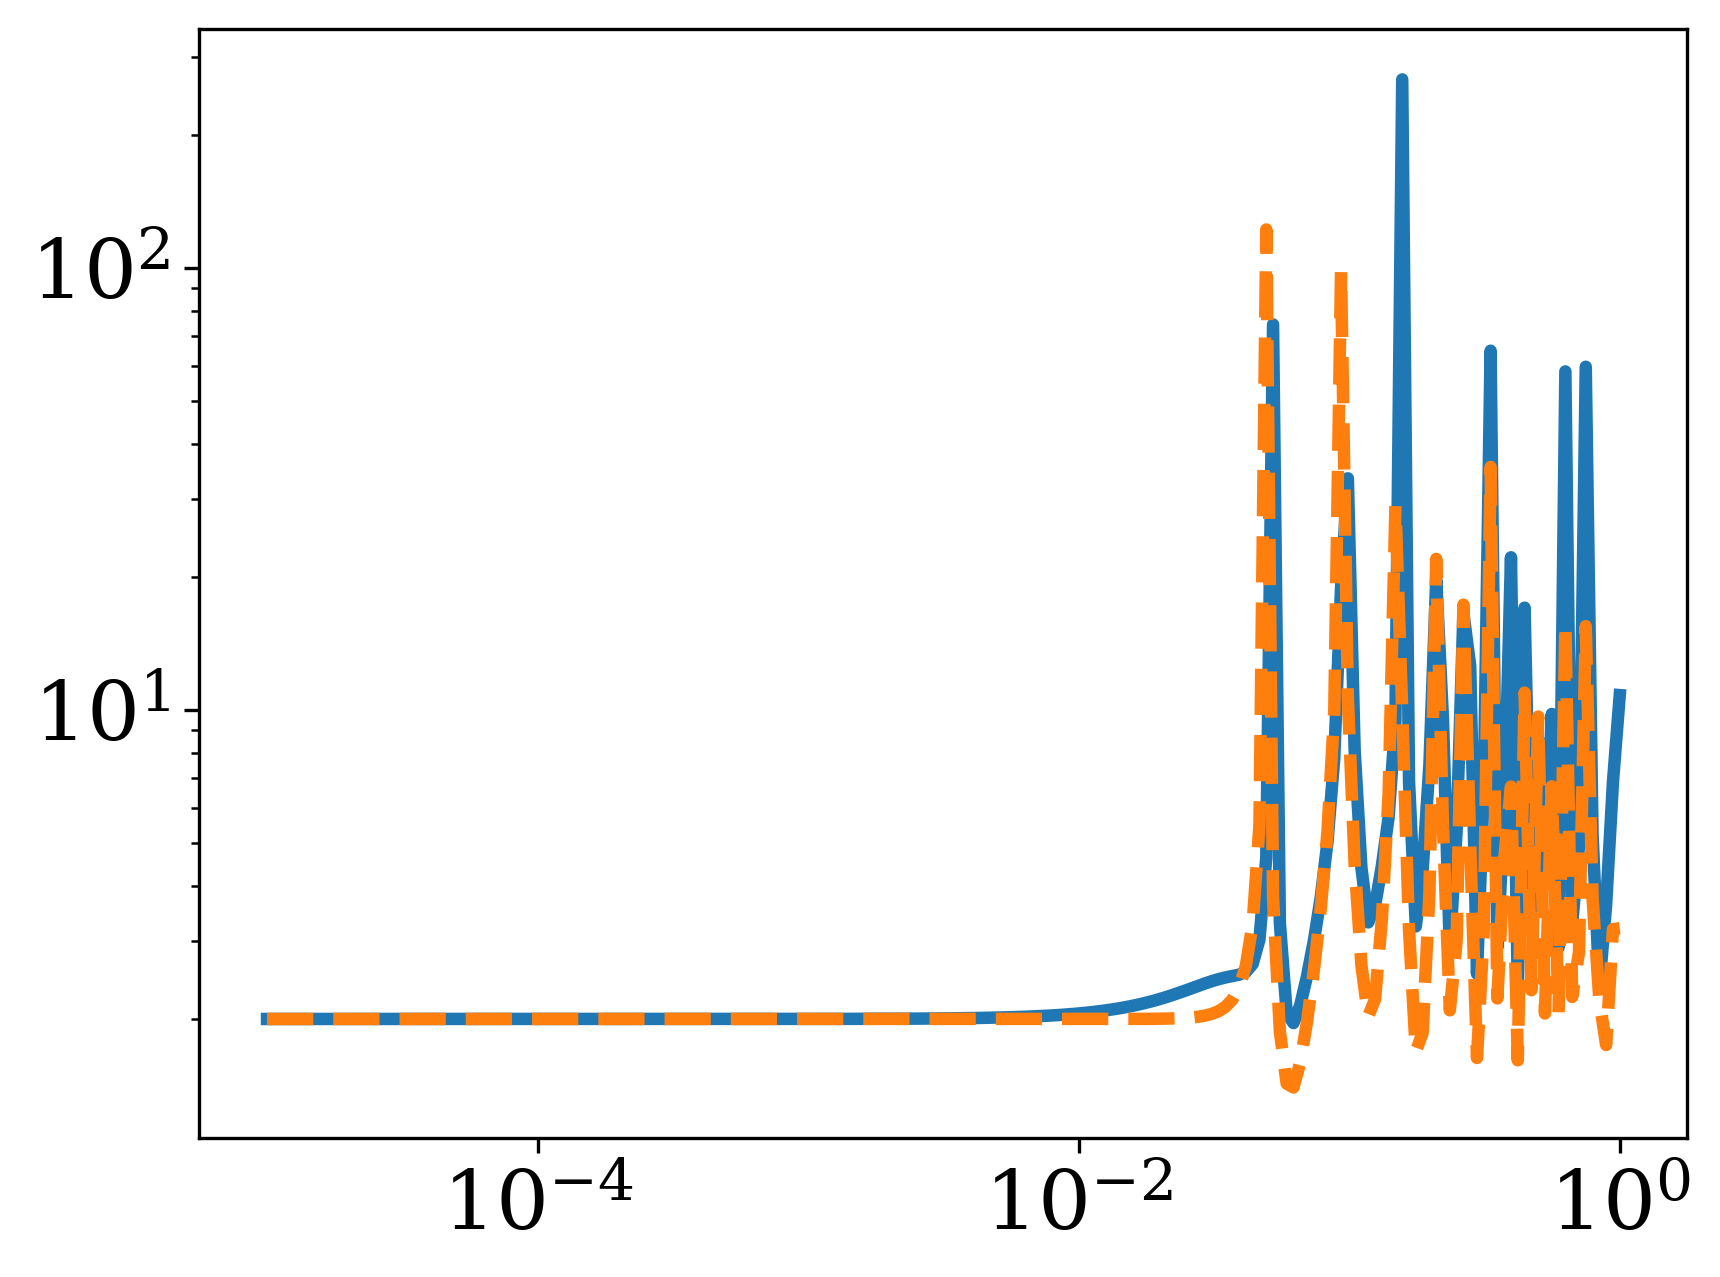

In [291]:
# plottare il rapporto 

plt.plot(f, np.abs(R_XX_0/R_XY_0))
plt.plot(f, np.abs(R1_vec_ell/R2_vec_ell), linestyle='--')
plt.xscale('log')
plt.yscale('log')


In [292]:
print(R_XX_0[0])
print(R1_vec_ell[0])

(0.299937025262911+2.81337774662866e-22j)
0.29993702726064025


/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_49909/2180239967.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(f, R_TT_GWBird/R_TT)


Text(0, 0.5, 'R_TT GWBird / R_TT')

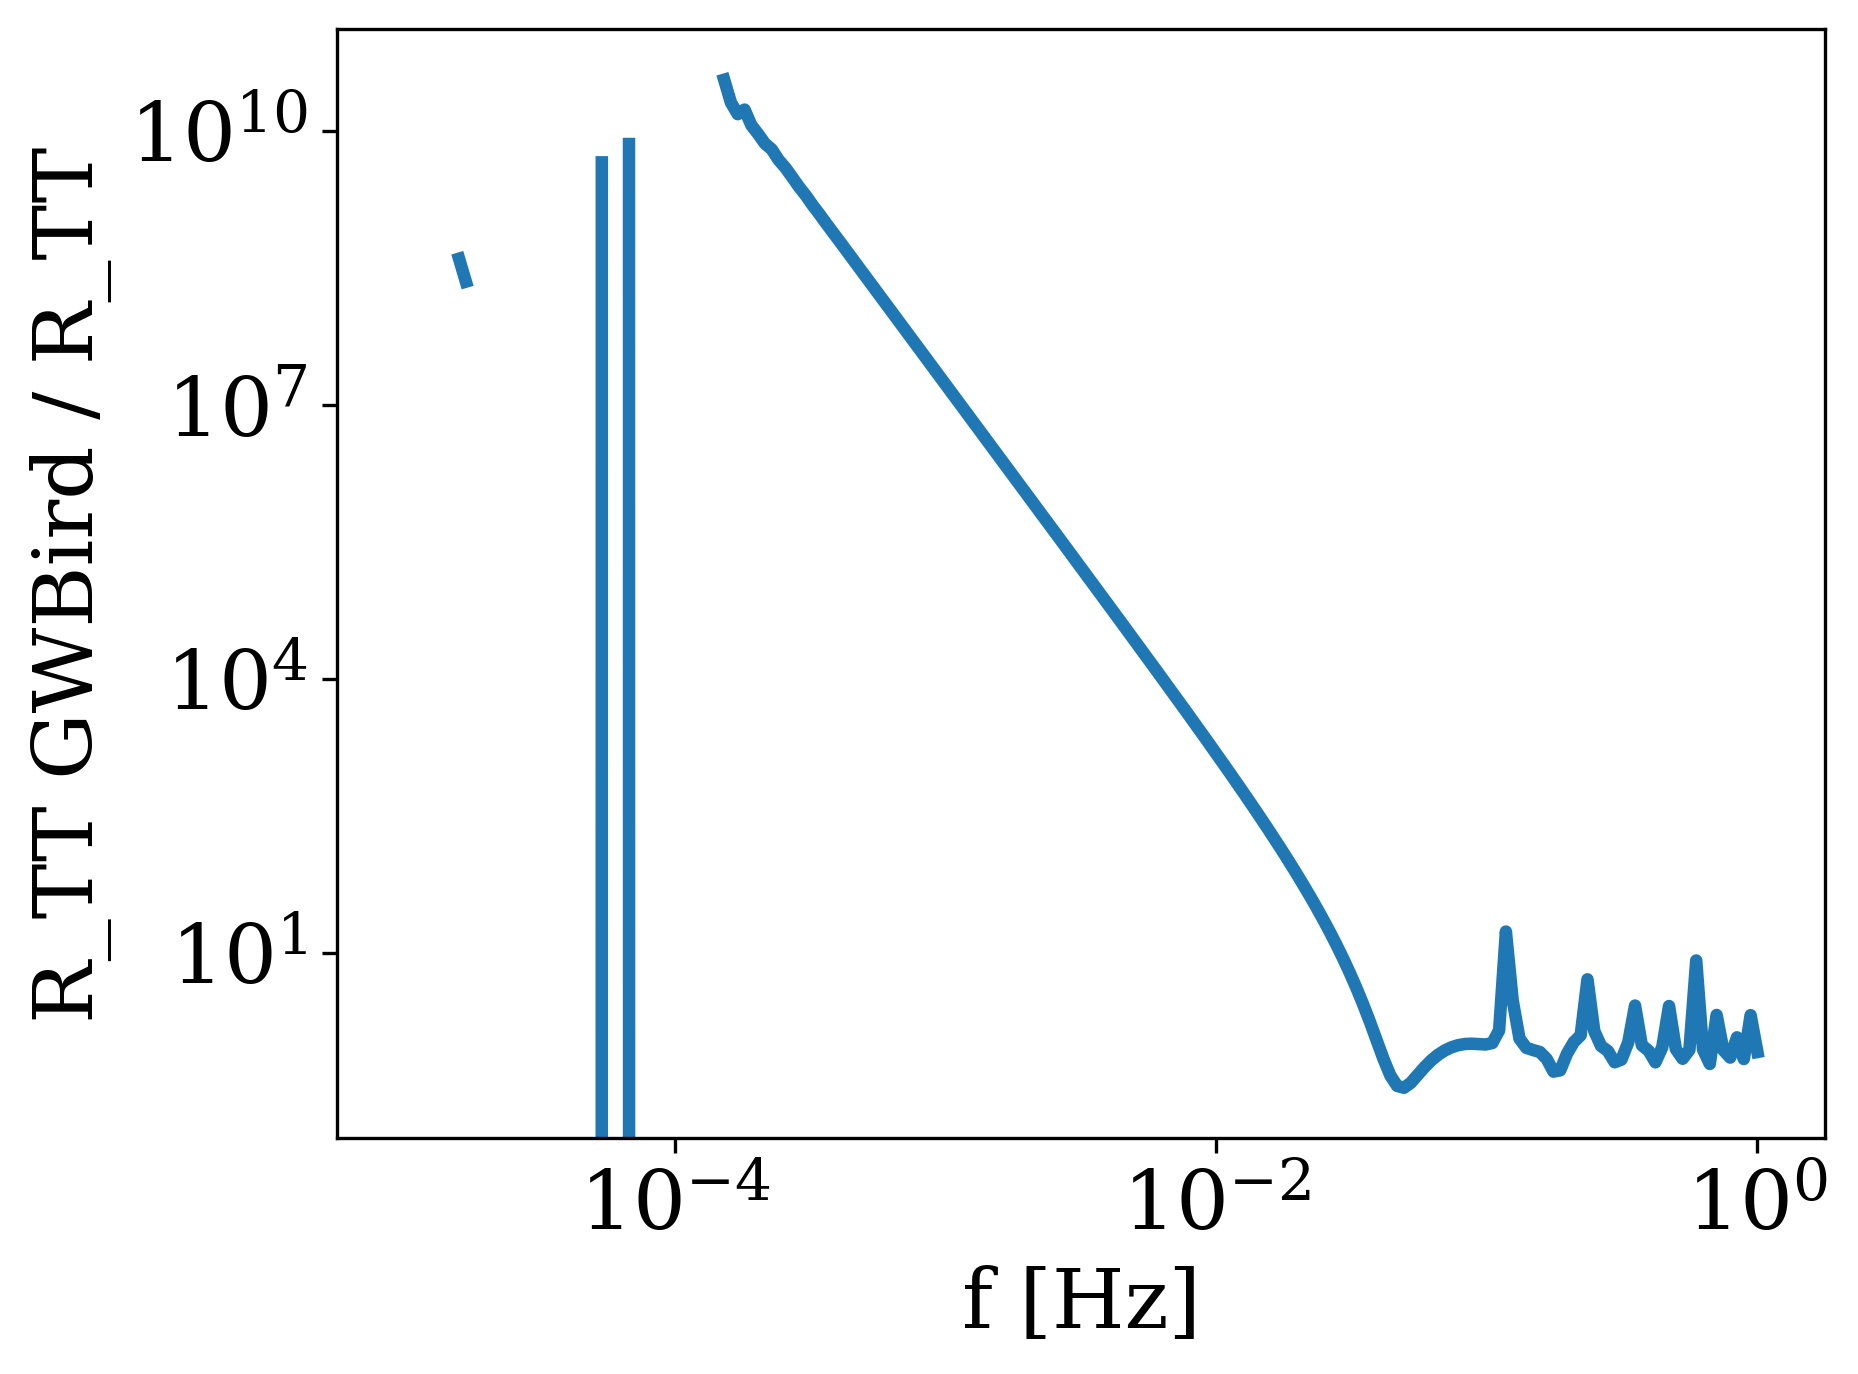

In [293]:
R_TT_GWBird = R_XX_0 + 2 * R_XY_0
R_TT = R1_vec_ell + 2 * R2_vec_ell

plt.loglog(f, R_TT_GWBird/R_TT)
plt.xlabel('f [Hz]')
plt.ylabel('R_TT GWBird / R_TT')


Text(0, 0.5, 'R')

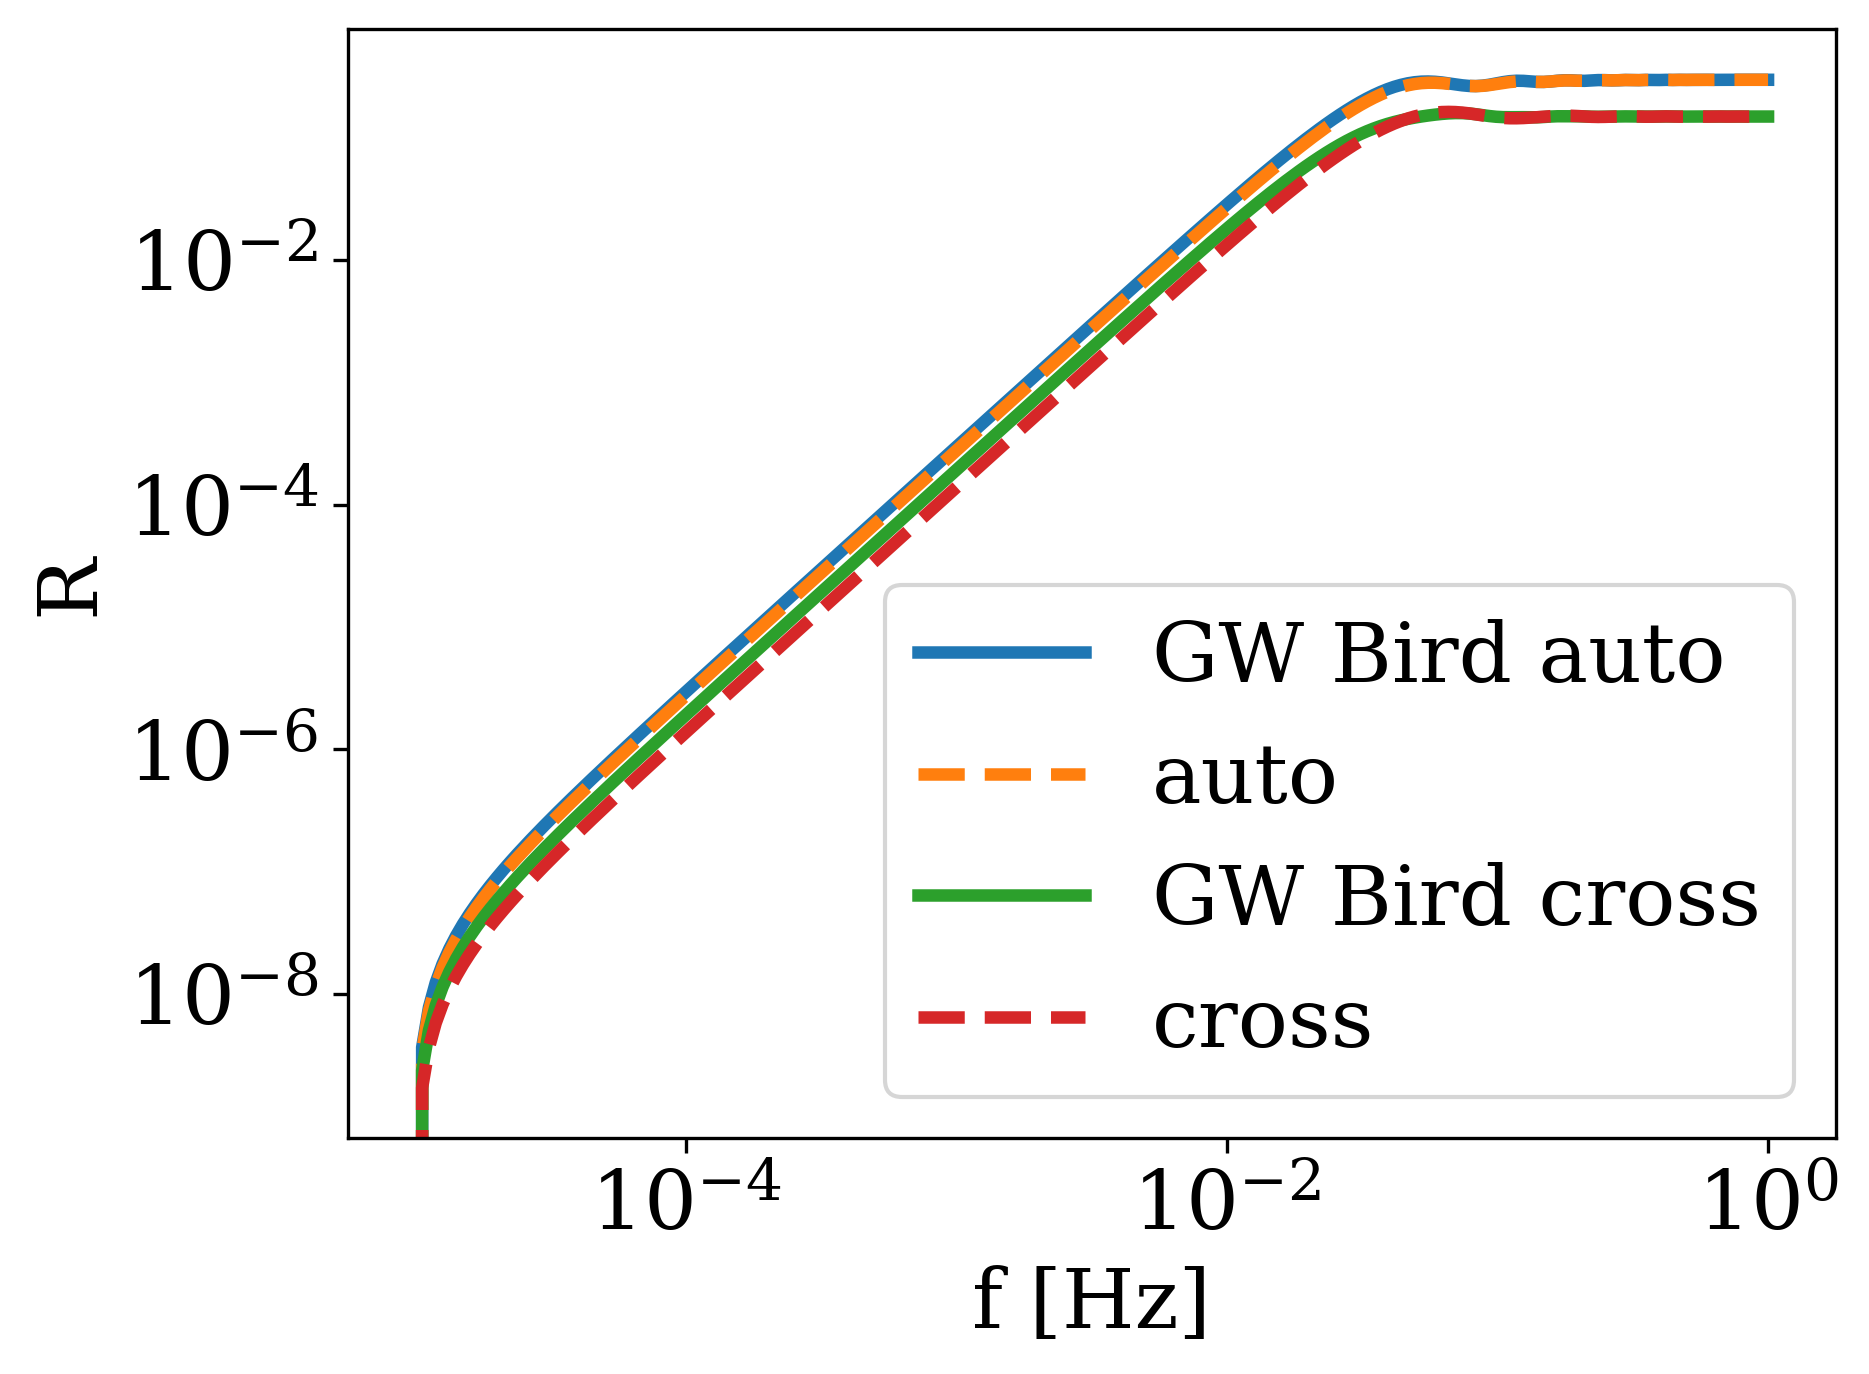

In [294]:
ref_GWBird_auto = R_XX_0[0] - R_XX_0
ref_auto = R1_vec_ell[0] - R1_vec_ell
ref_GWBird_cross = R_XY_0[0] - R_XY_0
ref_cross = R2_vec_ell[0] - R2_vec_ell

plt.loglog(f, ref_GWBird_auto, label='GW Bird auto')
plt.loglog(f, ref_auto, label='auto', linestyle='--')
plt.loglog(f, np.abs(ref_GWBird_cross), label='GW Bird cross')
plt.loglog(f, np.abs(ref_cross), label='cross', linestyle='--')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('R')



Text(0, 0.5, 'differences')

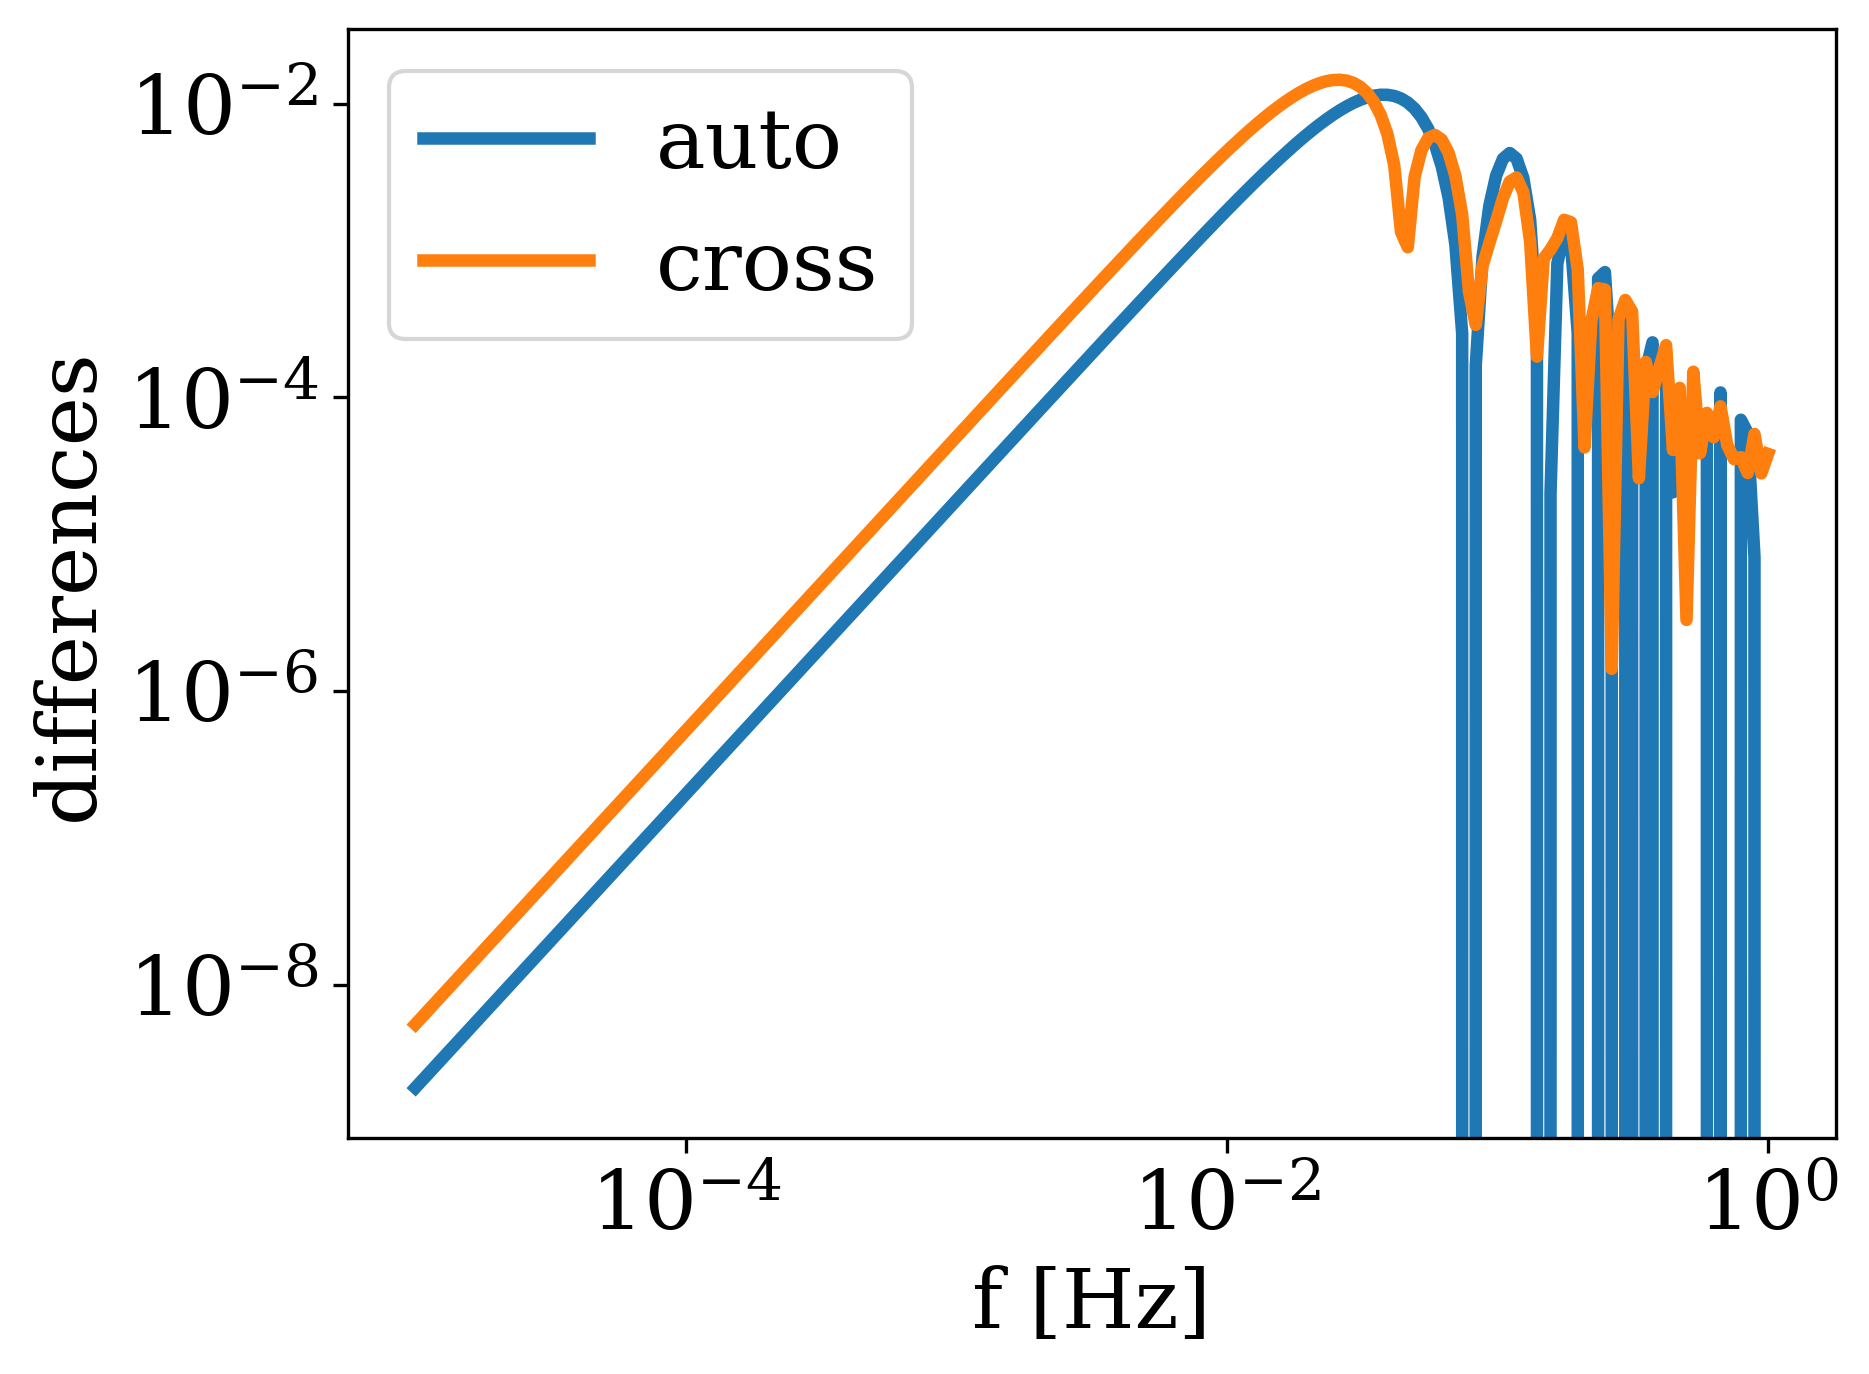

In [295]:
diff_auto = R1_vec_ell - R_XX_0
diff_cross = R2_vec_ell - R_XY_0

plt.loglog(f, diff_auto, label='auto')
plt.loglog(f, np.abs(diff_cross), label='cross')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('differences')


Text(0, 0.5, 'relative differences')

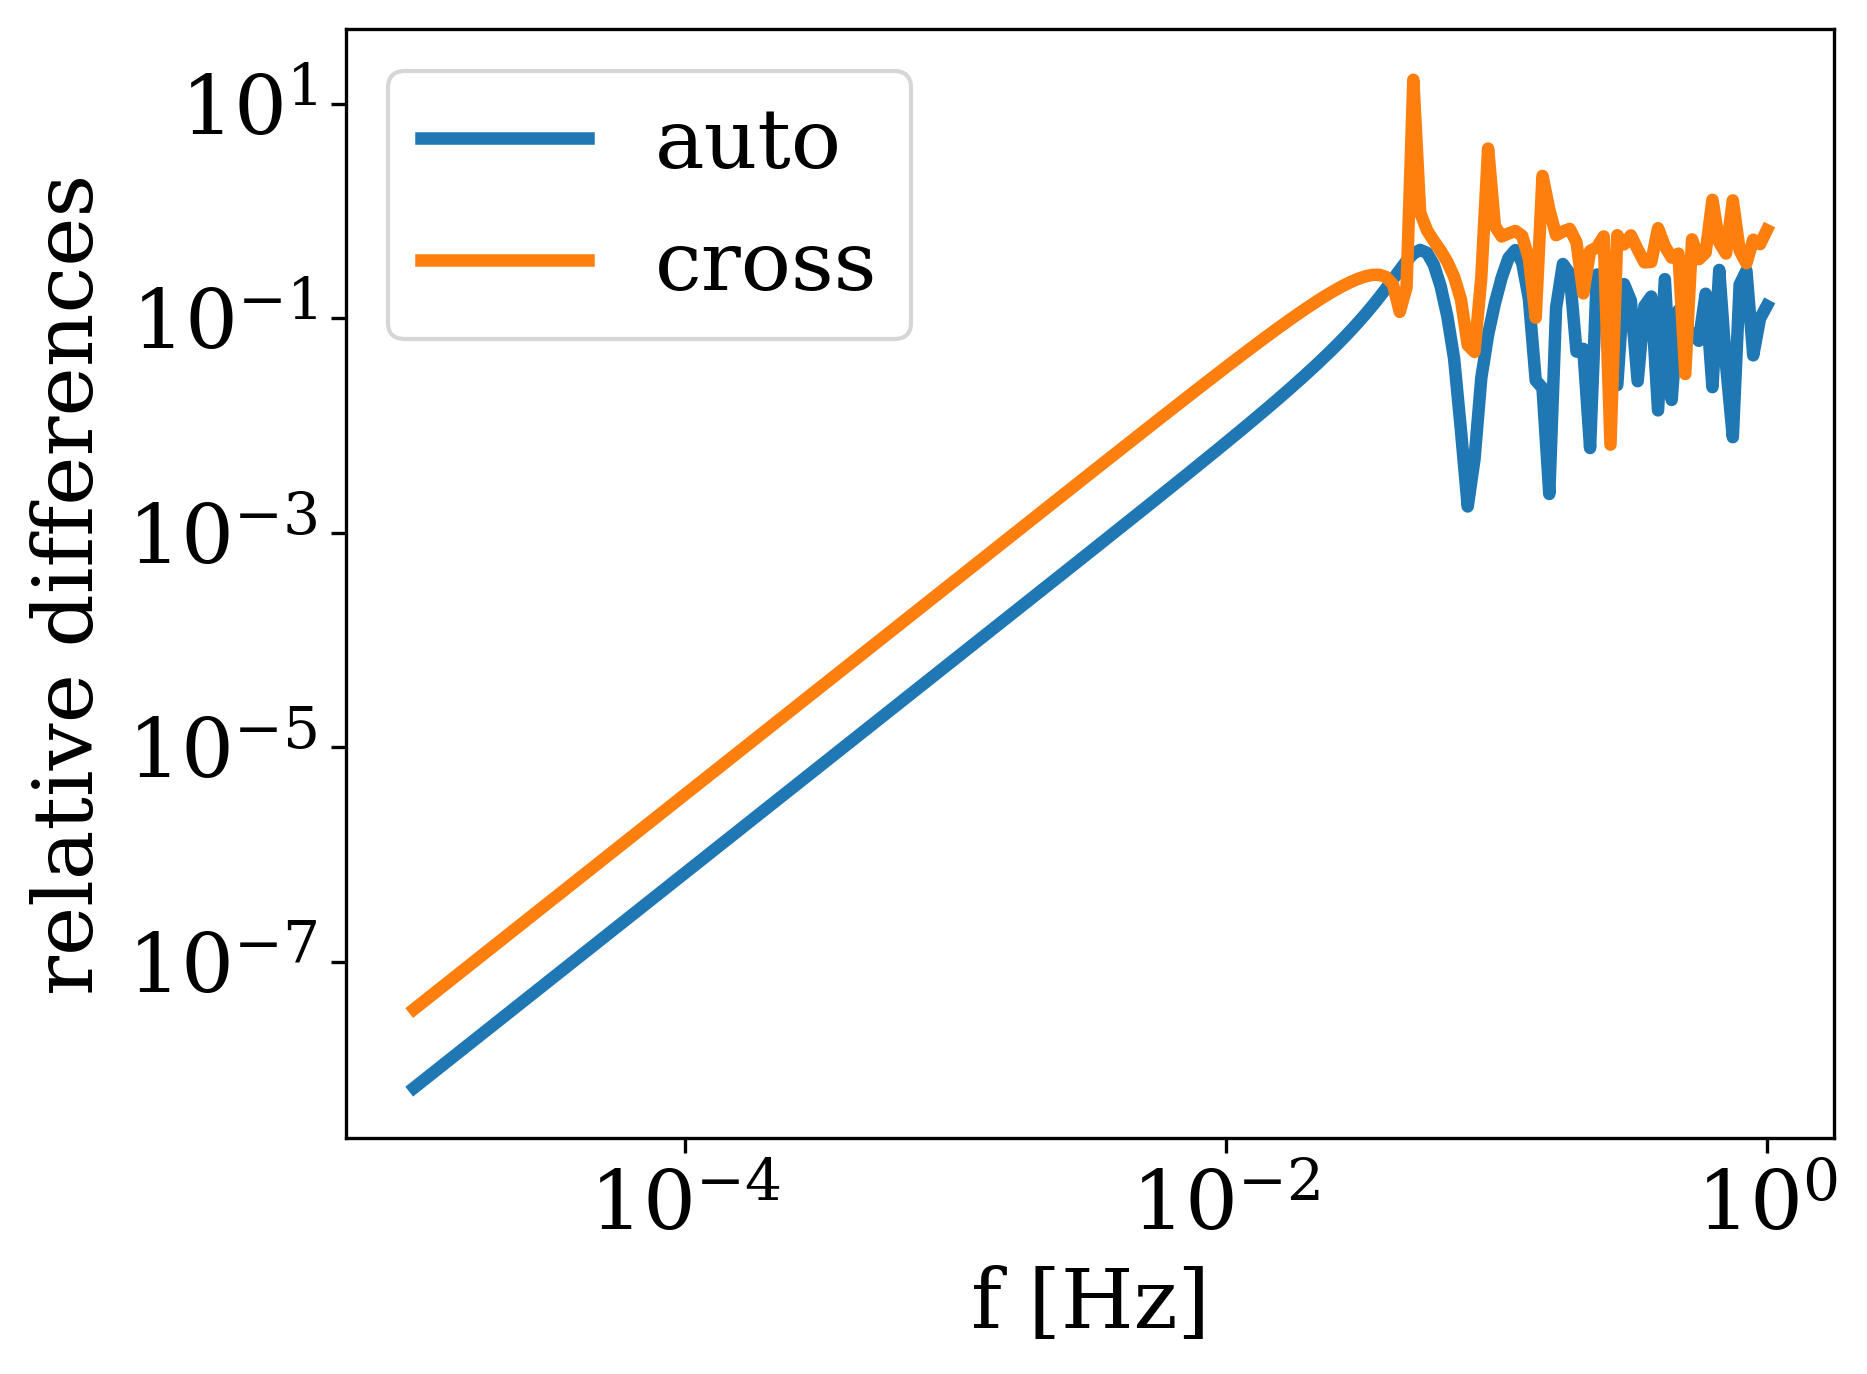

In [296]:
# relative differences
diffrel_auto =( R1_vec_ell - R_XX_0) / R1_vec_ell
diffrel_cross = (R2_vec_ell - R_XY_0) / R2_vec_ell

plt.loglog(f, np.abs(diffrel_auto), label='auto')
plt.loglog(f, np.abs(diffrel_cross), label='cross')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('relative differences')

0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744
0.01909859317102744


/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_49909/1374006137.py:23: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  R_XX_0_prime = derivative(R_XX_0_func, f_interp, dx=1e-6)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_49909/1374006137.py:24: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  R_XY_0_prime = derivative(R_XY_0_func, f_interp, dx=1e-6)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_49909/1374006137.py:34: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider usi

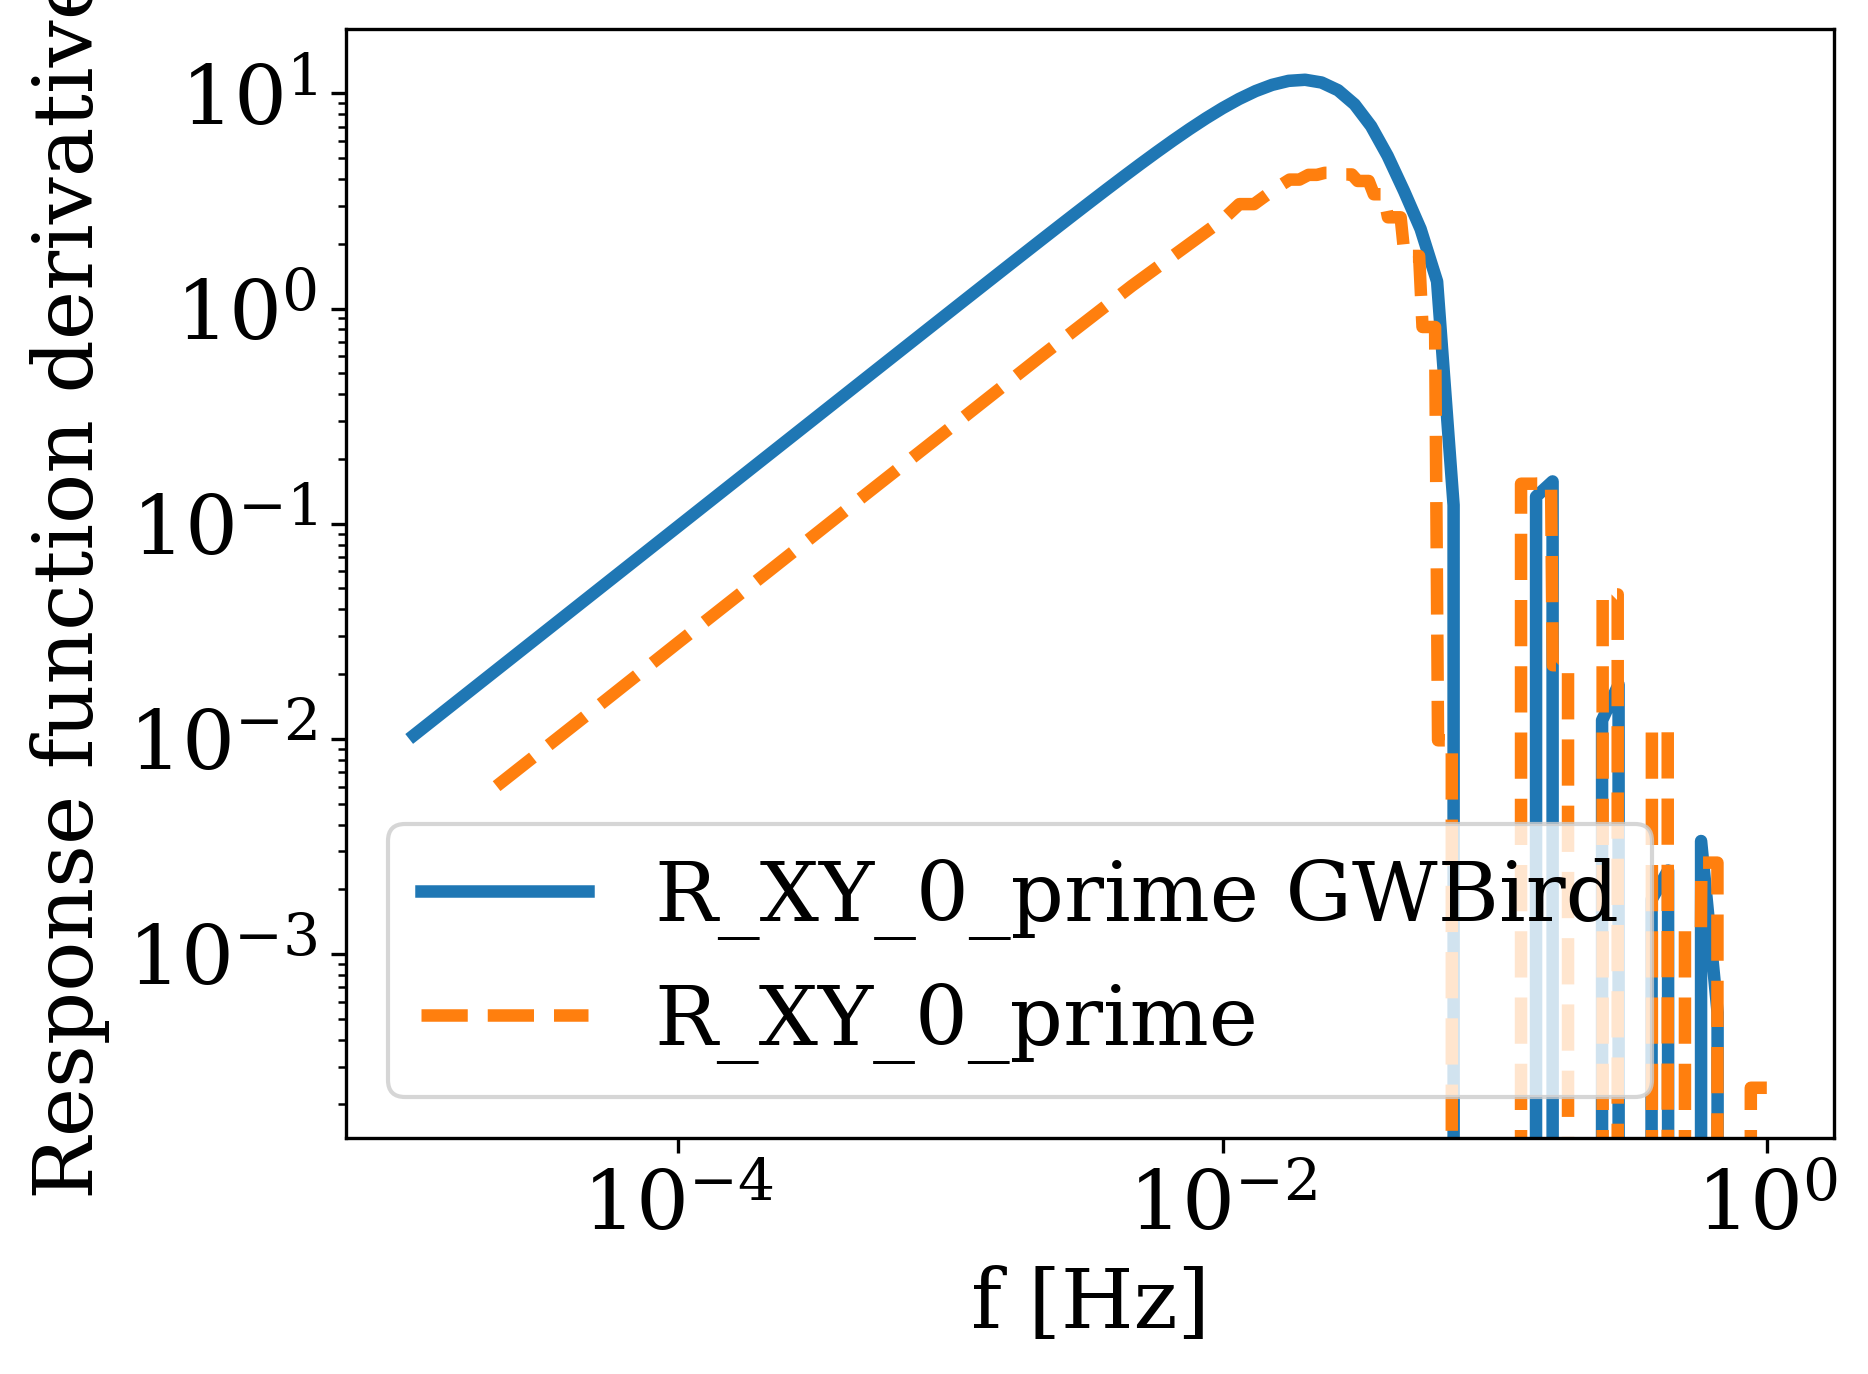

In [297]:
from scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt

f = np.logspace(-6, 0, 100)

R_XX_0 = nell.Rlm_transfer(0, 0, u1, v1, c1, u1, v1, c1, 0, f, 't', L)
R_XY_0 = nell.Rlm_transfer(0, 0, u1, v1, c1, u2, v2, c2, 0, f, 't', L)

R1_vec_ell = Response_ell(lA,lA,xA,xA,f,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f,f_star, 0, 0)



# Crea una funzione di interpolazione per i tuoi dati
R_XX_0_func = interp1d(f, R_XX_0)
R_XY_0_func = interp1d(f, R_XY_0)

# Calcola la derivata solo per i valori di f all'interno del range di interpolazione
f_interp = f[(f > 1e-5) & (f <= 1.0-1e-6)]

# Ora puoi calcolare la derivata di queste funzioni
R_XX_0_prime = derivative(R_XX_0_func, f_interp, dx=1e-6)
R_XY_0_prime = derivative(R_XY_0_func, f_interp, dx=1e-6)

# Crea una funzione di interpolazione per i tuoi dati
R1_vec_ell_func = interp1d(f, R1_vec_ell)
R2_vec_ell_func = interp1d(f, R2_vec_ell)

# Calcola la derivata solo per i valori di f_vec all'interno del range di interpolazione
f_vec_interp = f_vec[(f_vec > 1e-5) & (f_vec <= 1.0-1e-6)]

# Ora puoi calcolare la derivata di queste funzioni
R_XX_0_ref_prime = derivative(R1_vec_ell_func, f_vec_interp, dx=1e-6)
R_XY_0_ref_prime = derivative(R2_vec_ell_func, f_vec_interp, dx=1e-6)

# Plotta i risultati
# plt.loglog(f_interp, np.abs(R_XX_0_prime), label='R_XX_0_prime GWBird')
plt.loglog(f_interp, R_XY_0_prime, label='R_XY_0_prime GWBird')
#plt.loglog(f_vec_interp, np.abs(R_XX_0_ref_prime), label='R_XX_0_prime', linestyle='--')
plt.loglog(f_vec_interp, R_XY_0_ref_prime, label='R_XY_0_prime', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function derivative')
plt.legend()
plt.show()



 check transfer function

0.01909859317102744
(200,)
(200,)


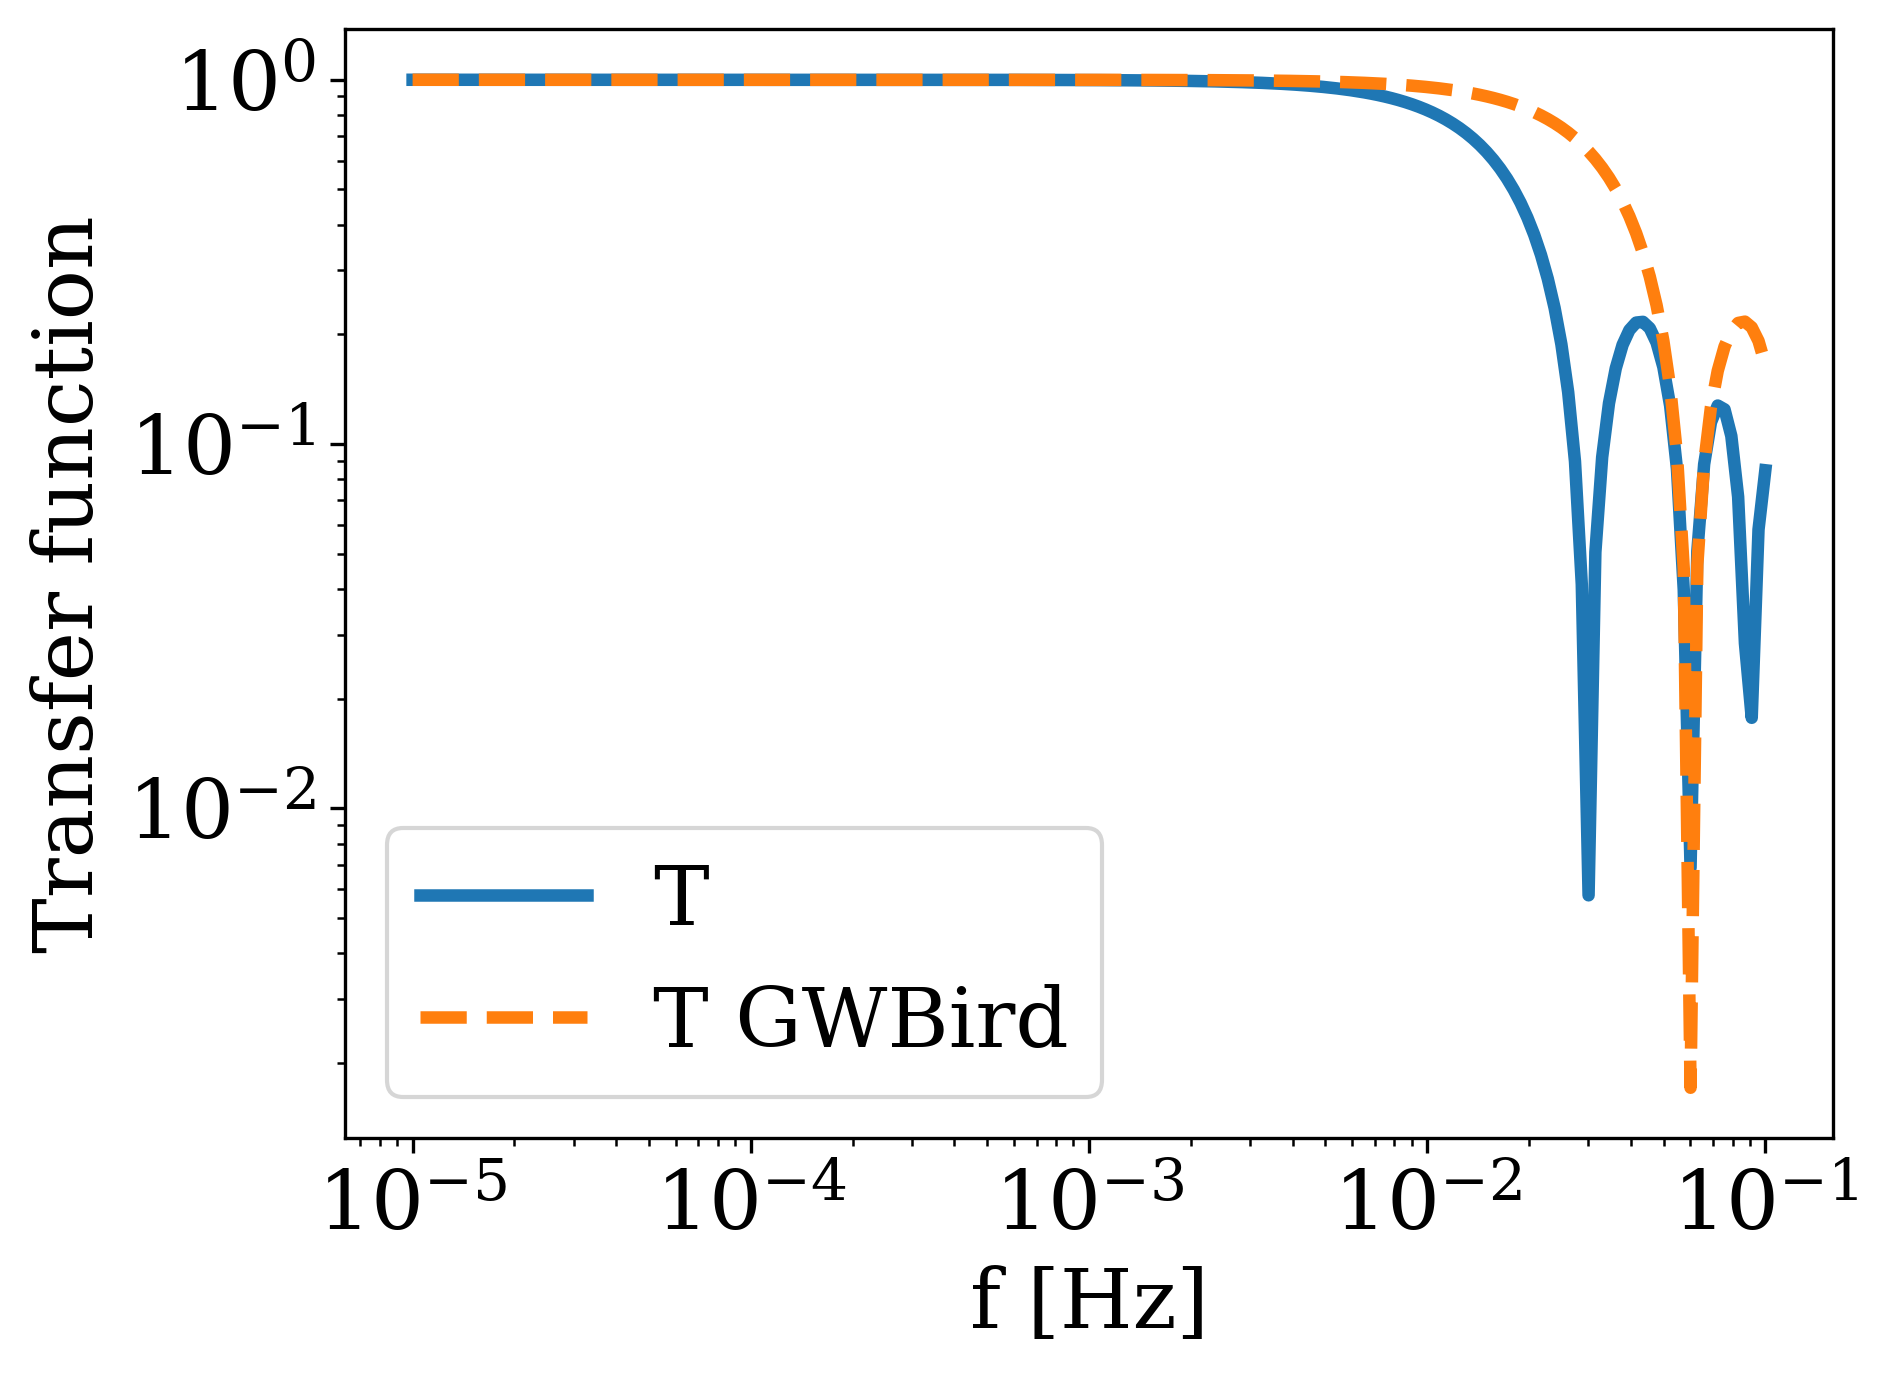

In [298]:
f_t= np.logspace(-5,-1,200)
T = np.real(F_cal(lBA,Omega,np.expand_dims(f_t,axis=(1,2)),f_star))
T = np.squeeze(T[:,0, 0])

theta = np.array(0)
phi = np.array(0)

theta = np.expand_dims(theta, axis=(0,1))
phi = np.expand_dims(phi, axis=(0,1))
T_GWBird = nell.get_tf(f_t, 'LISA 1', theta, phi, 0, shift_angle=None)
T_GWBird_first_column = np.squeeze(T_GWBird[:, 0])

print(T_GWBird_first_column.shape)
print(T.shape)

plt.plot(f_t, np.abs(T), label='T')
plt.plot(f_t, np.abs(T_GWBird_first_column), label='T GWBird', linestyle='--')  
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Transfer function')
plt.legend()


Text(0, 0.5, 'differences')

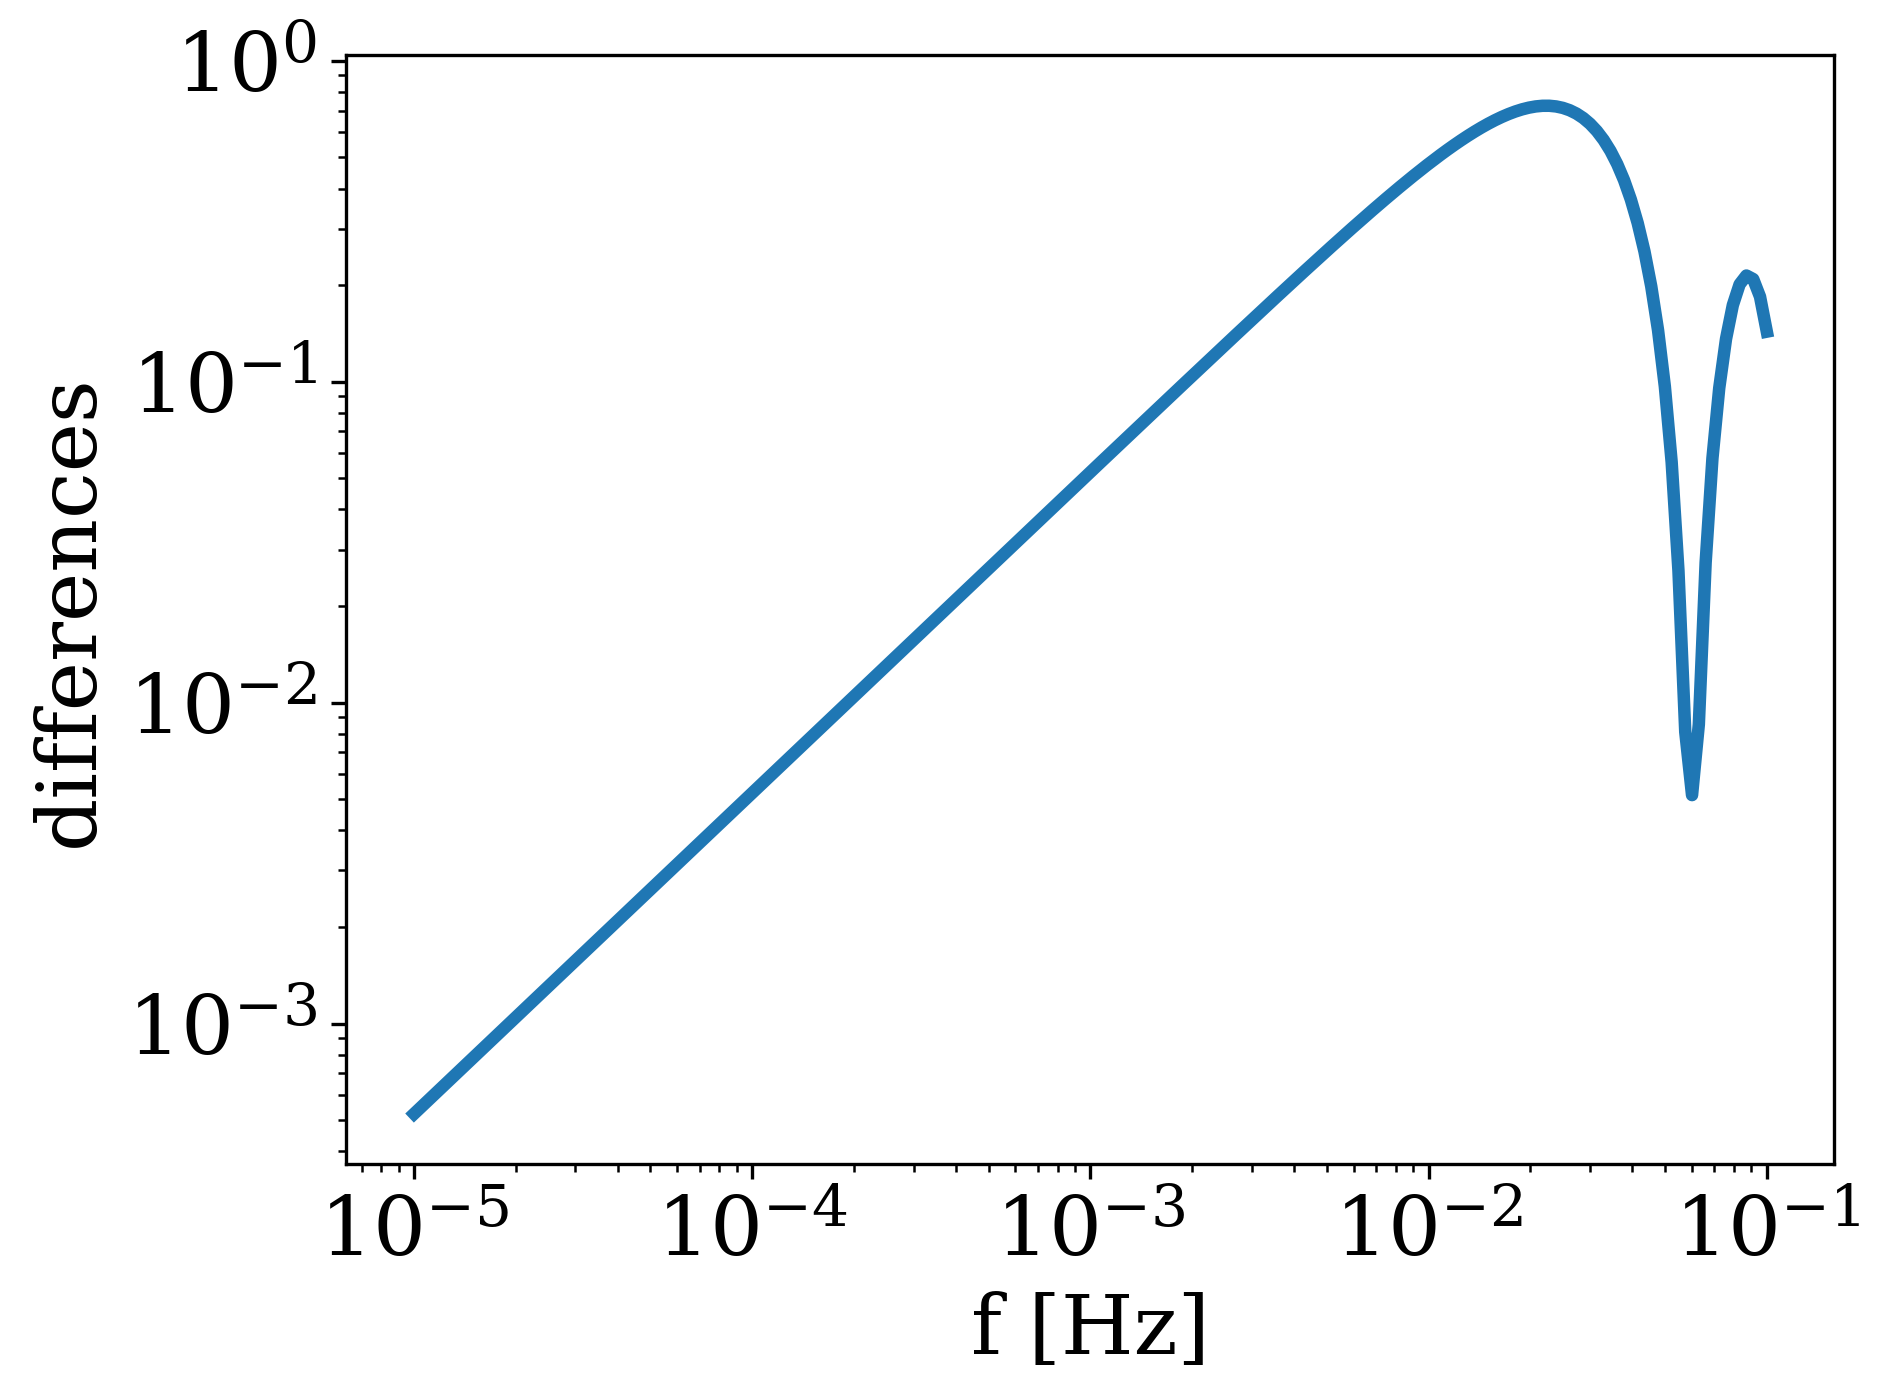

In [299]:
# differences in the transfer function  

diff = (T - T_GWBird_first_column)

plt.plot(f_t, np.abs(diff))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('differences')
